## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import csr_matrix,coo_array
from collections import Counter
%matplotlib inline
import scipy
import time
from multiprocessing import Manager,Pool
from worker1 import matrix_helper
from worker2 import picard_helper
from scipy.sparse.linalg import spsolve
import gc

## Utility functions

In [2]:
def createMesh(geo_file,meshFactorForEntireSurface,meshFactorForAdaptiveSurface=None,xSource=None,ySource=None,isMeshRectangle=False):
    '''Create Mesh File'''
    gmsh.initialize()
    gmsh.open(geo_file)
    if isMeshRectangle:
        gmsh.model.mesh.MeshSizeExtendFromBoundary = 0;
        gmsh.model.mesh.MeshSizeFromPoints = 0;
        gmsh.model.mesh.MeshSizeFromCurvature = 0;
        lenghtofAdaptiveSurface = 6 #mm
        gmsh.model.mesh.field.add("Box", 1)
        gmsh.model.mesh.field.setNumber(1, "VOut", meshFactorForEntireSurface)
        gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
        gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForAdaptiveSurface)     
        gmsh.model.mesh.field.setNumber(1, "XMax", min(xSource + lenghtofAdaptiveSurface,100)) 
        gmsh.model.mesh.field.setNumber(1, "XMin", max(xSource - lenghtofAdaptiveSurface,0)) 
        gmsh.model.mesh.field.setNumber(1, "YMax", min(ySource + lenghtofAdaptiveSurface,50)) 
        gmsh.model.mesh.field.setNumber(1, "YMin", max(ySource - lenghtofAdaptiveSurface,0))  
        # Apply the combined field as a background mesh
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
    else:
        gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
    gmsh.model.mesh.generate(2)
    mesh_filename = 'Mesh.msh'
    gmsh.write(mesh_filename)
    gmsh.finalize()
    return read_mesh(mesh_filename)

def read_mesh(filepath):
    '''
    Takes in an msh file and should return nodal coordinates and element connectivity in each physical group along with the boundary nodes 
    '''
    gmsh.initialize()
    gmsh.open(filepath)
    print(f"Reading {filepath}")
    print(f"Number of nodes in the mesh: {int(gmsh.option.getNumber('Mesh.NbNodes'))}")
    print(f"Number of triangles in the mesh: {int(gmsh.option.getNumber('Mesh.NbTriangles'))}\n")

    #Get all nodes
    dim = -1
    tag = -1
    nodeTags, nodecoords, _ = gmsh.model.mesh.getNodes(dim,tag)
    nodecoords = nodecoords.reshape(-1,3) #tags start from 1

    #Get all triangles
    eleType = 2
    tag = -1
    elements_t,ele_con = gmsh.model.mesh.getElementsByType(eleType,-1)
    ele_con = ele_con.reshape(-1,3)  #tags start from 1

    gmsh.finalize()
    return [nodecoords,ele_con] 

In [3]:
''' Functions relating to source term and the properties of Titanium alloy '''
def Q(point,centre,ro):
    x = point[0,0] - centre[0,0]
    y = point[0,1] - centre[0,1]
    Qo = 5 ## amplitude in W/mm^2 
    return Qo*np.exp(-(x**2+y**2)/ro**2)  ## W/m^3

def rho_Ti(T, phase = 'alpha'):
    if phase == 'alpha':
        return -5.13e-5*(T**2)-0.01935*T+4451
    elif phase == 'beta':
        return -2.762e-6*(T**2)-0.1663*T+4468
    elif phase == 'liquid':
        return -0.565*T+5093
    else:
        return T

def cp_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.25*T+483
    elif phase == 'beta':
        return 0.14*T+530
    elif phase == 'liquid':
        return 930
    else:
        return T

def k_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.012*T+3.3
    elif phase == 'beta':
        return 0.016*T-3
    elif phase == 'liquid':
        return 0.0175*T-4.5
    else:
        return T

def props_chooser(T, T_rep, process = 'heating'):
    if (T_rep<1268 and process == 'heating') or (T_rep<=1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'alpha'),cp_Ti(T,phase = 'alpha'),k_Ti(T,phase = 'alpha')
    elif (T_rep<1928 and process == 'heating') or (T_rep>1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'beta'),cp_Ti(T,phase = 'beta'),k_Ti(T,phase = 'beta')
    elif (T_rep>=1928 and process == 'heating') or (T_rep>=1878 and process == 'cooling'):
        return rho_Ti(T,phase = 'liquid'),cp_Ti(T,phase = 'liquid'),k_Ti(T,phase = 'liquid')
    else:
        return -1
  

In [4]:
'''Parallel processing utility functions'''
def flatten(xss):
    return [x for xs in xss for x in xs] 

In [5]:
def point_in_triangle(pt, v1, v2, v3):
    # Barycentric coordinate system to check if point is inside or on the triangle
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    b1 = sign(pt, v1, v2)
    b2 = sign(pt, v2, v3)
    b3 = sign(pt, v3, v1)

    has_neg = (b1 < 0) or (b2 < 0) or (b3 < 0)
    has_pos = (b1 > 0) or (b2 > 0) or (b3 > 0)

    return not (has_neg and has_pos)

def find_element_for_coordinate(nodecoords, ele_con, coords):
    # Calculate bounding boxes for each element
    bounding_boxes = []
    for element in ele_con:
        x_coords = nodecoords[element-1][:,0]
        bounding_boxes.append((np.min(x_coords), np.max(x_coords)))
    bounding_boxes = np.array(bounding_boxes)
    
    # Sort elements by bounding box
    sorted_elements = sorted(range(len(ele_con)), key=lambda i: bounding_boxes[i][0])

    def binary_search(coord):
        left, right, tol = 0, len(sorted_elements) - 1, 3

        # Find leftptr
        while left < right:
            mid = (left + right) // 2
            bbox = bounding_boxes[sorted_elements[mid]]
            if coord[0] < (bbox[1] + tol):
                right = mid
            else:
                left = mid + 1
        leftptr = left - 1
        # Reset left and right for finding rightptr
        left, right = 0, len(sorted_elements) - 1

        # Find rightptr
        while left < right:
            mid = (left + right) // 2
            bbox = bounding_boxes[sorted_elements[mid]]
            if coord[0] > (bbox[0] - tol):
                left = mid + 1
            else:
                right = mid
        rightptr = right
        # Check elements in the range [leftptr, rightptr]
        for i in range(leftptr, rightptr + 1):
            element = ele_con[sorted_elements[i]] - 1
            if point_in_triangle(coord, nodecoords[element[0]], nodecoords[element[1]], nodecoords[element[2]]):
                return sorted_elements[i]
        print(f"Failed to find element using binary srch for coordinate {coord}")
        for i in range(len(sorted_elements)):
            element = ele_con[sorted_elements[i]] - 1
            if point_in_triangle(coord, nodecoords[element[0]], nodecoords[element[1]], nodecoords[element[2]]):
                return sorted_elements[i]
        print(f"Failed to find element for coordinate {coord}")
        return None

    # Find elements for each coordinate
    element_indices = [binary_search(coord) for coord in coords]
    return element_indices

def interpolatingTemperature(nodecoords, ele_con, coords, values):
    coords = coords[:,0:2]
    element_cords = find_element_for_coordinate(nodecoords= nodecoords, ele_con = ele_con, coords = coords)
    interpolated_values = []
    for i,coord in enumerate(coords):
        if element_cords[i] is None:
            print(f"Failed to find element for coordinate {coord}")
            interpolated_values.append(0)
            continue
        dN = np.array([[-1,1,0],[-1,0,1]])
        elements = ele_con[element_cords[i]] - 1
        nodes = nodecoords[elements][:,0:2]
        Jac = (dN@nodes).T
        # print(Jac.shape,coord.shape,nodes[0].shape)
        eta_eps = np.linalg.inv(Jac)@((coord-nodes[0]).reshape(-1,1))
        # print(eta_eps)
        N = np.array([1-eta_eps[0]-eta_eps[1],eta_eps[0],eta_eps[1]])
        # print(N)
        # print(values[elements])
        interpolated_values.append(N.T@(values[elements].reshape(-1)))
    return np.array(interpolated_values).reshape(-1) 


In [6]:
nodecoords = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
ele_con = np.array([[1, 2, 3], [2, 3, 4]])  # Indices are 1-based
coords = np.array([[0.25, 0.25], [0.5, 0.5], [0.75, 0.75]])
values = np.array([10, 20 , 30 , 40])
print(interpolatingTemperature(nodecoords, ele_con, coords, values))

[17.5 25.  32.5]


Reading Mesh.msh
Number of nodes in the mesh: 958
Number of triangles in the mesh: 1812

Reading Mesh.msh
Number of nodes in the mesh: 911
Number of triangles in the mesh: 1718



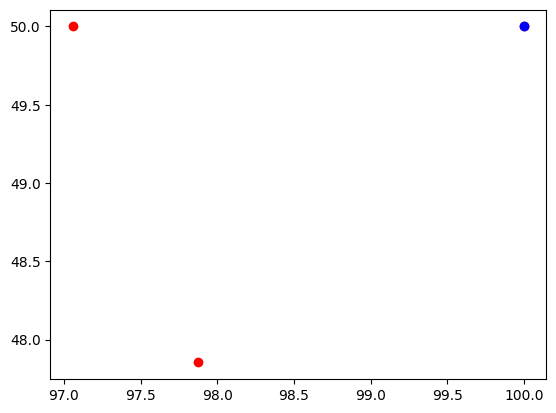

In [7]:
nodecoords,ele_con = createMesh(geo_file='rectange.geo',meshFactorForEntireSurface = 3,meshFactorForAdaptiveSurface=1,xSource=50,ySource=25,isMeshRectangle=True)
nodecoords1,ele_con1 = createMesh(geo_file='rectange.geo',meshFactorForEntireSurface = 3,meshFactorForAdaptiveSurface=1,xSource=52,ySource=25,isMeshRectangle=True)
element_indices = find_element_for_coordinate(nodecoords, ele_con, nodecoords1)

plt.plot(nodecoords[ele_con[element_indices[0]]-1,0],nodecoords[ele_con[element_indices[0]]-1,1],'o',color='r') 
plt.plot(nodecoords1[0,0],nodecoords1[0,1],'bo')    
plt.show()

## Validation of quasi-static solver code

In [8]:
class FEM:
    def __init__(self,nodecoords,elecon,centre):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
        self.centre = centre
    
    def fit_ele(self,theta_prev_time = None,theta_prev_pic = None,mode = "linear",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''

        nodes = self.nodecoords
        ele = self.elecon
        source = self.centre

        #getting the boundary nodes
        
        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        #Data for FEA
        gp = 3
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K_row,K_col,K_data = [],[],[]
        K_D_row,K_D_col,K_D_data = [],[],[]
        G_row,G_col,G_data = [],[],[]
        M_row,M_col,M_data = [],[],[]
        M_D_row,M_D_col,M_D_data = [],[],[]

        #Parallel processing for matrix computations
        items = [(nodes,elei,source,theta_prev_time,theta_prev_pic,mode) for elei in ele]
        st = time.time()
        with Pool() as pool:
            results = pool.map(matrix_helper, items)
        if verbose == True:
            print(f"Time for pooling to end {time.time()-st}")

        #Accumulating data collected over multiprocessing
        st = time.time()
        K_row, K_col, K_data, K_D_row, K_D_col, K_D_data ,G_row, G_col, G_data, M_row, M_col, M_data, M_D_row, M_D_col, M_D_data, F_row,F_data, BT_row, BT_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, K_D_row, K_D_col, K_D_data ,G_row, G_col, G_data, M_row, M_col, M_data, M_D_row, M_D_col, M_D_data, F_row,F_data, BT_row, BT_data]
        K_row, K_col, K_data, K_D_row, K_D_col, K_D_data ,G_row, G_col, G_data, M_row, M_col, M_data, M_D_row, M_D_col, M_D_data, F_row,F_data, BT_row, BT_data = [flatten(mini) for mini in mega]
        if verbose == True:
            print(f"Time for accumulation of data to end {time.time()-st}")

        h = np.sqrt(np.mean(areas)) 
        if verbose == True:
            print(f"Mesh size is {h} mm")
            print(f"Spot radius is 2 mm")

        #Preparing the matrices for calculations
        st = time.time()
        F= coo_array((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        boundary_term = coo_array((BT_data,(BT_row,[0]*len(BT_row))),shape = ((nop,1))).toarray()
        
        K_sparse = coo_array((K_data,(K_row,K_col)),shape=(nop,nop))
        G_sparse = coo_array((G_data,(G_row,G_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for matrices creation {time.time()-st}")

        #Converting sparse to dense matrix for submatrix extractions
        st = time.time()
        K = K_sparse.toarray()
        G = G_sparse.toarray()

        if mode == "no_source":
            F = np.zeros((nop,1))
            G = np.zeros((nop,nop))
        if verbose == True:
            print(f"Time for sparse to dense conversion {time.time()-st}")

        #Setting up the right hand side by subtracting the dirichlet terms
        T_l = 20
        non_ln = np.setdiff1d(np.arange(K.shape[0]),ln)
        rhs = F+boundary_term-T_l*np.sum((K[np.ix_(np.arange(K.shape[0]),ln)]\
                                          +G[np.ix_(np.arange(K.shape[0]),ln)]),axis = 1).reshape(-1,1)

        #Sub matrix extractions
        K_sub = K[np.ix_(non_ln,non_ln)]
        G_sub = G[np.ix_(non_ln,non_ln)]
        rhs_sub = rhs[np.ix_(non_ln,[0])]

        #Back to sparse matrix for efficient inverse computation
        K_sparse = coo_array(K_sub)
        G_sparse = coo_array(G_sub)
        rhs_sparse = coo_array(rhs_sub)
        
        st = time.time()
        theta_sub = scipy.sparse.linalg.spsolve(K_sparse+G_sparse,rhs_sparse)
        if verbose == True:
            print(f"Time for inversion {time.time()-st}")

        #Final solution with the dirichlet imposed
        theta = np.zeros((K.shape[0],1))+T_l
        theta[non_ln,:] = theta_sub.reshape(-1,1)
        
        return [h,K,G,F,boundary_term,theta]


In [9]:
class FEMwithNR:
    def __init__(self,nodecoords,elecon,centre):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
        self.centre = centre
    
    def fit_ele(self,theta_prev_time = None,theta_prev_pic = None,mode = "linear",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''

        nodes = self.nodecoords
        ele = self.elecon
        source = self.centre

        #Data for FEA
        nop = nodes.shape[0]

        K_row,K_col,K_data = [],[],[]
        K_D_row,K_D_col,K_D_data = [],[],[]
        G_row,G_col,G_data = [],[],[]
        M_row,M_col,M_data = [],[],[]
        M_D_row,M_D_col,M_D_data = [],[],[]

        #Parallel processing for matrix computations
        items = [(nodes,elei,source,theta_prev_time,theta_prev_pic,mode) for elei in ele]
        st = time.time()
        with Pool() as pool:
            results = pool.map(matrix_helper, items)
        if verbose == True:
            print(f"Time for pooling to end {time.time()-st}")

        #Accumulating data collected over multiprocessing
        st = time.time()
        K_row, K_col, K_data, K_D_row, K_D_col, K_D_data ,G_row, G_col, G_data, M_row, M_col, M_data, M_D_row, M_D_col, M_D_data, F_row,F_data, BT_row, BT_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, K_D_row, K_D_col, K_D_data ,G_row, G_col, G_data, M_row, M_col, M_data, M_D_row, M_D_col, M_D_data, F_row,F_data, BT_row, BT_data]
        K_row, K_col, K_data, K_D_row, K_D_col, K_D_data ,G_row, G_col, G_data, M_row, M_col, M_data, M_D_row, M_D_col, M_D_data, F_row,F_data, BT_row, BT_data = [flatten(mini) for mini in mega]
        if verbose == True:
            print(f"Time for accumulation of data to end {time.time()-st}")

        self.h = np.sqrt(np.mean(areas)) 
        if verbose == True:
            print(f"Mesh size is {self.h} mm")
            print(f"Spot radius is 2 mm")

        #Preparing the matrices for calculations
        st = time.time()
        self.F = csr_matrix((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        self.boundary_term = csr_matrix((BT_data,(BT_row,[0]*len(BT_row))),shape = ((nop,1))).toarray()
        
        self.K_sparse = csr_matrix((K_data,(K_row,K_col)),shape=(nop,nop))
        self.K_D_sparse = csr_matrix((K_D_data,(K_D_row,K_D_col)),shape=(nop,nop))
        self.G_sparse = csr_matrix((G_data,(G_row,G_col)),shape=(nop,nop))
        self.M_sparse = csr_matrix((M_data,(M_row,M_col)),shape=(nop,nop))
        self.M_D_sparse = csr_matrix((M_D_data,(M_D_row,M_D_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for matrices creation {time.time()-st}")
        return self.K_sparse,self.K_D_sparse,self.G_sparse,self.M_sparse,self.M_D_sparse,self.F,self.boundary_term
    
    def solver(self,theta_prev_time = None,dt = 1e-2,mode = "linear",verbose = False):
        tol = 1e-5
        delta_t = np.zeros((self.nodecoords.shape[0],1))
        # T = 20 + np.zeros((self.nodecoords.shape[0],1))
        theta_prev_pic = theta_prev_time.copy()
        dirichiletBoundary = np.where(self.nodecoords[:,0] == 0)[0]
        dirichiletTemperature = 273 + 20
        n = self.nodecoords.shape[0]
        nodes = np.arange(n)
        interiorNodes = np.delete(nodes,dirichiletBoundary)
        theta_prev_pic[dirichiletBoundary] = dirichiletTemperature
        _,_,_,M_T_minus_1,_,_,_ = self.fit_ele(theta_prev_time,theta_prev_pic,mode,verbose)
        for i in range(20):  
            print(f"Newton Raphson Iteration {i+1}")  
            K,K_D,G,M,M_D,F,Boundary_term = self.fit_ele(theta_prev_time,theta_prev_pic,mode,verbose)
            R = ((M@theta_prev_pic - M_T_minus_1@theta_prev_time)/dt + K@theta_prev_pic - F - Boundary_term)[interiorNodes]
            J = (K_D + M_D/dt)[np.ix_(interiorNodes, interiorNodes)]
            delta_t[interiorNodes] = spsolve(J,-R).reshape(-1,1)  
            print(f"Norm of delta_t is {np.linalg.norm(delta_t)}")
            theta_prev_pic[interiorNodes] = theta_prev_pic[interiorNodes] + delta_t[interiorNodes]
            if np.linalg.norm(delta_t) < tol:
                break
        print(f"Maximum Teperature is {np.max(theta_prev_pic)}")
        return theta_prev_pic

Reading Mesh.msh
Number of nodes in the mesh: 860
Number of triangles in the mesh: 1605

Reading Mesh.msh
Number of nodes in the mesh: 861
Number of triangles in the mesh: 1607

Newton Raphson Iteration 1
Norm of delta_t is 1120.799817966952
Newton Raphson Iteration 2
Norm of delta_t is 241.00316736123835
Newton Raphson Iteration 3
Norm of delta_t is 44.1805506641927
Newton Raphson Iteration 4
Norm of delta_t is 8.259974284955472
Newton Raphson Iteration 5
Norm of delta_t is 1.5254450170653469
Newton Raphson Iteration 6
Norm of delta_t is 0.28123891060335554
Newton Raphson Iteration 7
Norm of delta_t is 0.0517697947164633
Newton Raphson Iteration 8
Norm of delta_t is 0.009524064146954987
Newton Raphson Iteration 9
Norm of delta_t is 0.0017516011525405043
Newton Raphson Iteration 10
Norm of delta_t is 0.0003220964720695017
Newton Raphson Iteration 11
Norm of delta_t is 5.922508124410768e-05
Newton Raphson Iteration 12
Norm of delta_t is 1.0889548389673014e-05
Newton Raphson Iteration 13

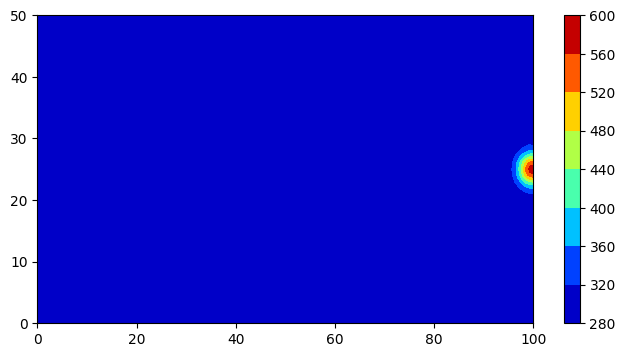

Reading Mesh.msh
Number of nodes in the mesh: 884
Number of triangles in the mesh: 1653

Newton Raphson Iteration 1
Norm of delta_t is 978.6812566887672
Newton Raphson Iteration 2
Norm of delta_t is 248.27404546259456
Newton Raphson Iteration 3
Norm of delta_t is 57.38867543054225
Newton Raphson Iteration 4
Norm of delta_t is 13.27693429394847
Newton Raphson Iteration 5
Norm of delta_t is 3.0108105870661785
Newton Raphson Iteration 6
Norm of delta_t is 0.6784938155483544
Newton Raphson Iteration 7
Norm of delta_t is 0.15225838249304638
Newton Raphson Iteration 8
Norm of delta_t is 0.03410584650574874
Newton Raphson Iteration 9
Norm of delta_t is 0.007632647660542351
Newton Raphson Iteration 10
Norm of delta_t is 0.0017073989081831465
Newton Raphson Iteration 11
Norm of delta_t is 0.0003818601473623915
Newton Raphson Iteration 12
Norm of delta_t is 8.539461446896397e-05
Newton Raphson Iteration 13
Norm of delta_t is 1.9095704829674188e-05
Newton Raphson Iteration 14
Norm of delta_t is 4

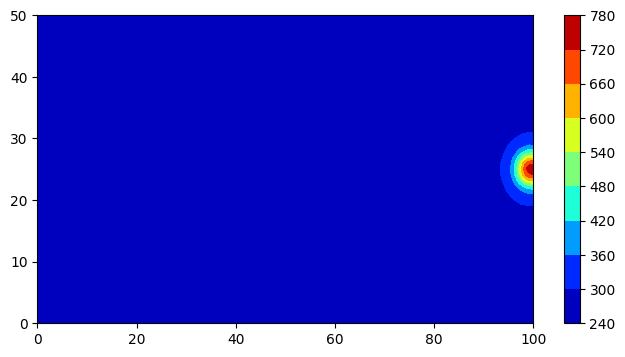

Reading Mesh.msh
Number of nodes in the mesh: 878
Number of triangles in the mesh: 1641

Newton Raphson Iteration 1
Norm of delta_t is 875.1468964267704
Newton Raphson Iteration 2
Norm of delta_t is 235.8080489921565
Newton Raphson Iteration 3
Norm of delta_t is 60.839077575841046
Newton Raphson Iteration 4
Norm of delta_t is 15.68123721682849
Newton Raphson Iteration 5
Norm of delta_t is 3.960542530182458
Newton Raphson Iteration 6
Norm of delta_t is 0.992168206296893
Newton Raphson Iteration 7
Norm of delta_t is 0.24718138064176984
Newton Raphson Iteration 8
Norm of delta_t is 0.06142252204229782
Newton Raphson Iteration 9
Norm of delta_t is 0.015242336400202752
Newton Raphson Iteration 10
Norm of delta_t is 0.0037800132234720924
Newton Raphson Iteration 11
Norm of delta_t is 0.0009371207516618164
Newton Raphson Iteration 12
Norm of delta_t is 0.0002322899064962192
Newton Raphson Iteration 13
Norm of delta_t is 5.757477374962906e-05
Newton Raphson Iteration 14
Norm of delta_t is 1.42

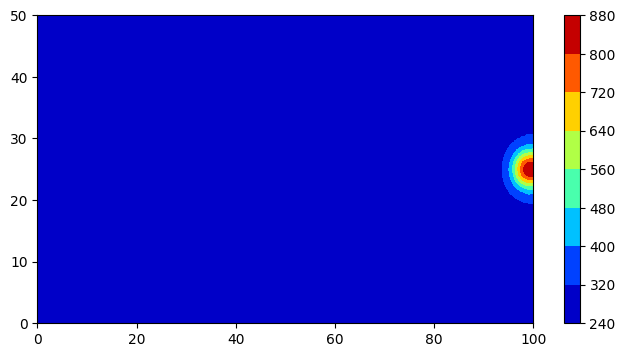

Reading Mesh.msh
Number of nodes in the mesh: 885
Number of triangles in the mesh: 1655

Newton Raphson Iteration 1
Norm of delta_t is 792.1861789744329
Newton Raphson Iteration 2
Norm of delta_t is 216.20454740285368
Newton Raphson Iteration 3
Norm of delta_t is 59.054175052578614
Newton Raphson Iteration 4
Norm of delta_t is 16.207582510450102
Newton Raphson Iteration 5
Norm of delta_t is 4.370132823798101
Newton Raphson Iteration 6
Norm of delta_t is 1.1679430884249895
Newton Raphson Iteration 7
Norm of delta_t is 0.3101638900245806
Newton Raphson Iteration 8
Norm of delta_t is 0.0820998258034178
Newton Raphson Iteration 9
Norm of delta_t is 0.02169216627161488
Newton Raphson Iteration 10
Norm of delta_t is 0.0057260735168092585
Newton Raphson Iteration 11
Norm of delta_t is 0.0015107669545942684
Newton Raphson Iteration 12
Norm of delta_t is 0.000398499934974696
Newton Raphson Iteration 13
Norm of delta_t is 0.00010509988715545669
Newton Raphson Iteration 14
Norm of delta_t is 2.77

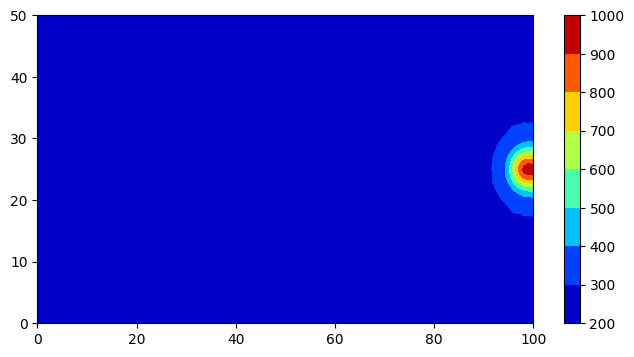

Reading Mesh.msh
Number of nodes in the mesh: 892
Number of triangles in the mesh: 1669

Newton Raphson Iteration 1
Norm of delta_t is 738.1143971101466
Newton Raphson Iteration 2
Norm of delta_t is 197.7815890939877
Newton Raphson Iteration 3
Norm of delta_t is 55.12291209692537
Newton Raphson Iteration 4
Norm of delta_t is 15.639651891568095
Newton Raphson Iteration 5
Norm of delta_t is 4.384591156331868
Newton Raphson Iteration 6
Norm of delta_t is 1.2194475887001344
Newton Raphson Iteration 7
Norm of delta_t is 0.33695972372307453
Newton Raphson Iteration 8
Norm of delta_t is 0.09276102807327553
Newton Raphson Iteration 9
Norm of delta_t is 0.02547848771990024
Newton Raphson Iteration 10
Norm of delta_t is 0.006989287817617183
Newton Raphson Iteration 11
Norm of delta_t is 0.0019159399488752464
Newton Raphson Iteration 12
Norm of delta_t is 0.0005249987999977568
Newton Raphson Iteration 13
Norm of delta_t is 0.00014382636086080627
Newton Raphson Iteration 14
Norm of delta_t is 3.93

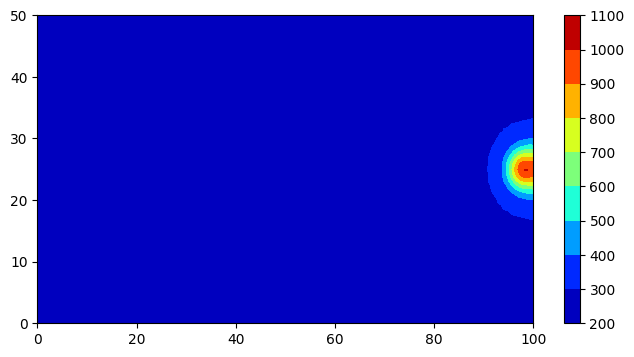

Reading Mesh.msh
Number of nodes in the mesh: 891
Number of triangles in the mesh: 1667

Newton Raphson Iteration 1
Norm of delta_t is 684.0550188024251
Newton Raphson Iteration 2
Norm of delta_t is 178.56657704336826
Newton Raphson Iteration 3
Norm of delta_t is 49.836299511161464
Newton Raphson Iteration 4
Norm of delta_t is 14.361175452847537
Newton Raphson Iteration 5
Norm of delta_t is 4.118780179465327
Newton Raphson Iteration 6
Norm of delta_t is 1.174516822371495
Newton Raphson Iteration 7
Norm of delta_t is 0.3329669404421201
Newton Raphson Iteration 8
Norm of delta_t is 0.09403030775935123
Newton Raphson Iteration 9
Norm of delta_t is 0.026486831742813636
Newton Raphson Iteration 10
Norm of delta_t is 0.0074493084712309145
Newton Raphson Iteration 11
Norm of delta_t is 0.0020930939789446435
Newton Raphson Iteration 12
Norm of delta_t is 0.0005877778586703697
Newton Raphson Iteration 13
Norm of delta_t is 0.0001650017608608638
Newton Raphson Iteration 14
Norm of delta_t is 4.6

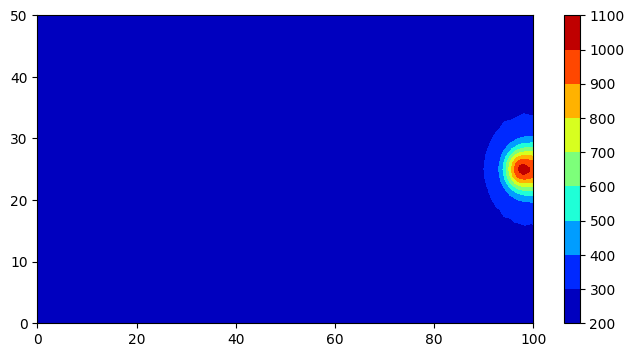

Reading Mesh.msh
Number of nodes in the mesh: 902
Number of triangles in the mesh: 1689

Newton Raphson Iteration 1
Norm of delta_t is 663.3738741853955
Newton Raphson Iteration 2
Norm of delta_t is 167.76147897863373
Newton Raphson Iteration 3
Norm of delta_t is 46.01676513798399
Newton Raphson Iteration 4
Norm of delta_t is 13.239447609779633
Newton Raphson Iteration 5
Norm of delta_t is 3.8293160696474735
Newton Raphson Iteration 6
Norm of delta_t is 1.1064224824513378
Newton Raphson Iteration 7
Norm of delta_t is 0.31849808944077385
Newton Raphson Iteration 8
Norm of delta_t is 0.0914038217195884
Newton Raphson Iteration 9
Norm of delta_t is 0.02617044184307616
Newton Raphson Iteration 10
Norm of delta_t is 0.007481146706261794
Newton Raphson Iteration 11
Norm of delta_t is 0.0021363097229508783
Newton Raphson Iteration 12
Norm of delta_t is 0.0006096203460012596
Newton Raphson Iteration 13
Norm of delta_t is 0.00017388405769760902
Newton Raphson Iteration 14
Norm of delta_t is 4.9

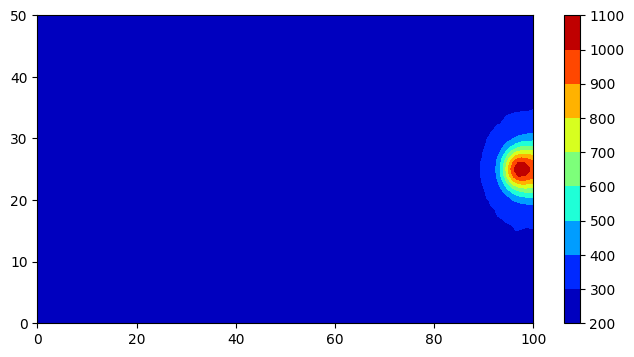

Reading Mesh.msh
Number of nodes in the mesh: 917
Number of triangles in the mesh: 1719

Newton Raphson Iteration 1
Norm of delta_t is 653.3848300124433
Newton Raphson Iteration 2
Norm of delta_t is 160.49187771006564
Newton Raphson Iteration 3
Norm of delta_t is 43.12368531362169
Newton Raphson Iteration 4
Norm of delta_t is 12.29096134944176
Newton Raphson Iteration 5
Norm of delta_t is 3.553273613724418
Newton Raphson Iteration 6
Norm of delta_t is 1.0316531088643626
Newton Raphson Iteration 7
Norm of delta_t is 0.2993116409263449
Newton Raphson Iteration 8
Norm of delta_t is 0.08670489469238685
Newton Raphson Iteration 9
Norm of delta_t is 0.02507636485893738
Newton Raphson Iteration 10
Norm of delta_t is 0.007243076334279687
Newton Raphson Iteration 11
Norm of delta_t is 0.002090053691250993
Newton Raphson Iteration 12
Norm of delta_t is 0.0006026804225029878
Newton Raphson Iteration 13
Norm of delta_t is 0.00017370095540605778
Newton Raphson Iteration 14
Norm of delta_t is 5.0045

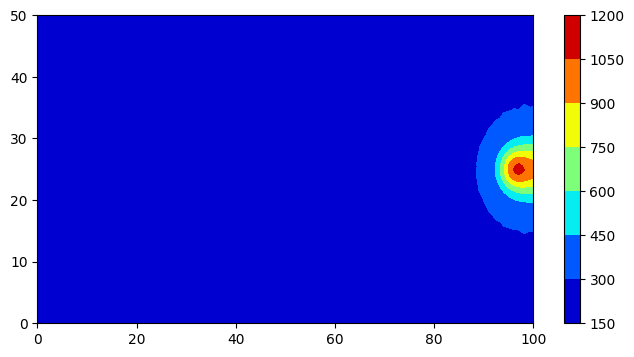

Reading Mesh.msh
Number of nodes in the mesh: 910
Number of triangles in the mesh: 1705

Newton Raphson Iteration 1
Norm of delta_t is 629.6465043591545
Newton Raphson Iteration 2
Norm of delta_t is 154.0387037967577
Newton Raphson Iteration 3
Norm of delta_t is 40.91992980123402
Newton Raphson Iteration 4
Norm of delta_t is 11.548053405233942
Newton Raphson Iteration 5
Norm of delta_t is 3.321958074485792
Newton Raphson Iteration 6
Norm of delta_t is 0.9638635253803672
Newton Raphson Iteration 7
Norm of delta_t is 0.28032976010835453
Newton Raphson Iteration 8
Norm of delta_t is 0.08156493705404345
Newton Raphson Iteration 9
Norm of delta_t is 0.023721488719037318
Newton Raphson Iteration 10
Norm of delta_t is 0.006894380902496159
Newton Raphson Iteration 11
Norm of delta_t is 0.002002475137142579
Newton Raphson Iteration 12
Norm of delta_t is 0.0005812995782520645
Newton Raphson Iteration 13
Norm of delta_t is 0.00016867186235567963
Newton Raphson Iteration 14
Norm of delta_t is 4.89

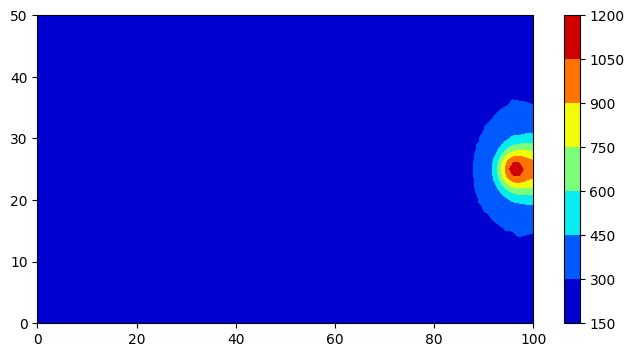

Reading Mesh.msh
Number of nodes in the mesh: 919
Number of triangles in the mesh: 1723

Newton Raphson Iteration 1
Norm of delta_t is 619.8930114457697
Newton Raphson Iteration 2
Norm of delta_t is 150.2867337151135
Newton Raphson Iteration 3
Norm of delta_t is 39.401453678834585
Newton Raphson Iteration 4
Norm of delta_t is 11.009546349641901
Newton Raphson Iteration 5
Norm of delta_t is 3.148099264725079
Newton Raphson Iteration 6
Norm of delta_t is 0.9109382862124195
Newton Raphson Iteration 7
Norm of delta_t is 0.26489956833078
Newton Raphson Iteration 8
Norm of delta_t is 0.07720896723161616
Newton Raphson Iteration 9
Norm of delta_t is 0.022522533532266475
Newton Raphson Iteration 10
Norm of delta_t is 0.006571205591441964
Newton Raphson Iteration 11
Norm of delta_t is 0.0019169806565088757
Newton Raphson Iteration 12
Norm of delta_t is 0.0005590962569406799
Newton Raphson Iteration 13
Norm of delta_t is 0.0001630205686788838
Newton Raphson Iteration 14
Norm of delta_t is 4.7521

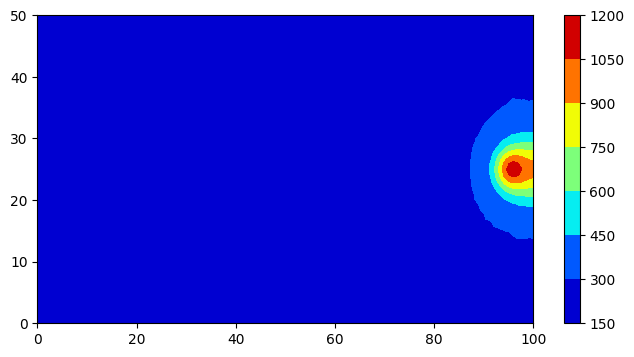

Reading Mesh.msh
Number of nodes in the mesh: 918
Number of triangles in the mesh: 1721

Newton Raphson Iteration 1
Norm of delta_t is 617.3355039994847
Newton Raphson Iteration 2
Norm of delta_t is 149.9958923786143
Newton Raphson Iteration 3
Norm of delta_t is 39.12385521875893
Newton Raphson Iteration 4
Norm of delta_t is 10.856531906038283
Newton Raphson Iteration 5
Norm of delta_t is 3.0854658965405117
Newton Raphson Iteration 6
Norm of delta_t is 0.8888947814883619
Newton Raphson Iteration 7
Norm of delta_t is 0.25782727051316023
Newton Raphson Iteration 8
Norm of delta_t is 0.07507803986396613
Newton Raphson Iteration 9
Norm of delta_t is 0.021909553786630575
Newton Raphson Iteration 10
Norm of delta_t is 0.00640122854728275
Newton Raphson Iteration 11
Norm of delta_t is 0.0018713136439108518
Newton Raphson Iteration 12
Norm of delta_t is 0.000547191668087474
Newton Raphson Iteration 13
Norm of delta_t is 0.00016001596891221636
Newton Raphson Iteration 14
Norm of delta_t is 4.67

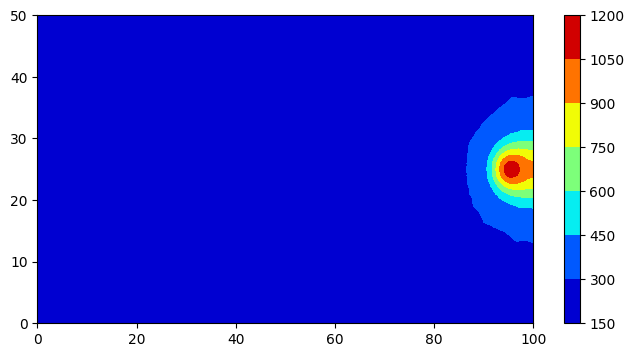

Reading Mesh.msh
Number of nodes in the mesh: 927
Number of triangles in the mesh: 1739

Newton Raphson Iteration 1
Norm of delta_t is 613.2527325267545
Newton Raphson Iteration 2
Norm of delta_t is 148.49881407892588
Newton Raphson Iteration 3
Norm of delta_t is 38.34552464447899
Newton Raphson Iteration 4
Norm of delta_t is 10.549317507065947
Newton Raphson Iteration 5
Norm of delta_t is 2.980980657516638
Newton Raphson Iteration 6
Norm of delta_t is 0.8557181966254761
Newton Raphson Iteration 7
Norm of delta_t is 0.247699613902066
Newton Raphson Iteration 8
Norm of delta_t is 0.07206858069971164
Newton Raphson Iteration 9
Norm of delta_t is 0.021033913176339004
Newton Raphson Iteration 10
Norm of delta_t is 0.006150803179821806
Newton Raphson Iteration 11
Norm of delta_t is 0.001800725493681091
Newton Raphson Iteration 12
Norm of delta_t is 0.0005275426364163257
Newton Raphson Iteration 13
Norm of delta_t is 0.00015460766628104227
Newton Raphson Iteration 14
Norm of delta_t is 4.531

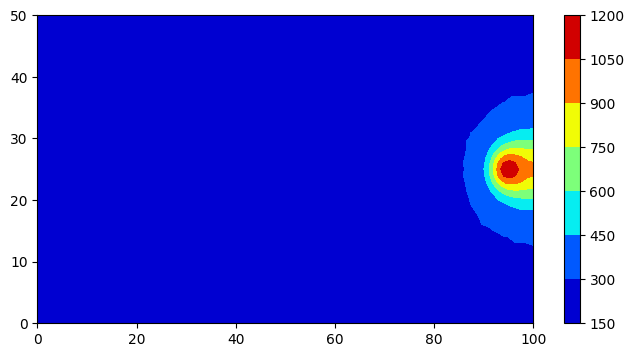

Reading Mesh.msh
Number of nodes in the mesh: 905
Number of triangles in the mesh: 1706

Newton Raphson Iteration 1
Norm of delta_t is 604.9751697565075
Newton Raphson Iteration 2
Norm of delta_t is 146.0775013480339
Newton Raphson Iteration 3
Norm of delta_t is 37.86145605805805
Newton Raphson Iteration 4
Norm of delta_t is 10.436064503788328
Newton Raphson Iteration 5
Norm of delta_t is 2.9474181477576287
Newton Raphson Iteration 6
Norm of delta_t is 0.8441063033191387
Newton Raphson Iteration 7
Norm of delta_t is 0.24352885927867463
Newton Raphson Iteration 8
Norm of delta_t is 0.07060027888394274
Newton Raphson Iteration 9
Norm of delta_t is 0.020535405200740153
Newton Raphson Iteration 10
Norm of delta_t is 0.005987539173321991
Newton Raphson Iteration 11
Norm of delta_t is 0.0017488891859671755
Newton Raphson Iteration 12
Norm of delta_t is 0.0005114983036181838
Newton Raphson Iteration 13
Norm of delta_t is 0.00014974273206420054
Newton Raphson Iteration 14
Norm of delta_t is 4.

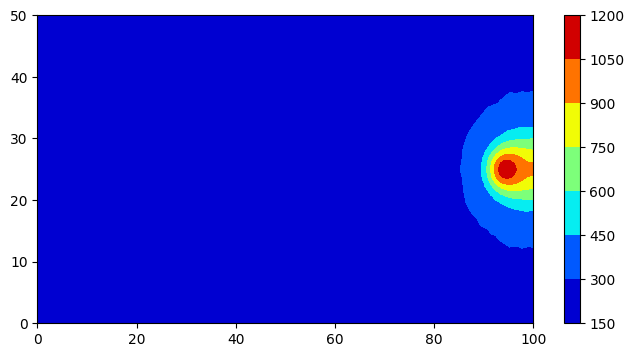

Reading Mesh.msh
Number of nodes in the mesh: 929
Number of triangles in the mesh: 1754

Newton Raphson Iteration 1
Norm of delta_t is 601.7274091140703
Newton Raphson Iteration 2
Norm of delta_t is 144.98260712149354
Newton Raphson Iteration 3
Norm of delta_t is 37.48727472574394
Newton Raphson Iteration 4
Norm of delta_t is 10.31845288264774
Newton Raphson Iteration 5
Norm of delta_t is 2.9129184956561414
Newton Raphson Iteration 6
Norm of delta_t is 0.8343337661339194
Newton Raphson Iteration 7
Norm of delta_t is 0.2408167805749062
Newton Raphson Iteration 8
Norm of delta_t is 0.06985962059009909
Newton Raphson Iteration 9
Norm of delta_t is 0.020336786052663338
Newton Raphson Iteration 10
Norm of delta_t is 0.005935541682740399
Newton Raphson Iteration 11
Norm of delta_t is 0.0017357206746240548
Newton Raphson Iteration 12
Norm of delta_t is 0.0005083189805201186
Newton Raphson Iteration 13
Norm of delta_t is 0.0001490305986880633
Newton Raphson Iteration 14
Norm of delta_t is 4.37

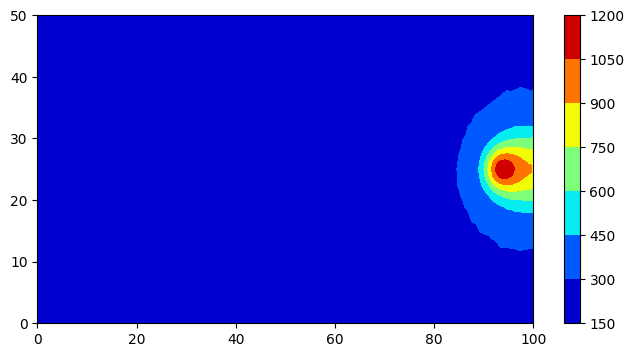

Reading Mesh.msh
Number of nodes in the mesh: 923
Number of triangles in the mesh: 1742

Newton Raphson Iteration 1
Norm of delta_t is 602.1787206734466
Newton Raphson Iteration 2
Norm of delta_t is 145.11661962247018
Newton Raphson Iteration 3
Norm of delta_t is 37.42248237366388
Newton Raphson Iteration 4
Norm of delta_t is 10.267433818011005
Newton Raphson Iteration 5
Norm of delta_t is 2.8911423450919087
Newton Raphson Iteration 6
Norm of delta_t is 0.826568061039907
Newton Raphson Iteration 7
Norm of delta_t is 0.2382502887685737
Newton Raphson Iteration 8
Norm of delta_t is 0.06904271817159645
Newton Raphson Iteration 9
Norm of delta_t is 0.0200826610000198
Newton Raphson Iteration 10
Norm of delta_t is 0.005857824486174492
Newton Raphson Iteration 11
Norm of delta_t is 0.0017122956359272737
Newton Raphson Iteration 12
Norm of delta_t is 0.0005013502960212481
Newton Raphson Iteration 13
Norm of delta_t is 0.00014698239808710737
Newton Raphson Iteration 14
Norm of delta_t is 4.313

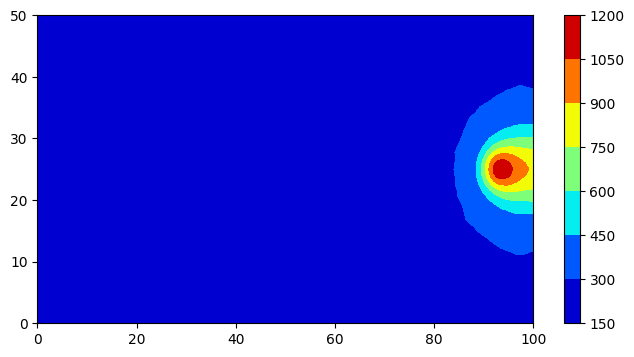

Reading Mesh.msh
Number of nodes in the mesh: 931
Number of triangles in the mesh: 1758

Newton Raphson Iteration 1
Norm of delta_t is 594.9361321095378
Newton Raphson Iteration 2
Norm of delta_t is 143.86569116423547
Newton Raphson Iteration 3
Norm of delta_t is 37.146729436733054
Newton Raphson Iteration 4
Norm of delta_t is 10.19416007584166
Newton Raphson Iteration 5
Norm of delta_t is 2.8713569469949367
Newton Raphson Iteration 6
Norm of delta_t is 0.8213252710268216
Newton Raphson Iteration 7
Norm of delta_t is 0.23688968375350677
Newton Raphson Iteration 8
Norm of delta_t is 0.0686946866044351
Newton Raphson Iteration 9
Norm of delta_t is 0.019994739292099953
Newton Raphson Iteration 10
Norm of delta_t is 0.005835969384741997
Newton Raphson Iteration 11
Norm of delta_t is 0.0017070054849177244
Newton Raphson Iteration 12
Norm of delta_t is 0.0005001277777146436
Newton Raphson Iteration 13
Norm of delta_t is 0.00014672311634184325
Newton Raphson Iteration 14
Norm of delta_t is 4.

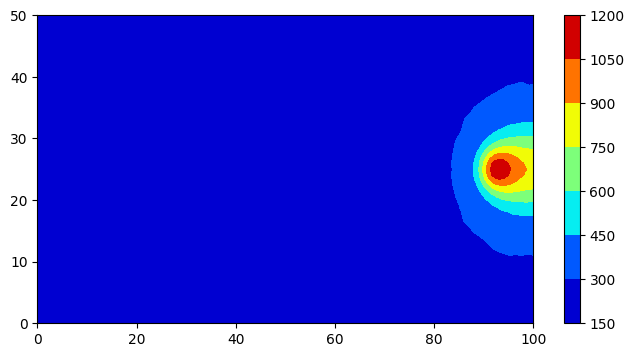

Reading Mesh.msh
Number of nodes in the mesh: 924
Number of triangles in the mesh: 1744

Newton Raphson Iteration 1
Norm of delta_t is 589.6991673192847
Newton Raphson Iteration 2
Norm of delta_t is 143.0237979848096
Newton Raphson Iteration 3
Norm of delta_t is 36.94965918724034
Newton Raphson Iteration 4
Norm of delta_t is 10.135431797895942
Newton Raphson Iteration 5
Norm of delta_t is 2.8536926589039435
Newton Raphson Iteration 6
Norm of delta_t is 0.8162175465999177
Newton Raphson Iteration 7
Norm of delta_t is 0.2354650433978182
Newton Raphson Iteration 8
Norm of delta_t is 0.06830667652993098
Newton Raphson Iteration 9
Norm of delta_t is 0.019890707194013937
Newton Raphson Iteration 10
Norm of delta_t is 0.005808420005726474
Newton Raphson Iteration 11
Norm of delta_t is 0.0016998060751695536
Newton Raphson Iteration 12
Norm of delta_t is 0.0004982792282816476
Newton Raphson Iteration 13
Norm of delta_t is 0.00014626048936772576
Newton Raphson Iteration 14
Norm of delta_t is 4.2

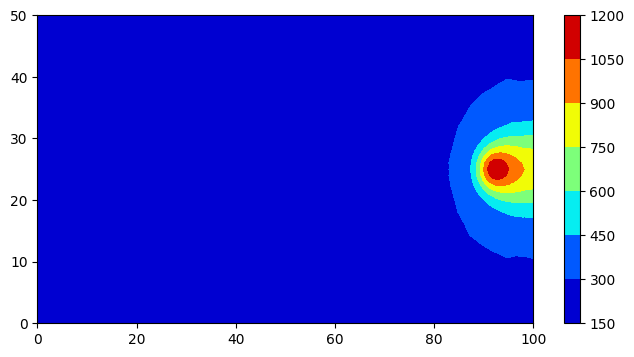

Reading Mesh.msh
Number of nodes in the mesh: 922
Number of triangles in the mesh: 1740

Newton Raphson Iteration 1
Norm of delta_t is 587.6142281454886
Newton Raphson Iteration 2
Norm of delta_t is 142.72546428139978
Newton Raphson Iteration 3
Norm of delta_t is 36.88175113718172
Newton Raphson Iteration 4
Norm of delta_t is 10.114880136735156
Newton Raphson Iteration 5
Norm of delta_t is 2.8481202932888445
Newton Raphson Iteration 6
Norm of delta_t is 0.8149805530288489
Newton Raphson Iteration 7
Norm of delta_t is 0.2352754567371951
Newton Raphson Iteration 8
Norm of delta_t is 0.0683102559790188
Newton Raphson Iteration 9
Norm of delta_t is 0.019909892485870568
Newton Raphson Iteration 10
Norm of delta_t is 0.00581933050573228
Newton Raphson Iteration 11
Norm of delta_t is 0.0017045164363579015
Newton Raphson Iteration 12
Norm of delta_t is 0.0005000918250270506
Newton Raphson Iteration 13
Norm of delta_t is 0.00014691603897076645
Newton Raphson Iteration 14
Norm of delta_t is 4.32

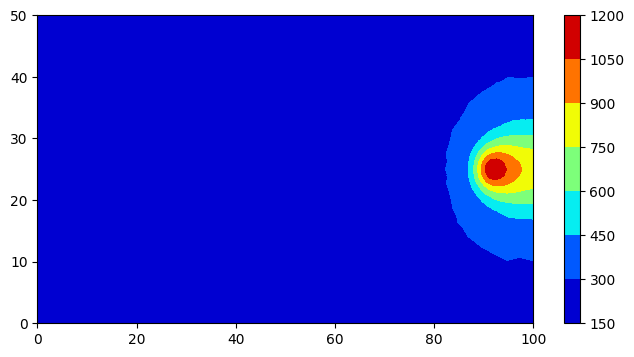

Reading Mesh.msh
Number of nodes in the mesh: 923
Number of triangles in the mesh: 1742

Newton Raphson Iteration 1
Norm of delta_t is 594.5077358217432
Newton Raphson Iteration 2
Norm of delta_t is 143.24996881870726
Newton Raphson Iteration 3
Norm of delta_t is 36.901678614511454
Newton Raphson Iteration 4
Norm of delta_t is 10.103428406120655
Newton Raphson Iteration 5
Norm of delta_t is 2.8424077965305528
Newton Raphson Iteration 6
Norm of delta_t is 0.8130766859507292
Newton Raphson Iteration 7
Norm of delta_t is 0.23474434278144993
Newton Raphson Iteration 8
Norm of delta_t is 0.0681806655957003
Newton Raphson Iteration 9
Norm of delta_t is 0.019882893642400444
Newton Raphson Iteration 10
Norm of delta_t is 0.005815227147398246
Newton Raphson Iteration 11
Norm of delta_t is 0.0017045352651519031
Newton Raphson Iteration 12
Norm of delta_t is 0.0005004751661260797
Newton Raphson Iteration 13
Norm of delta_t is 0.00014714338653811805
Newton Raphson Iteration 14
Norm of delta_t is 4

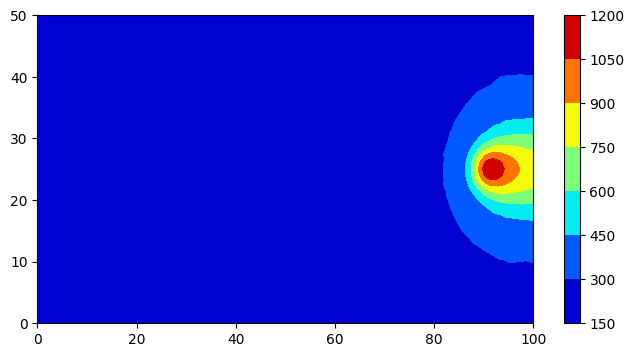

Reading Mesh.msh
Number of nodes in the mesh: 915
Number of triangles in the mesh: 1726

Newton Raphson Iteration 1
Norm of delta_t is 594.8543650182896
Newton Raphson Iteration 2
Norm of delta_t is 144.8172654657032
Newton Raphson Iteration 3
Norm of delta_t is 37.372828100168725
Newton Raphson Iteration 4
Norm of delta_t is 10.222176433266615
Newton Raphson Iteration 5
Norm of delta_t is 2.8717690989417655
Newton Raphson Iteration 6
Norm of delta_t is 0.8205979192366835
Newton Raphson Iteration 7
Norm of delta_t is 0.23676803942842903
Newton Raphson Iteration 8
Norm of delta_t is 0.06875093547965179
Newton Raphson Iteration 9
Norm of delta_t is 0.020049555443651928
Newton Raphson Iteration 10
Norm of delta_t is 0.005865216765699899
Newton Raphson Iteration 11
Norm of delta_t is 0.0017197933257206736
Newton Raphson Iteration 12
Norm of delta_t is 0.0005051850718785619
Newton Raphson Iteration 13
Norm of delta_t is 0.00014860755161375335
Newton Raphson Iteration 14
Norm of delta_t is 4

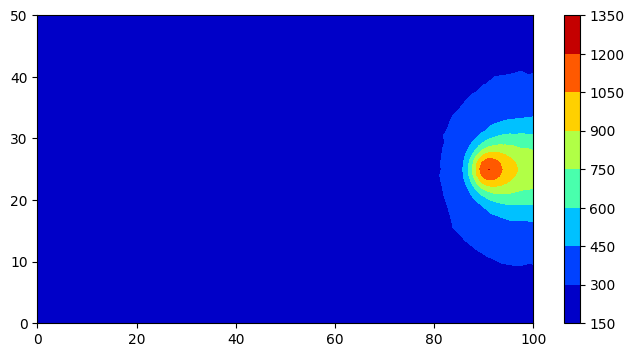

Reading Mesh.msh
Number of nodes in the mesh: 919
Number of triangles in the mesh: 1734

Newton Raphson Iteration 1
Norm of delta_t is 589.4276515080286
Newton Raphson Iteration 2
Norm of delta_t is 143.01497223330426
Newton Raphson Iteration 3
Norm of delta_t is 36.96379193177792
Newton Raphson Iteration 4
Norm of delta_t is 10.140701492928779
Newton Raphson Iteration 5
Norm of delta_t is 2.8585608500131094
Newton Raphson Iteration 6
Norm of delta_t is 0.8194334348033454
Newton Raphson Iteration 7
Norm of delta_t is 0.23710166164555901
Newton Raphson Iteration 8
Norm of delta_t is 0.0690172055188825
Newton Raphson Iteration 9
Norm of delta_t is 0.0201702548916299
Newton Raphson Iteration 10
Norm of delta_t is 0.0059116003773819524
Newton Raphson Iteration 11
Norm of delta_t is 0.0017362884122450713
Newton Raphson Iteration 12
Norm of delta_t is 0.0005107998465722246
Newton Raphson Iteration 13
Norm of delta_t is 0.0001504671442811309
Newton Raphson Iteration 14
Norm of delta_t is 4.43

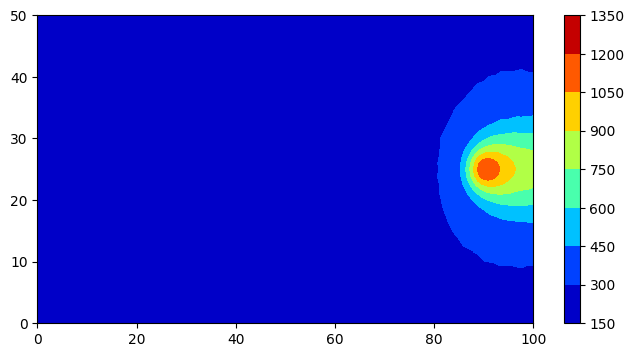

Reading Mesh.msh
Number of nodes in the mesh: 933
Number of triangles in the mesh: 1762

Newton Raphson Iteration 1
Norm of delta_t is 591.6532075332311
Newton Raphson Iteration 2
Norm of delta_t is 144.11523734948128
Newton Raphson Iteration 3
Norm of delta_t is 37.29219470858906
Newton Raphson Iteration 4
Norm of delta_t is 10.227747027582867
Newton Raphson Iteration 5
Norm of delta_t is 2.881592543331358
Newton Raphson Iteration 6
Norm of delta_t is 0.8258470086045904
Newton Raphson Iteration 7
Norm of delta_t is 0.23900198997212097
Newton Raphson Iteration 8
Norm of delta_t is 0.06960902744208285
Newton Raphson Iteration 9
Norm of delta_t is 0.020360204493517945
Newton Raphson Iteration 10
Norm of delta_t is 0.005973406877771694
Newton Raphson Iteration 11
Norm of delta_t is 0.001756463262240546
Newton Raphson Iteration 12
Norm of delta_t is 0.0005173690765838639
Newton Raphson Iteration 13
Norm of delta_t is 0.00015259543900070186
Newton Raphson Iteration 14
Norm of delta_t is 4.5

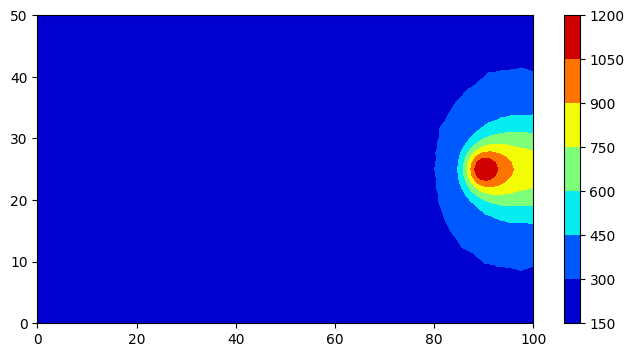

Reading Mesh.msh
Number of nodes in the mesh: 930
Number of triangles in the mesh: 1756

Newton Raphson Iteration 1
Norm of delta_t is 591.9375437744364
Newton Raphson Iteration 2
Norm of delta_t is 144.72254725041006
Newton Raphson Iteration 3
Norm of delta_t is 37.476334581194855
Newton Raphson Iteration 4
Norm of delta_t is 10.271082488064891
Newton Raphson Iteration 5
Norm of delta_t is 2.890985485570591
Newton Raphson Iteration 6
Norm of delta_t is 0.8279259137041521
Newton Raphson Iteration 7
Norm of delta_t is 0.23951960306228873
Newton Raphson Iteration 8
Norm of delta_t is 0.06976147278326984
Newton Raphson Iteration 9
Norm of delta_t is 0.020411547822898706
Newton Raphson Iteration 10
Norm of delta_t is 0.005991842632895264
Newton Raphson Iteration 11
Norm of delta_t is 0.0017631731152422758
Newton Raphson Iteration 12
Norm of delta_t is 0.0005197871958767
Newton Raphson Iteration 13
Norm of delta_t is 0.0001534517065539939
Newton Raphson Iteration 14
Norm of delta_t is 4.535

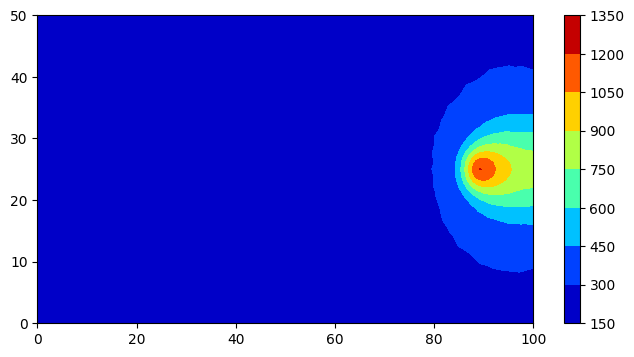

Reading Mesh.msh
Number of nodes in the mesh: 915
Number of triangles in the mesh: 1726

Newton Raphson Iteration 1
Norm of delta_t is 579.0614868748096
Newton Raphson Iteration 2
Norm of delta_t is 142.43525670784848
Newton Raphson Iteration 3
Norm of delta_t is 36.9820548954938
Newton Raphson Iteration 4
Norm of delta_t is 10.14436084241621
Newton Raphson Iteration 5
Norm of delta_t is 2.8560789242490987
Newton Raphson Iteration 6
Norm of delta_t is 0.8181760981729593
Newton Raphson Iteration 7
Norm of delta_t is 0.23681589415092225
Newton Raphson Iteration 8
Norm of delta_t is 0.0690214316127698
Newton Raphson Iteration 9
Norm of delta_t is 0.020211889164711
Newton Raphson Iteration 10
Norm of delta_t is 0.005938782333468801
Newton Raphson Iteration 11
Norm of delta_t is 0.0017493019611574895
Newton Raphson Iteration 12
Norm of delta_t is 0.000516229814083929
Newton Raphson Iteration 13
Norm of delta_t is 0.00015256107129509865
Newton Raphson Iteration 14
Norm of delta_t is 4.513673

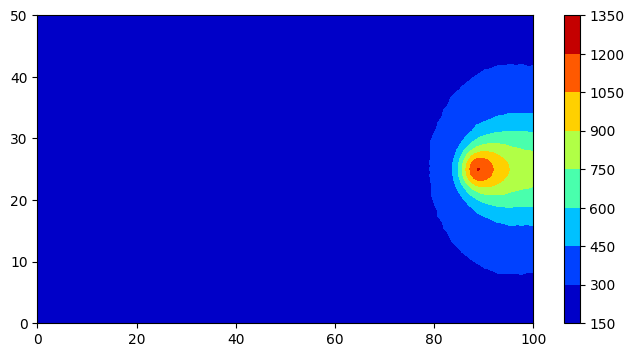

Reading Mesh.msh
Number of nodes in the mesh: 932
Number of triangles in the mesh: 1760

Newton Raphson Iteration 1
Norm of delta_t is 582.75575657103
Newton Raphson Iteration 2
Norm of delta_t is 142.33321710864257
Newton Raphson Iteration 3
Norm of delta_t is 36.85136154256912
Newton Raphson Iteration 4
Norm of delta_t is 10.103306767739975
Newton Raphson Iteration 5
Norm of delta_t is 2.8458323800760628
Newton Raphson Iteration 6
Norm of delta_t is 0.8159448419869434
Newton Raphson Iteration 7
Norm of delta_t is 0.23642752192631322
Newton Raphson Iteration 8
Norm of delta_t is 0.06899451860585556
Newton Raphson Iteration 9
Norm of delta_t is 0.020231674171643618
Newton Raphson Iteration 10
Norm of delta_t is 0.0059531952235908105
Newton Raphson Iteration 11
Norm of delta_t is 0.001756158955723328
Newton Raphson Iteration 12
Norm of delta_t is 0.0005190333611353634
Newton Raphson Iteration 13
Norm of delta_t is 0.00015361993872645165
Newton Raphson Iteration 14
Norm of delta_t is 4.5

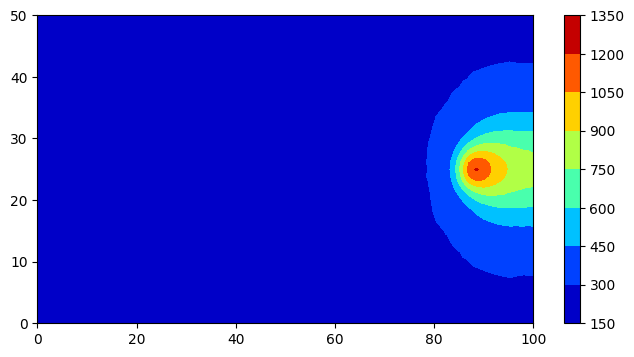

Reading Mesh.msh
Number of nodes in the mesh: 912
Number of triangles in the mesh: 1720

Newton Raphson Iteration 1
Norm of delta_t is 581.5746860535003
Newton Raphson Iteration 2
Norm of delta_t is 142.5433585987964
Newton Raphson Iteration 3
Norm of delta_t is 36.95185074355007
Newton Raphson Iteration 4
Norm of delta_t is 10.134372496636018
Newton Raphson Iteration 5
Norm of delta_t is 2.8549766973879307
Newton Raphson Iteration 6
Norm of delta_t is 0.8186711470811479
Newton Raphson Iteration 7
Norm of delta_t is 0.23725594816432571
Newton Raphson Iteration 8
Norm of delta_t is 0.06925042330504179
Newton Raphson Iteration 9
Norm of delta_t is 0.020311892725017034
Newton Raphson Iteration 10
Norm of delta_t is 0.00597867051388758
Newton Raphson Iteration 11
Norm of delta_t is 0.0017643361579548367
Newton Raphson Iteration 12
Norm of delta_t is 0.0005216786537330822
Newton Raphson Iteration 13
Norm of delta_t is 0.00015447979782576128
Newton Raphson Iteration 14
Norm of delta_t is 4.5

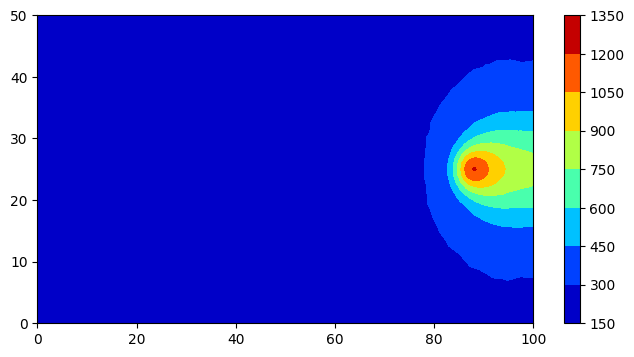

Reading Mesh.msh
Number of nodes in the mesh: 934
Number of triangles in the mesh: 1764

Newton Raphson Iteration 1
Norm of delta_t is 583.9379968270421
Newton Raphson Iteration 2
Norm of delta_t is 143.21823553759899
Newton Raphson Iteration 3
Norm of delta_t is 37.14726090834706
Newton Raphson Iteration 4
Norm of delta_t is 10.196843450258617
Newton Raphson Iteration 5
Norm of delta_t is 2.8757263533464235
Newton Raphson Iteration 6
Norm of delta_t is 0.8255972713742666
Newton Raphson Iteration 7
Norm of delta_t is 0.2395556214525355
Newton Raphson Iteration 8
Norm of delta_t is 0.0700083377929882
Newton Raphson Iteration 9
Norm of delta_t is 0.02055979295377961
Newton Raphson Iteration 10
Norm of delta_t is 0.006059181389186008
Newton Raphson Iteration 11
Norm of delta_t is 0.0017903162279697474
Newton Raphson Iteration 12
Norm of delta_t is 0.0005300141924858318
Newton Raphson Iteration 13
Norm of delta_t is 0.0001571406205329207
Newton Raphson Iteration 14
Norm of delta_t is 4.664

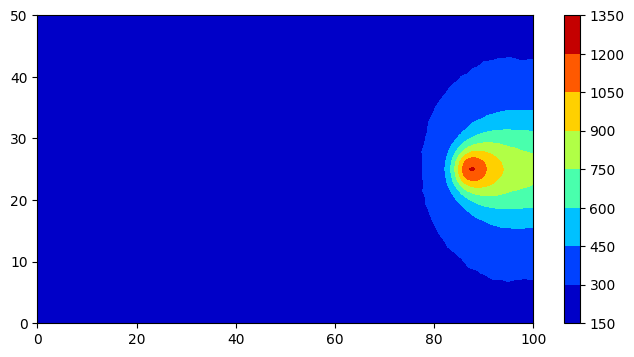

Reading Mesh.msh
Number of nodes in the mesh: 940
Number of triangles in the mesh: 1776

Newton Raphson Iteration 1
Norm of delta_t is 582.5176523459002
Newton Raphson Iteration 2
Norm of delta_t is 142.4706707682447
Newton Raphson Iteration 3
Norm of delta_t is 36.90617923019277
Newton Raphson Iteration 4
Norm of delta_t is 10.121659501087438
Newton Raphson Iteration 5
Norm of delta_t is 2.8526353704418685
Newton Raphson Iteration 6
Norm of delta_t is 0.8186101535297813
Newton Raphson Iteration 7
Norm of delta_t is 0.2374780776132824
Newton Raphson Iteration 8
Norm of delta_t is 0.06940122495182616
Newton Raphson Iteration 9
Norm of delta_t is 0.020385266095117153
Newton Raphson Iteration 10
Norm of delta_t is 0.006009779446298842
Newton Raphson Iteration 11
Norm of delta_t is 0.0017765399742926103
Newton Raphson Iteration 12
Norm of delta_t is 0.0005262302051520126
Newton Raphson Iteration 13
Norm of delta_t is 0.00015611790054100103
Newton Raphson Iteration 14
Norm of delta_t is 4.6

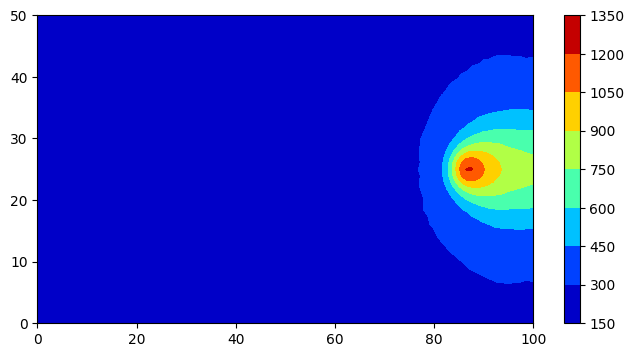

Reading Mesh.msh
Number of nodes in the mesh: 915
Number of triangles in the mesh: 1726

Newton Raphson Iteration 1
Norm of delta_t is 585.3257486993141
Newton Raphson Iteration 2
Norm of delta_t is 144.48703600269852
Newton Raphson Iteration 3
Norm of delta_t is 37.56468889582125
Newton Raphson Iteration 4
Norm of delta_t is 10.299593233890873
Newton Raphson Iteration 5
Norm of delta_t is 2.8980157213232527
Newton Raphson Iteration 6
Norm of delta_t is 0.8301447299767797
Newton Raphson Iteration 7
Norm of delta_t is 0.24046546343500563
Newton Raphson Iteration 8
Norm of delta_t is 0.0701966898970497
Newton Raphson Iteration 9
Norm of delta_t is 0.020603432243321614
Newton Raphson Iteration 10
Norm of delta_t is 0.006071295984201046
Newton Raphson Iteration 11
Norm of delta_t is 0.001794309263939081
Newton Raphson Iteration 12
Norm of delta_t is 0.0005314662169717122
Newton Raphson Iteration 13
Norm of delta_t is 0.0001576853766068624
Newton Raphson Iteration 14
Norm of delta_t is 4.68

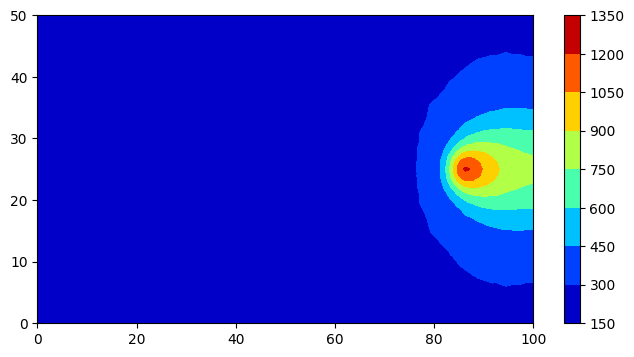

Reading Mesh.msh
Number of nodes in the mesh: 919
Number of triangles in the mesh: 1734

Newton Raphson Iteration 1
Norm of delta_t is 580.4910163721719
Newton Raphson Iteration 2
Norm of delta_t is 142.51732765455023
Newton Raphson Iteration 3
Norm of delta_t is 37.01617811246353
Newton Raphson Iteration 4
Norm of delta_t is 10.16914617940483
Newton Raphson Iteration 5
Norm of delta_t is 2.869640355012276
Newton Raphson Iteration 6
Norm of delta_t is 0.8243692955873301
Newton Raphson Iteration 7
Norm of delta_t is 0.23938891926363495
Newton Raphson Iteration 8
Norm of delta_t is 0.07002954714082041
Newton Raphson Iteration 9
Norm of delta_t is 0.02059094099733485
Newton Raphson Iteration 10
Norm of delta_t is 0.006076920139107458
Newton Raphson Iteration 11
Norm of delta_t is 0.001798409436420415
Newton Raphson Iteration 12
Norm of delta_t is 0.0005333381235411995
Newton Raphson Iteration 13
Norm of delta_t is 0.00015842257110860642
Newton Raphson Iteration 14
Norm of delta_t is 4.711

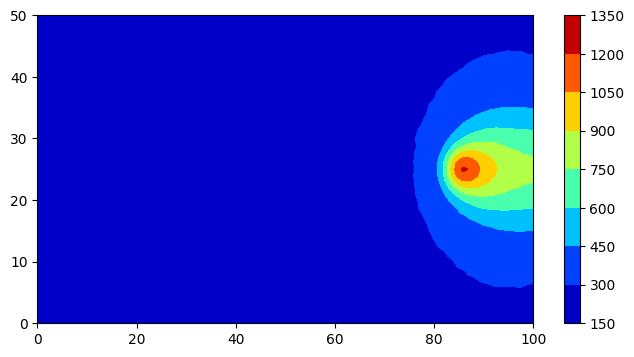

Reading Mesh.msh
Number of nodes in the mesh: 931
Number of triangles in the mesh: 1758

Newton Raphson Iteration 1
Norm of delta_t is 591.2974134428135
Newton Raphson Iteration 2
Norm of delta_t is 145.04039412768591
Newton Raphson Iteration 3
Norm of delta_t is 37.630872958112484
Newton Raphson Iteration 4
Norm of delta_t is 10.326686071518436
Newton Raphson Iteration 5
Norm of delta_t is 2.911375212438305
Newton Raphson Iteration 6
Norm of delta_t is 0.8357575889512708
Newton Raphson Iteration 7
Norm of delta_t is 0.24258466012760538
Newton Raphson Iteration 8
Norm of delta_t is 0.0709503321057965
Newton Raphson Iteration 9
Norm of delta_t is 0.0208624790032
Newton Raphson Iteration 10
Norm of delta_t is 0.006158529789125581
Newton Raphson Iteration 11
Norm of delta_t is 0.0018232935740748006
Newton Raphson Iteration 12
Norm of delta_t is 0.0005410044357348732
Newton Raphson Iteration 13
Norm of delta_t is 0.0001608008761301475
Newton Raphson Iteration 14
Norm of delta_t is 4.785813

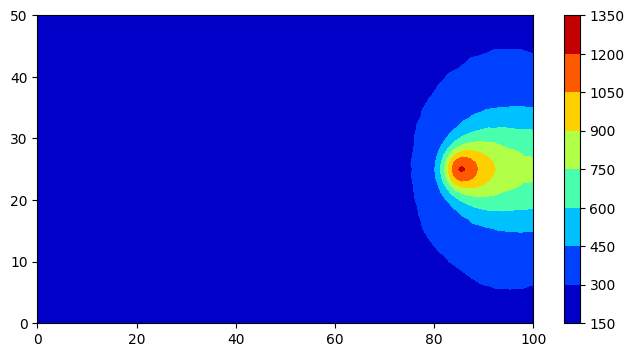

Reading Mesh.msh
Number of nodes in the mesh: 917
Number of triangles in the mesh: 1730

Newton Raphson Iteration 1
Norm of delta_t is 586.3558196350483
Newton Raphson Iteration 2
Norm of delta_t is 144.32928169150438
Newton Raphson Iteration 3
Norm of delta_t is 37.45658548774776
Newton Raphson Iteration 4
Norm of delta_t is 10.2713394774126
Newton Raphson Iteration 5
Norm of delta_t is 2.8934393831195884
Newton Raphson Iteration 6
Norm of delta_t is 0.8301128498189595
Newton Raphson Iteration 7
Norm of delta_t is 0.2408564631963972
Newton Raphson Iteration 8
Norm of delta_t is 0.07043168806822181
Newton Raphson Iteration 9
Norm of delta_t is 0.020709078273767233
Newton Raphson Iteration 10
Norm of delta_t is 0.006113664163253352
Newton Raphson Iteration 11
Norm of delta_t is 0.0018102930134110094
Newton Raphson Iteration 12
Norm of delta_t is 0.0005372682040437095
Newton Raphson Iteration 13
Norm of delta_t is 0.00015973538843675397
Newton Raphson Iteration 14
Norm of delta_t is 4.75

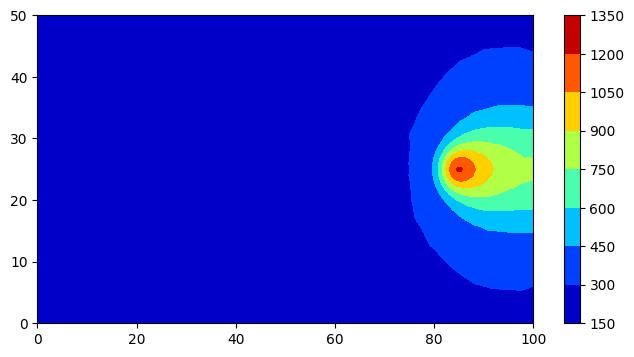

Reading Mesh.msh
Number of nodes in the mesh: 925
Number of triangles in the mesh: 1746

Newton Raphson Iteration 1
Norm of delta_t is 579.6850772521317
Newton Raphson Iteration 2
Norm of delta_t is 142.27815274131777
Newton Raphson Iteration 3
Norm of delta_t is 36.91266740962559
Newton Raphson Iteration 4
Norm of delta_t is 10.13214657645118
Newton Raphson Iteration 5
Norm of delta_t is 2.8584470120028946
Newton Raphson Iteration 6
Norm of delta_t is 0.8213989961317953
Newton Raphson Iteration 7
Norm of delta_t is 0.2387034906874632
Newton Raphson Iteration 8
Norm of delta_t is 0.06990441202596087
Newton Raphson Iteration 9
Norm of delta_t is 0.020581521416518235
Newton Raphson Iteration 10
Norm of delta_t is 0.006083379472938206
Newton Raphson Iteration 11
Norm of delta_t is 0.0018033151852731774
Newton Raphson Iteration 12
Norm of delta_t is 0.0005357394900671154
Newton Raphson Iteration 13
Norm of delta_t is 0.00015943030436655112
Newton Raphson Iteration 14
Norm of delta_t is 4.7

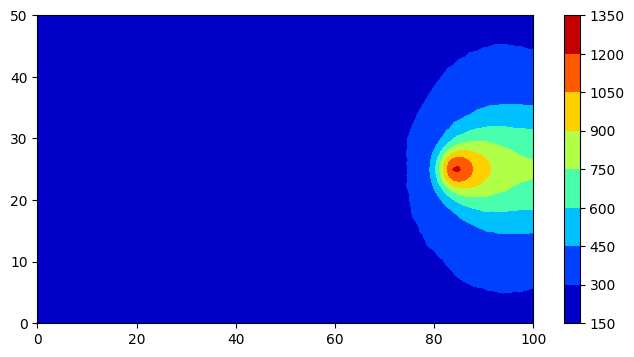

Reading Mesh.msh
Number of nodes in the mesh: 919
Number of triangles in the mesh: 1734

Newton Raphson Iteration 1
Norm of delta_t is 578.9286471736566
Newton Raphson Iteration 2
Norm of delta_t is 142.37901836785514
Newton Raphson Iteration 3
Norm of delta_t is 36.98957431929539
Newton Raphson Iteration 4
Norm of delta_t is 10.160695409256157
Newton Raphson Iteration 5
Norm of delta_t is 2.866906910027131
Newton Raphson Iteration 6
Norm of delta_t is 0.8236578863155609
Newton Raphson Iteration 7
Norm of delta_t is 0.23927937013886544
Newton Raphson Iteration 8
Norm of delta_t is 0.07005030386654214
Newton Raphson Iteration 9
Norm of delta_t is 0.020619402893737055
Newton Raphson Iteration 10
Norm of delta_t is 0.006093700792187081
Newton Raphson Iteration 11
Norm of delta_t is 0.0018063012162272676
Newton Raphson Iteration 12
Norm of delta_t is 0.0005366548988738865
Newton Raphson Iteration 13
Norm of delta_t is 0.00015972400830072264
Newton Raphson Iteration 14
Norm of delta_t is 4.

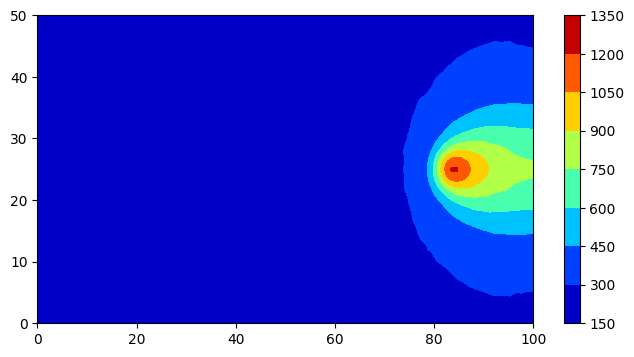

Reading Mesh.msh
Number of nodes in the mesh: 936
Number of triangles in the mesh: 1768

Newton Raphson Iteration 1
Norm of delta_t is 590.4510986071722
Newton Raphson Iteration 2
Norm of delta_t is 145.5485273541477
Newton Raphson Iteration 3
Norm of delta_t is 37.883328873992795
Newton Raphson Iteration 4
Norm of delta_t is 10.410517741094834
Newton Raphson Iteration 5
Norm of delta_t is 2.9367644584749693
Newton Raphson Iteration 6
Norm of delta_t is 0.8433878904101022
Newton Raphson Iteration 7
Norm of delta_t is 0.24492366914460847
Newton Raphson Iteration 8
Norm of delta_t is 0.0716858018032745
Newton Raphson Iteration 9
Norm of delta_t is 0.021098617595613878
Newton Raphson Iteration 10
Norm of delta_t is 0.006235406908528476
Newton Raphson Iteration 11
Norm of delta_t is 0.0018485119834349693
Newton Raphson Iteration 12
Norm of delta_t is 0.0005493013558387705
Newton Raphson Iteration 13
Norm of delta_t is 0.00016353024440259286
Newton Raphson Iteration 14
Norm of delta_t is 4.

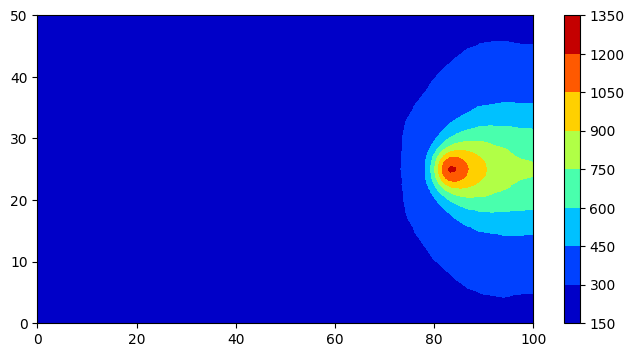

Reading Mesh.msh
Number of nodes in the mesh: 910
Number of triangles in the mesh: 1716

Newton Raphson Iteration 1
Norm of delta_t is 591.9106467838511
Newton Raphson Iteration 2
Norm of delta_t is 144.62380792750645
Newton Raphson Iteration 3
Norm of delta_t is 37.39812775375626
Newton Raphson Iteration 4
Norm of delta_t is 10.244254425343566
Newton Raphson Iteration 5
Norm of delta_t is 2.8876089373550142
Newton Raphson Iteration 6
Norm of delta_t is 0.829711626650755
Newton Raphson Iteration 7
Norm of delta_t is 0.2412089879208356
Newton Raphson Iteration 8
Norm of delta_t is 0.07068202286723843
Newton Raphson Iteration 9
Norm of delta_t is 0.020826429126240237
Newton Raphson Iteration 10
Norm of delta_t is 0.006161087426152152
Newton Raphson Iteration 11
Norm of delta_t is 0.0018280673270553956
Newton Raphson Iteration 12
Norm of delta_t is 0.000543639497830937
Newton Raphson Iteration 13
Norm of delta_t is 0.0001619538528786409
Newton Raphson Iteration 14
Norm of delta_t is 4.831

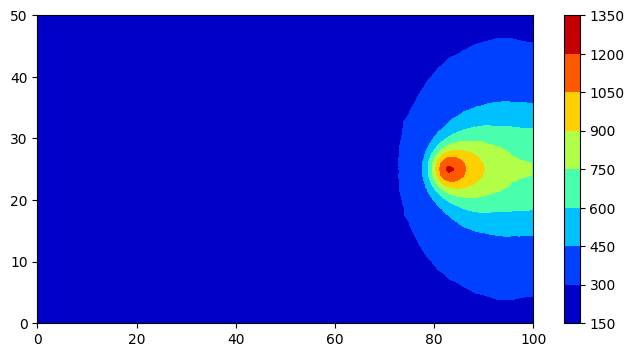

Reading Mesh.msh
Number of nodes in the mesh: 932
Number of triangles in the mesh: 1760

Newton Raphson Iteration 1
Norm of delta_t is 591.3657414161127
Newton Raphson Iteration 2
Norm of delta_t is 144.93973598231844
Newton Raphson Iteration 3
Norm of delta_t is 37.56167493215524
Newton Raphson Iteration 4
Norm of delta_t is 10.298119134379167
Newton Raphson Iteration 5
Norm of delta_t is 2.9023325063228818
Newton Raphson Iteration 6
Norm of delta_t is 0.8334044756713037
Newton Raphson Iteration 7
Norm of delta_t is 0.2421057799589583
Newton Raphson Iteration 8
Norm of delta_t is 0.07090244108450747
Newton Raphson Iteration 9
Norm of delta_t is 0.02088322773196839
Newton Raphson Iteration 10
Norm of delta_t is 0.006176777668806208
Newton Raphson Iteration 11
Norm of delta_t is 0.001832725461844362
Newton Raphson Iteration 12
Norm of delta_t is 0.0005451047054045374
Newton Raphson Iteration 13
Norm of delta_t is 0.00016243220850808648
Newton Raphson Iteration 14
Norm of delta_t is 4.84

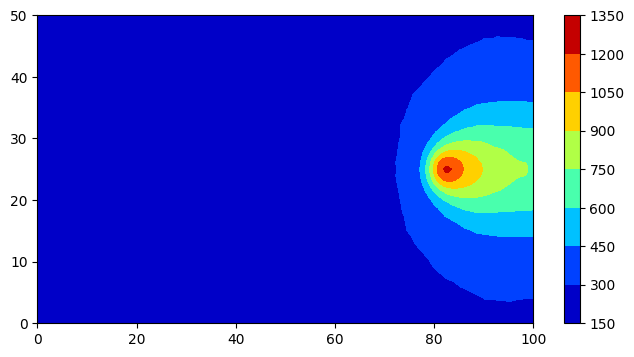

Reading Mesh.msh
Number of nodes in the mesh: 921
Number of triangles in the mesh: 1738

Newton Raphson Iteration 1
Norm of delta_t is 584.0148694275524
Newton Raphson Iteration 2
Norm of delta_t is 143.89550935250887
Newton Raphson Iteration 3
Norm of delta_t is 37.43402561453312
Newton Raphson Iteration 4
Norm of delta_t is 10.293744910088039
Newton Raphson Iteration 5
Norm of delta_t is 2.907685112601051
Newton Raphson Iteration 6
Norm of delta_t is 0.8363780332545361
Newton Raphson Iteration 7
Norm of delta_t is 0.24329137522730906
Newton Raphson Iteration 8
Norm of delta_t is 0.07132417110875666
Newton Raphson Iteration 9
Norm of delta_t is 0.021025375154877474
Newton Raphson Iteration 10
Norm of delta_t is 0.006223312476172388
Newton Raphson Iteration 11
Norm of delta_t is 0.0018477016698521696
Newton Raphson Iteration 12
Norm of delta_t is 0.0005498739783664596
Newton Raphson Iteration 13
Norm of delta_t is 0.00016394076523269932
Newton Raphson Iteration 14
Norm of delta_t is 4.

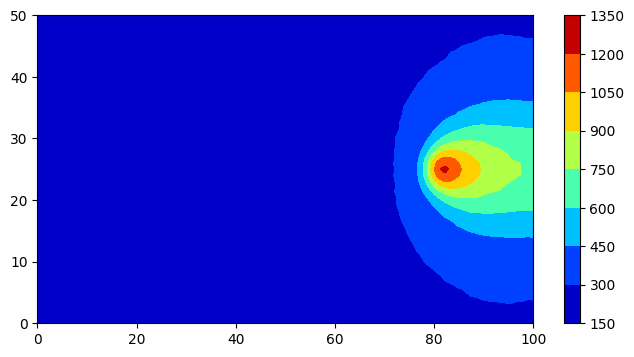

Reading Mesh.msh
Number of nodes in the mesh: 918
Number of triangles in the mesh: 1732

Newton Raphson Iteration 1
Norm of delta_t is 583.6299330111759
Newton Raphson Iteration 2
Norm of delta_t is 143.46453702891773
Newton Raphson Iteration 3
Norm of delta_t is 37.22210463871541
Newton Raphson Iteration 4
Norm of delta_t is 10.213055117131379
Newton Raphson Iteration 5
Norm of delta_t is 2.880762248463429
Newton Raphson Iteration 6
Norm of delta_t is 0.8279884007728741
Newton Raphson Iteration 7
Norm of delta_t is 0.24077025541148617
Newton Raphson Iteration 8
Norm of delta_t is 0.07058059714400587
Newton Raphson Iteration 9
Norm of delta_t is 0.020808124798829136
Newton Raphson Iteration 10
Norm of delta_t is 0.006160127514996901
Newton Raphson Iteration 11
Norm of delta_t is 0.0018293649370630094
Newton Raphson Iteration 12
Norm of delta_t is 0.0005445583492558666
Newton Raphson Iteration 13
Norm of delta_t is 0.00016240089496350548
Newton Raphson Iteration 14
Norm of delta_t is 4.

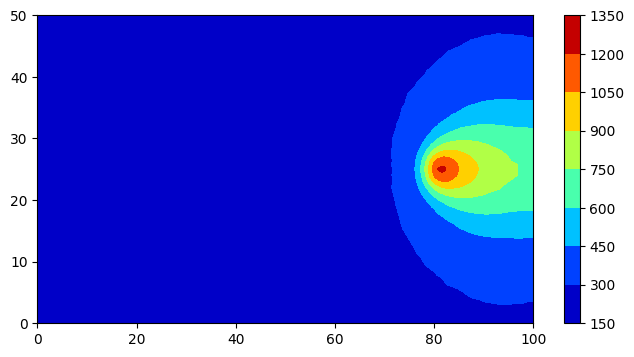

Reading Mesh.msh
Number of nodes in the mesh: 929
Number of triangles in the mesh: 1754

Newton Raphson Iteration 1
Norm of delta_t is 583.64346674441
Newton Raphson Iteration 2
Norm of delta_t is 143.28192193865715
Newton Raphson Iteration 3
Norm of delta_t is 37.197666611722994
Newton Raphson Iteration 4
Norm of delta_t is 10.217599095714318
Newton Raphson Iteration 5
Norm of delta_t is 2.8844717579612635
Newton Raphson Iteration 6
Norm of delta_t is 0.8293881243127509
Newton Raphson Iteration 7
Norm of delta_t is 0.24119194687064469
Newton Raphson Iteration 8
Norm of delta_t is 0.0706942718179447
Newton Raphson Iteration 9
Norm of delta_t is 0.02083677522936048
Newton Raphson Iteration 10
Norm of delta_t is 0.0061670272225808976
Newton Raphson Iteration 11
Norm of delta_t is 0.0018309734789801104
Newton Raphson Iteration 12
Norm of delta_t is 0.0005449254314461825
Newton Raphson Iteration 13
Norm of delta_t is 0.00016248407507577335
Newton Raphson Iteration 14
Norm of delta_t is 4.8

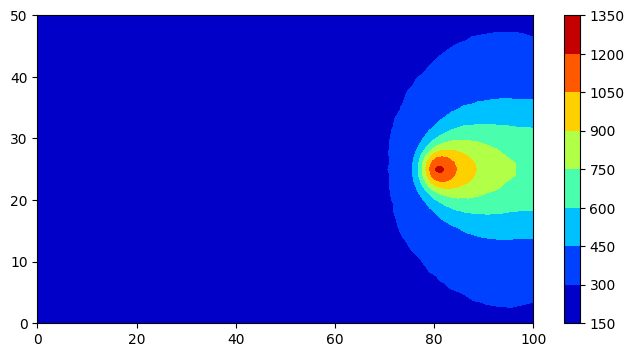

Reading Mesh.msh
Number of nodes in the mesh: 914
Number of triangles in the mesh: 1724

Newton Raphson Iteration 1
Norm of delta_t is 581.578652553704
Newton Raphson Iteration 2
Norm of delta_t is 142.86942604357677
Newton Raphson Iteration 3
Norm of delta_t is 37.13665850078499
Newton Raphson Iteration 4
Norm of delta_t is 10.208650058170191
Newton Raphson Iteration 5
Norm of delta_t is 2.8828295144054255
Newton Raphson Iteration 6
Norm of delta_t is 0.8289765492949618
Newton Raphson Iteration 7
Norm of delta_t is 0.241066968457989
Newton Raphson Iteration 8
Norm of delta_t is 0.0706545804095244
Newton Raphson Iteration 9
Norm of delta_t is 0.020824414187493392
Newton Raphson Iteration 10
Norm of delta_t is 0.0061633267022167615
Newton Raphson Iteration 11
Norm of delta_t is 0.0018299153197232348
Newton Raphson Iteration 12
Norm of delta_t is 0.0005446381555639006
Newton Raphson Iteration 13
Norm of delta_t is 0.00016241095384968615
Newton Raphson Iteration 14
Norm of delta_t is 4.85

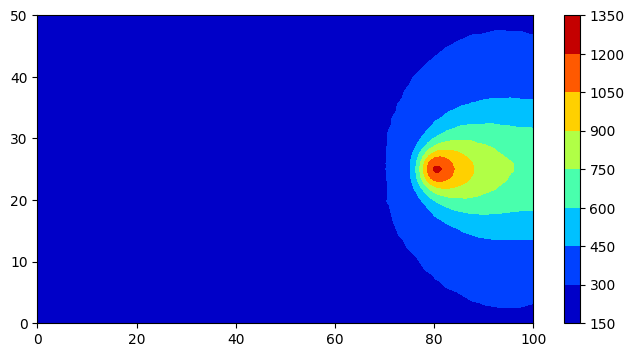

Reading Mesh.msh
Number of nodes in the mesh: 913
Number of triangles in the mesh: 1722

Newton Raphson Iteration 1
Norm of delta_t is 585.8090021563925
Newton Raphson Iteration 2
Norm of delta_t is 143.67063734150548
Newton Raphson Iteration 3
Norm of delta_t is 37.28293642589844
Newton Raphson Iteration 4
Norm of delta_t is 10.239757720785343
Newton Raphson Iteration 5
Norm of delta_t is 2.8905089232084267
Newton Raphson Iteration 6
Norm of delta_t is 0.8310977698065215
Newton Raphson Iteration 7
Norm of delta_t is 0.2416966346598393
Newton Raphson Iteration 8
Norm of delta_t is 0.07084982089515965
Newton Raphson Iteration 9
Norm of delta_t is 0.020886449342266536
Newton Raphson Iteration 10
Norm of delta_t is 0.006183278316853134
Newton Raphson Iteration 11
Norm of delta_t is 0.0018363615343327247
Newton Raphson Iteration 12
Norm of delta_t is 0.0005467213083127944
Newton Raphson Iteration 13
Norm of delta_t is 0.00016308271004122668
Newton Raphson Iteration 14
Norm of delta_t is 4.

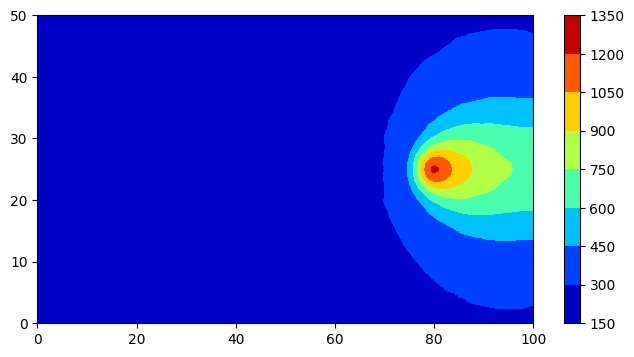

Reading Mesh.msh
Number of nodes in the mesh: 922
Number of triangles in the mesh: 1740

Newton Raphson Iteration 1
Norm of delta_t is 582.0548593474526
Newton Raphson Iteration 2
Norm of delta_t is 143.53269175172412
Newton Raphson Iteration 3
Norm of delta_t is 37.37738185828838
Newton Raphson Iteration 4
Norm of delta_t is 10.286414939136595
Newton Raphson Iteration 5
Norm of delta_t is 2.90725831087464
Newton Raphson Iteration 6
Norm of delta_t is 0.8366066178860226
Newton Raphson Iteration 7
Norm of delta_t is 0.24345213764882276
Newton Raphson Iteration 8
Norm of delta_t is 0.07140175568037221
Newton Raphson Iteration 9
Norm of delta_t is 0.021058781287866233
Newton Raphson Iteration 10
Norm of delta_t is 0.006236850985060849
Newton Raphson Iteration 11
Norm of delta_t is 0.0018529618907655759
Newton Raphson Iteration 12
Norm of delta_t is 0.0005518519373926746
Newton Raphson Iteration 13
Norm of delta_t is 0.00016466506897516985
Newton Raphson Iteration 14
Norm of delta_t is 4.9

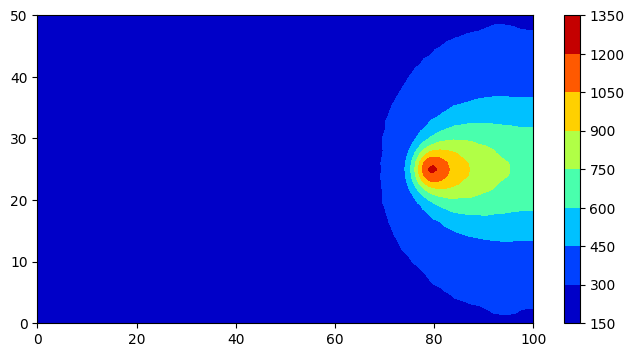

Reading Mesh.msh
Number of nodes in the mesh: 920
Number of triangles in the mesh: 1736

Newton Raphson Iteration 1
Norm of delta_t is 582.9495335971392
Newton Raphson Iteration 2
Norm of delta_t is 143.88574354883295
Newton Raphson Iteration 3
Norm of delta_t is 37.47806862305255
Newton Raphson Iteration 4
Norm of delta_t is 10.314257798536682
Newton Raphson Iteration 5
Norm of delta_t is 2.9152294094202094
Newton Raphson Iteration 6
Norm of delta_t is 0.8389776255383565
Newton Raphson Iteration 7
Norm of delta_t is 0.2441710113504664
Newton Raphson Iteration 8
Norm of delta_t is 0.07162158406055687
Newton Raphson Iteration 9
Norm of delta_t is 0.021126350765275862
Newton Raphson Iteration 10
Norm of delta_t is 0.0062577245692034865
Newton Raphson Iteration 11
Norm of delta_t is 0.001859445308733826
Newton Raphson Iteration 12
Norm of delta_t is 0.0005538767342814994
Newton Raphson Iteration 13
Norm of delta_t is 0.00016530055821298095
Newton Raphson Iteration 14
Norm of delta_t is 4.

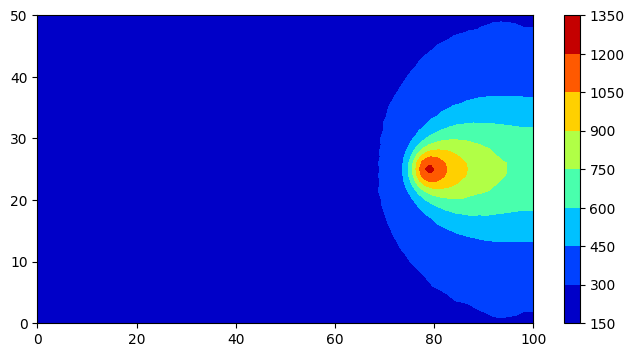

Reading Mesh.msh
Number of nodes in the mesh: 924
Number of triangles in the mesh: 1744

Newton Raphson Iteration 1
Norm of delta_t is 580.7156864908617
Newton Raphson Iteration 2
Norm of delta_t is 143.08870568724038
Newton Raphson Iteration 3
Norm of delta_t is 37.2311687895624
Newton Raphson Iteration 4
Norm of delta_t is 10.240759323380896
Newton Raphson Iteration 5
Norm of delta_t is 2.8937076319229185
Newton Raphson Iteration 6
Norm of delta_t is 0.8327091780905216
Newton Raphson Iteration 7
Norm of delta_t is 0.2423470725863479
Newton Raphson Iteration 8
Norm of delta_t is 0.07109021427874976
Newton Raphson Iteration 9
Norm of delta_t is 0.020971217411564592
Newton Raphson Iteration 10
Norm of delta_t is 0.006212335186255792
Newton Raphson Iteration 11
Norm of delta_t is 0.0018461416397164755
Newton Raphson Iteration 12
Norm of delta_t is 0.0005499727157439611
Newton Raphson Iteration 13
Norm of delta_t is 0.00016415417226848855
Newton Raphson Iteration 14
Norm of delta_t is 4.9

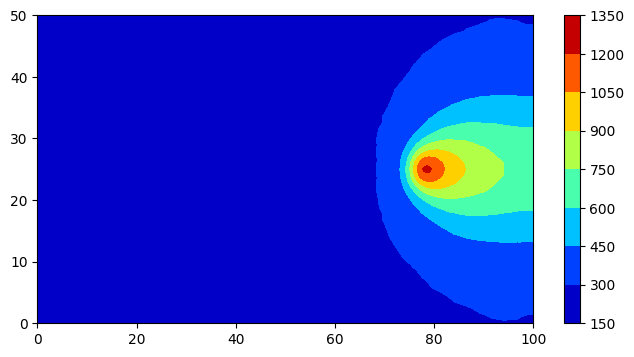

Reading Mesh.msh
Number of nodes in the mesh: 934
Number of triangles in the mesh: 1764

Newton Raphson Iteration 1
Norm of delta_t is 581.6516735462097
Newton Raphson Iteration 2
Norm of delta_t is 143.11095583030698
Newton Raphson Iteration 3
Norm of delta_t is 37.23738750182875
Newton Raphson Iteration 4
Norm of delta_t is 10.2445944444022
Newton Raphson Iteration 5
Norm of delta_t is 2.8953619098697287
Newton Raphson Iteration 6
Norm of delta_t is 0.8333140586859479
Newton Raphson Iteration 7
Norm of delta_t is 0.24255524218745841
Newton Raphson Iteration 8
Norm of delta_t is 0.07116036615847321
Newton Raphson Iteration 9
Norm of delta_t is 0.020994673236018675
Newton Raphson Iteration 10
Norm of delta_t is 0.006220140423531152
Newton Raphson Iteration 11
Norm of delta_t is 0.0018487263621924275
Newton Raphson Iteration 12
Norm of delta_t is 0.0005508240346054179
Newton Raphson Iteration 13
Norm of delta_t is 0.00016443297629767758
Newton Raphson Iteration 14
Norm of delta_t is 4.9

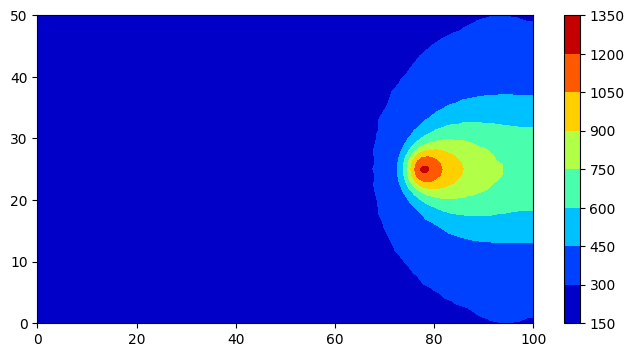

Reading Mesh.msh
Number of nodes in the mesh: 915
Number of triangles in the mesh: 1726

Newton Raphson Iteration 1
Norm of delta_t is 579.6016072834841
Newton Raphson Iteration 2
Norm of delta_t is 143.1154892104232
Newton Raphson Iteration 3
Norm of delta_t is 37.27303684081235
Newton Raphson Iteration 4
Norm of delta_t is 10.254709272006691
Newton Raphson Iteration 5
Norm of delta_t is 2.8973931870147043
Newton Raphson Iteration 6
Norm of delta_t is 0.8335770893915766
Newton Raphson Iteration 7
Norm of delta_t is 0.242530684497515
Newton Raphson Iteration 8
Norm of delta_t is 0.07112342739638544
Newton Raphson Iteration 9
Norm of delta_t is 0.020975376391994153
Newton Raphson Iteration 10
Norm of delta_t is 0.006212123306517641
Newton Raphson Iteration 11
Norm of delta_t is 0.0018457296324927716
Newton Raphson Iteration 12
Norm of delta_t is 0.0005497708445267481
Newton Raphson Iteration 13
Norm of delta_t is 0.00016407751711211002
Newton Raphson Iteration 14
Norm of delta_t is 4.90

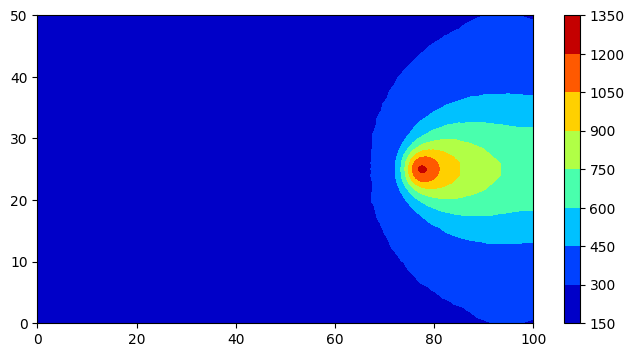

Reading Mesh.msh
Number of nodes in the mesh: 916
Number of triangles in the mesh: 1728

Newton Raphson Iteration 1
Norm of delta_t is 585.7050471122391
Newton Raphson Iteration 2
Norm of delta_t is 143.83192298393848
Newton Raphson Iteration 3
Norm of delta_t is 37.34905529259695
Newton Raphson Iteration 4
Norm of delta_t is 10.262219030204859
Newton Raphson Iteration 5
Norm of delta_t is 2.898120900334452
Newton Raphson Iteration 6
Norm of delta_t is 0.8336997989644236
Newton Raphson Iteration 7
Norm of delta_t is 0.2425858757383069
Newton Raphson Iteration 8
Norm of delta_t is 0.07115225625087482
Newton Raphson Iteration 9
Norm of delta_t is 0.020988704795058297
Newton Raphson Iteration 10
Norm of delta_t is 0.006217661642661159
Newton Raphson Iteration 11
Norm of delta_t is 0.0018478656950328752
Newton Raphson Iteration 12
Norm of delta_t is 0.0005505529239626517
Newton Raphson Iteration 13
Norm of delta_t is 0.00016435337020143814
Newton Raphson Iteration 14
Norm of delta_t is 4.9

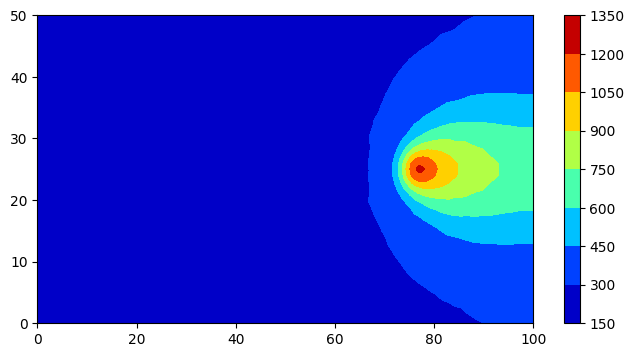

Reading Mesh.msh
Number of nodes in the mesh: 937
Number of triangles in the mesh: 1770

Newton Raphson Iteration 1
Norm of delta_t is 593.1884270737054
Newton Raphson Iteration 2
Norm of delta_t is 145.57439756039483
Newton Raphson Iteration 3
Norm of delta_t is 37.78607981423001
Newton Raphson Iteration 4
Norm of delta_t is 10.375408566887032
Newton Raphson Iteration 5
Norm of delta_t is 2.928325875972449
Newton Raphson Iteration 6
Norm of delta_t is 0.8419994168501114
Newton Raphson Iteration 7
Norm of delta_t is 0.2449220428298398
Newton Raphson Iteration 8
Norm of delta_t is 0.07182263881144528
Newton Raphson Iteration 9
Norm of delta_t is 0.021184000261395185
Newton Raphson Iteration 10
Norm of delta_t is 0.006275226763105608
Newton Raphson Iteration 11
Norm of delta_t is 0.0018649880004608158
Newton Raphson Iteration 12
Norm of delta_t is 0.0005556813300754425
Newton Raphson Iteration 13
Norm of delta_t is 0.00016589755196580032
Newton Raphson Iteration 14
Norm of delta_t is 4.9

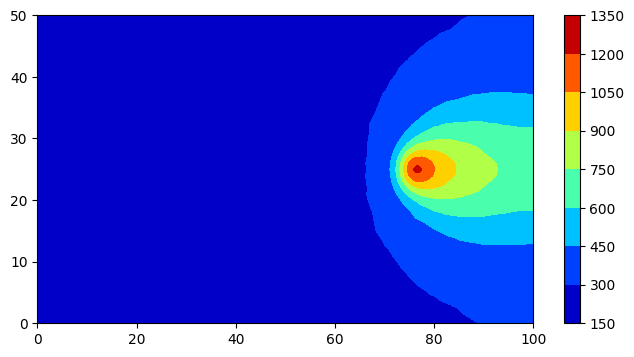

Reading Mesh.msh
Number of nodes in the mesh: 936
Number of triangles in the mesh: 1768

Newton Raphson Iteration 1
Norm of delta_t is 585.6654486041264
Newton Raphson Iteration 2
Norm of delta_t is 144.5205807330708
Newton Raphson Iteration 3
Norm of delta_t is 37.653490785425014
Newton Raphson Iteration 4
Norm of delta_t is 10.367203189420847
Newton Raphson Iteration 5
Norm of delta_t is 2.931637853729893
Newton Raphson Iteration 6
Norm of delta_t is 0.8440916072556257
Newton Raphson Iteration 7
Norm of delta_t is 0.2457682622295993
Newton Raphson Iteration 8
Norm of delta_t is 0.07212217086898245
Newton Raphson Iteration 9
Norm of delta_t is 0.021283949022853074
Newton Raphson Iteration 10
Norm of delta_t is 0.006307580431745002
Newton Raphson Iteration 11
Norm of delta_t is 0.001875285385494316
Newton Raphson Iteration 12
Norm of delta_t is 0.0005589265385414727
Newton Raphson Iteration 13
Norm of delta_t is 0.00016691419828686107
Newton Raphson Iteration 14
Norm of delta_t is 4.99

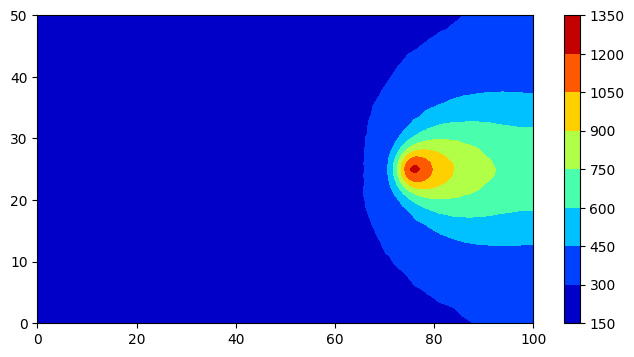

Reading Mesh.msh
Number of nodes in the mesh: 924
Number of triangles in the mesh: 1744

Newton Raphson Iteration 1
Norm of delta_t is 580.7152849182747
Newton Raphson Iteration 2
Norm of delta_t is 143.212483906289
Newton Raphson Iteration 3
Norm of delta_t is 37.294453103587195
Newton Raphson Iteration 4
Norm of delta_t is 10.265413069934818
Newton Raphson Iteration 5
Norm of delta_t is 2.9025718344946116
Newton Raphson Iteration 6
Norm of delta_t is 0.8357753057310249
Newton Raphson Iteration 7
Norm of delta_t is 0.2433833025563997
Newton Raphson Iteration 8
Norm of delta_t is 0.07143535477932635
Newton Raphson Iteration 9
Norm of delta_t is 0.021085092779302483
Newton Raphson Iteration 10
Norm of delta_t is 0.006249673904434398
Newton Raphson Iteration 11
Norm of delta_t is 0.0018583321126530712
Newton Raphson Iteration 12
Norm of delta_t is 0.0005539399997952206
Newton Raphson Iteration 13
Norm of delta_t is 0.00016544192655527535
Newton Raphson Iteration 14
Norm of delta_t is 4.9

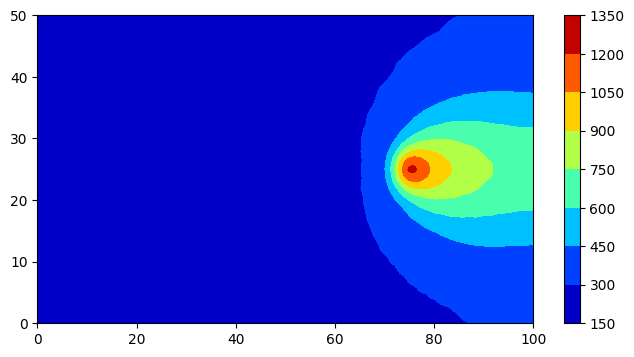

Reading Mesh.msh
Number of nodes in the mesh: 924
Number of triangles in the mesh: 1744

Newton Raphson Iteration 1
Norm of delta_t is 582.8518207612215
Newton Raphson Iteration 2
Norm of delta_t is 143.60820282038588
Newton Raphson Iteration 3
Norm of delta_t is 37.38197551749875
Newton Raphson Iteration 4
Norm of delta_t is 10.287287288374053
Newton Raphson Iteration 5
Norm of delta_t is 2.9083998570761627
Newton Raphson Iteration 6
Norm of delta_t is 0.8373798263630108
Newton Raphson Iteration 7
Norm of delta_t is 0.24383638121399762
Newton Raphson Iteration 8
Norm of delta_t is 0.07156637336928007
Newton Raphson Iteration 9
Norm of delta_t is 0.02112380318868326
Newton Raphson Iteration 10
Norm of delta_t is 0.006261315922743835
Newton Raphson Iteration 11
Norm of delta_t is 0.001861880561359536
Newton Raphson Iteration 12
Norm of delta_t is 0.0005550316728432813
Newton Raphson Iteration 13
Norm of delta_t is 0.00016577979730526943
Newton Raphson Iteration 14
Norm of delta_t is 4.9

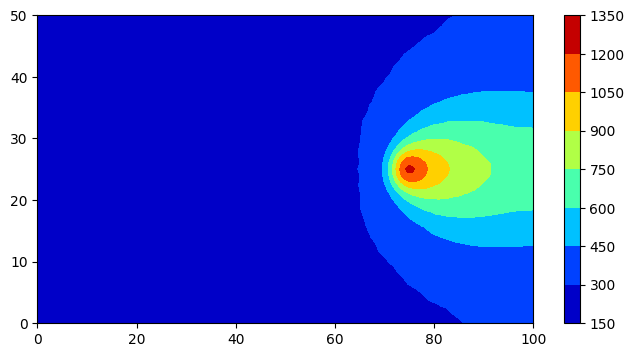

Reading Mesh.msh
Number of nodes in the mesh: 922
Number of triangles in the mesh: 1740

Newton Raphson Iteration 1
Norm of delta_t is 583.665825621959
Newton Raphson Iteration 2
Norm of delta_t is 143.89034615324235
Newton Raphson Iteration 3
Norm of delta_t is 37.45385301542931
Newton Raphson Iteration 4
Norm of delta_t is 10.30506465427366
Newton Raphson Iteration 5
Norm of delta_t is 2.912722346779957
Newton Raphson Iteration 6
Norm of delta_t is 0.8383911977836616
Newton Raphson Iteration 7
Norm of delta_t is 0.2440565777356505
Newton Raphson Iteration 8
Norm of delta_t is 0.07160831580405953
Newton Raphson Iteration 9
Norm of delta_t is 0.021129552623246072
Newton Raphson Iteration 10
Norm of delta_t is 0.006261151566344118
Newton Raphson Iteration 11
Norm of delta_t is 0.0018613203617770034
Newton Raphson Iteration 12
Norm of delta_t is 0.0005547280219856175
Newton Raphson Iteration 13
Norm of delta_t is 0.00016565329048737537
Newton Raphson Iteration 14
Norm of delta_t is 4.954

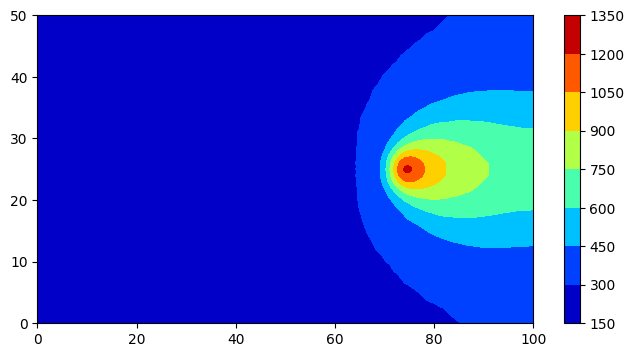

Reading Mesh.msh
Number of nodes in the mesh: 913
Number of triangles in the mesh: 1722

Newton Raphson Iteration 1
Norm of delta_t is 585.7390935322526
Newton Raphson Iteration 2
Norm of delta_t is 144.05026268582708
Newton Raphson Iteration 3
Norm of delta_t is 37.44952100575641
Newton Raphson Iteration 4
Norm of delta_t is 10.299187249721022
Newton Raphson Iteration 5
Norm of delta_t is 2.910602135662935
Newton Raphson Iteration 6
Norm of delta_t is 0.8377564130309771
Newton Raphson Iteration 7
Norm of delta_t is 0.24388033627017602
Newton Raphson Iteration 8
Norm of delta_t is 0.07156199184384573
Newton Raphson Iteration 9
Norm of delta_t is 0.0211180156815718
Newton Raphson Iteration 10
Norm of delta_t is 0.006258459370163837
Newton Raphson Iteration 11
Norm of delta_t is 0.001860749116640127
Newton Raphson Iteration 12
Norm of delta_t is 0.0005546267311024794
Newton Raphson Iteration 13
Norm of delta_t is 0.00016564318965938622
Newton Raphson Iteration 14
Norm of delta_t is 4.954

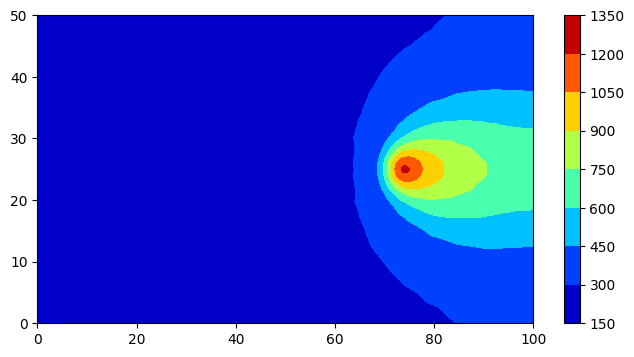

Reading Mesh.msh
Number of nodes in the mesh: 912
Number of triangles in the mesh: 1720

Newton Raphson Iteration 1
Norm of delta_t is 579.7449845258633
Newton Raphson Iteration 2
Norm of delta_t is 143.35975813413515
Newton Raphson Iteration 3
Norm of delta_t is 37.41809769581375
Newton Raphson Iteration 4
Norm of delta_t is 10.316457732653978
Newton Raphson Iteration 5
Norm of delta_t is 2.92031188069973
Newton Raphson Iteration 6
Norm of delta_t is 0.8415195892147392
Newton Raphson Iteration 7
Norm of delta_t is 0.24518907475989968
Newton Raphson Iteration 8
Norm of delta_t is 0.07199631389992553
Newton Raphson Iteration 9
Norm of delta_t is 0.02125862085778416
Newton Raphson Iteration 10
Norm of delta_t is 0.0063032904170906385
Newton Raphson Iteration 11
Norm of delta_t is 0.0018748960854301352
Newton Raphson Iteration 12
Norm of delta_t is 0.0005590575919360647
Newton Raphson Iteration 13
Norm of delta_t is 0.00016702310803834544
Newton Raphson Iteration 14
Norm of delta_t is 4.9

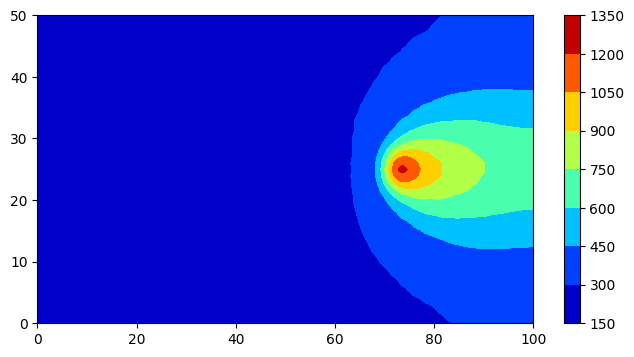

Reading Mesh.msh
Number of nodes in the mesh: 918
Number of triangles in the mesh: 1732

Newton Raphson Iteration 1
Norm of delta_t is 583.9270486837679
Newton Raphson Iteration 2
Norm of delta_t is 144.30991568455414
Newton Raphson Iteration 3
Norm of delta_t is 37.641072626969205
Newton Raphson Iteration 4
Norm of delta_t is 10.372827646788298
Newton Raphson Iteration 5
Norm of delta_t is 2.935518724181013
Newton Raphson Iteration 6
Norm of delta_t is 0.8458410163066526
Newton Raphson Iteration 7
Norm of delta_t is 0.246454821720359
Newton Raphson Iteration 8
Norm of delta_t is 0.07237331318221216
Newton Raphson Iteration 9
Norm of delta_t is 0.02137202343232629
Newton Raphson Iteration 10
Norm of delta_t is 0.00633763819653851
Newton Raphson Iteration 11
Norm of delta_t is 0.00188535702066659
Newton Raphson Iteration 12
Norm of delta_t is 0.0005622585845845944
Newton Raphson Iteration 13
Norm of delta_t is 0.00016800654411222346
Newton Raphson Iteration 14
Norm of delta_t is 5.02795

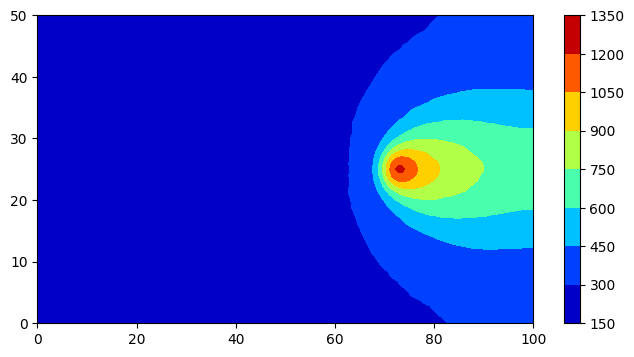

Reading Mesh.msh
Number of nodes in the mesh: 909
Number of triangles in the mesh: 1714

Newton Raphson Iteration 1
Norm of delta_t is 583.0657928460115
Newton Raphson Iteration 2
Norm of delta_t is 143.74775933259795
Newton Raphson Iteration 3
Norm of delta_t is 37.45270843427585
Newton Raphson Iteration 4
Norm of delta_t is 10.313434449959228
Newton Raphson Iteration 5
Norm of delta_t is 2.916947055217824
Newton Raphson Iteration 6
Norm of delta_t is 0.8400300223330215
Newton Raphson Iteration 7
Norm of delta_t is 0.24463719803979034
Newton Raphson Iteration 8
Norm of delta_t is 0.07180584310177296
Newton Raphson Iteration 9
Norm of delta_t is 0.021195387048313533
Newton Raphson Iteration 10
Norm of delta_t is 0.006282849556904668
Newton Raphson Iteration 11
Norm of delta_t is 0.0018684240464722666
Newton Raphson Iteration 12
Norm of delta_t is 0.0005570432289680687
Newton Raphson Iteration 13
Norm of delta_t is 0.00016640522338003293
Newton Raphson Iteration 14
Norm of delta_t is 4.

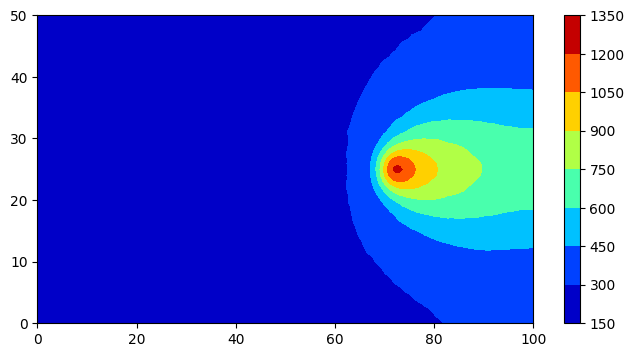

Reading Mesh.msh
Number of nodes in the mesh: 917
Number of triangles in the mesh: 1730

Newton Raphson Iteration 1
Norm of delta_t is 594.6176112982149
Newton Raphson Iteration 2
Norm of delta_t is 146.62511992020276
Newton Raphson Iteration 3
Norm of delta_t is 38.17021372506943
Newton Raphson Iteration 4
Norm of delta_t is 10.500335925002142
Newton Raphson Iteration 5
Norm of delta_t is 2.9674628839886967
Newton Raphson Iteration 6
Norm of delta_t is 0.8541074796322865
Newton Raphson Iteration 7
Norm of delta_t is 0.24865046901981633
Newton Raphson Iteration 8
Norm of delta_t is 0.07296862244905629
Newton Raphson Iteration 9
Norm of delta_t is 0.021536140875331216
Newton Raphson Iteration 10
Norm of delta_t is 0.006383518633449791
Newton Raphson Iteration 11
Norm of delta_t is 0.0018983396632527522
Newton Raphson Iteration 12
Norm of delta_t is 0.0005659720471421958
Newton Raphson Iteration 13
Norm of delta_t is 0.0001690790771403849
Newton Raphson Iteration 14
Norm of delta_t is 5.

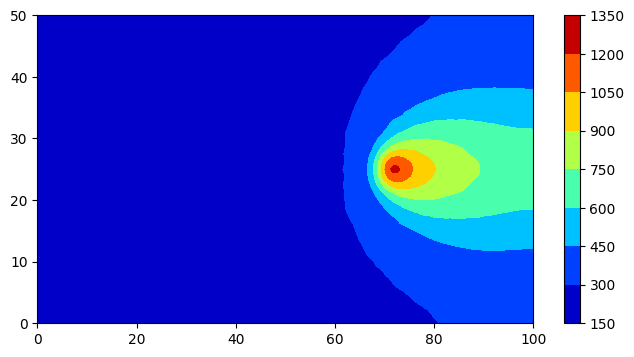

Reading Mesh.msh
Number of nodes in the mesh: 913
Number of triangles in the mesh: 1722

Newton Raphson Iteration 1
Norm of delta_t is 576.4151687990769
Newton Raphson Iteration 2
Norm of delta_t is 143.22152396165382
Newton Raphson Iteration 3
Norm of delta_t is 37.47027758000183
Newton Raphson Iteration 4
Norm of delta_t is 10.332937156752482
Newton Raphson Iteration 5
Norm of delta_t is 2.923378222015812
Newton Raphson Iteration 6
Norm of delta_t is 0.8419592936233511
Newton Raphson Iteration 7
Norm of delta_t is 0.24523875772165707
Newton Raphson Iteration 8
Norm of delta_t is 0.07200275299630361
Newton Raphson Iteration 9
Norm of delta_t is 0.021261583985381544
Newton Raphson Iteration 10
Norm of delta_t is 0.006305259428502504
Newton Raphson Iteration 11
Norm of delta_t is 0.001875980915571547
Newton Raphson Iteration 12
Norm of delta_t is 0.0005595701642785366
Newton Raphson Iteration 13
Norm of delta_t is 0.00016724220482665158
Newton Raphson Iteration 14
Norm of delta_t is 5.0

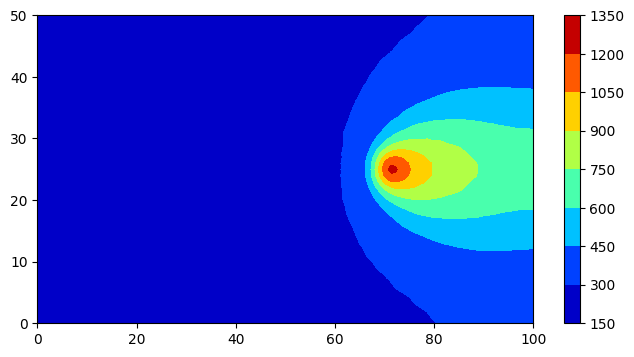

Reading Mesh.msh
Number of nodes in the mesh: 913
Number of triangles in the mesh: 1722

Newton Raphson Iteration 1
Norm of delta_t is 585.2817522775637
Newton Raphson Iteration 2
Norm of delta_t is 143.9186606608292
Newton Raphson Iteration 3
Norm of delta_t is 37.41434195433038
Newton Raphson Iteration 4
Norm of delta_t is 10.290715506523135
Newton Raphson Iteration 5
Norm of delta_t is 2.9092143942235453
Newton Raphson Iteration 6
Norm of delta_t is 0.8378063087740967
Newton Raphson Iteration 7
Norm of delta_t is 0.24405565672435128
Newton Raphson Iteration 8
Norm of delta_t is 0.0716654896530182
Newton Raphson Iteration 9
Norm of delta_t is 0.02116467917144231
Newton Raphson Iteration 10
Norm of delta_t is 0.006277186722000946
Newton Raphson Iteration 11
Norm of delta_t is 0.0018677946850344585
Newton Raphson Iteration 12
Norm of delta_t is 0.0005571716251350759
Newton Raphson Iteration 13
Norm of delta_t is 0.0001665371912314896
Newton Raphson Iteration 14
Norm of delta_t is 4.985

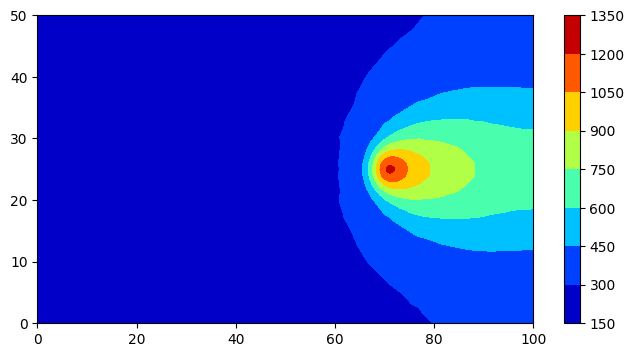

Reading Mesh.msh
Number of nodes in the mesh: 920
Number of triangles in the mesh: 1736

Newton Raphson Iteration 1
Norm of delta_t is 580.9915792690875
Newton Raphson Iteration 2
Norm of delta_t is 143.504856336224
Newton Raphson Iteration 3
Norm of delta_t is 37.43357273319126
Newton Raphson Iteration 4
Norm of delta_t is 10.319474908483182
Newton Raphson Iteration 5
Norm of delta_t is 2.921821594611408
Newton Raphson Iteration 6
Norm of delta_t is 0.8423177110934915
Newton Raphson Iteration 7
Norm of delta_t is 0.2455547752369104
Newton Raphson Iteration 8
Norm of delta_t is 0.07214682086282238
Newton Raphson Iteration 9
Norm of delta_t is 0.021316427208282737
Newton Raphson Iteration 10
Norm of delta_t is 0.006324514388758746
Newton Raphson Iteration 11
Norm of delta_t is 0.0018824537989822303
Newton Raphson Iteration 12
Norm of delta_t is 0.000561690901961853
Newton Raphson Iteration 13
Norm of delta_t is 0.00016792586675064638
Newton Raphson Iteration 14
Norm of delta_t is 5.0281

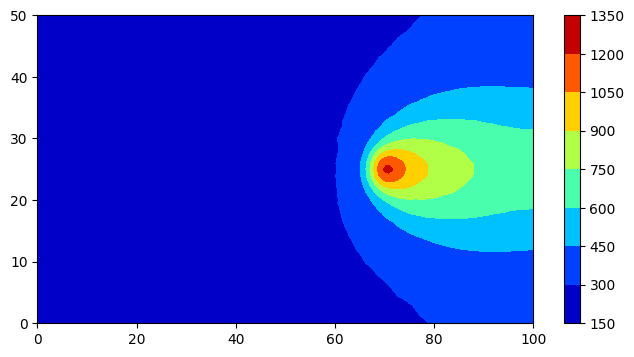

Reading Mesh.msh
Number of nodes in the mesh: 920
Number of triangles in the mesh: 1736

Newton Raphson Iteration 1
Norm of delta_t is 583.1280382732219
Newton Raphson Iteration 2
Norm of delta_t is 144.1809632639997
Newton Raphson Iteration 3
Norm of delta_t is 37.61217725098362
Newton Raphson Iteration 4
Norm of delta_t is 10.36620126940795
Newton Raphson Iteration 5
Norm of delta_t is 2.934393917998402
Newton Raphson Iteration 6
Norm of delta_t is 0.8458328860930806
Newton Raphson Iteration 7
Norm of delta_t is 0.24656483106017346
Newton Raphson Iteration 8
Norm of delta_t is 0.07244222156025118
Newton Raphson Iteration 9
Norm of delta_t is 0.021403807872369198
Newton Raphson Iteration 10
Norm of delta_t is 0.006350568855639975
Newton Raphson Iteration 11
Norm of delta_t is 0.0018902701169335695
Newton Raphson Iteration 12
Norm of delta_t is 0.000564047534020403
Newton Raphson Iteration 13
Norm of delta_t is 0.00016863940079898045
Newton Raphson Iteration 14
Norm of delta_t is 5.049

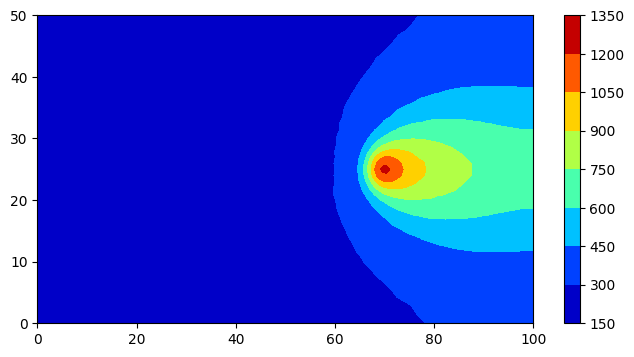

Reading Mesh.msh
Number of nodes in the mesh: 908
Number of triangles in the mesh: 1712

Newton Raphson Iteration 1
Norm of delta_t is 582.7627067648727
Newton Raphson Iteration 2
Norm of delta_t is 143.70344488777198
Newton Raphson Iteration 3
Norm of delta_t is 37.44677815761146
Newton Raphson Iteration 4
Norm of delta_t is 10.313410656509785
Newton Raphson Iteration 5
Norm of delta_t is 2.9176174329311126
Newton Raphson Iteration 6
Norm of delta_t is 0.8404780404973505
Newton Raphson Iteration 7
Norm of delta_t is 0.24485605129743895
Newton Raphson Iteration 8
Norm of delta_t is 0.07189915951582738
Newton Raphson Iteration 9
Norm of delta_t is 0.02123224022403346
Newton Raphson Iteration 10
Norm of delta_t is 0.006296708507749164
Newton Raphson Iteration 11
Norm of delta_t is 0.0018734626310896517
Newton Raphson Iteration 12
Norm of delta_t is 0.000558830439268999
Newton Raphson Iteration 13
Norm of delta_t is 0.0001670273576790749
Newton Raphson Iteration 14
Norm of delta_t is 5.00

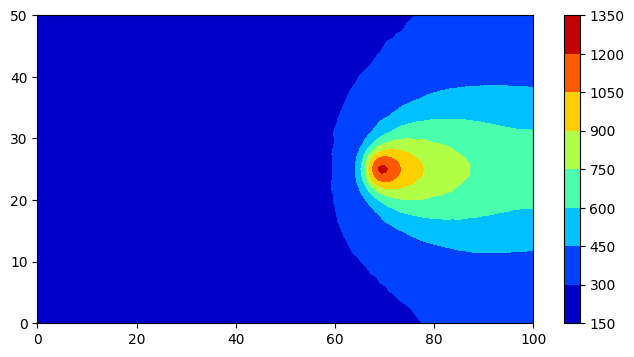

Reading Mesh.msh
Number of nodes in the mesh: 921
Number of triangles in the mesh: 1738

Newton Raphson Iteration 1
Norm of delta_t is 595.068656551781
Newton Raphson Iteration 2
Norm of delta_t is 146.67756651703576
Newton Raphson Iteration 3
Norm of delta_t is 38.19000067576395
Newton Raphson Iteration 4
Norm of delta_t is 10.50887654079116
Newton Raphson Iteration 5
Norm of delta_t is 2.9708603424300795
Newton Raphson Iteration 6
Norm of delta_t is 0.8553751749574683
Newton Raphson Iteration 7
Norm of delta_t is 0.24910628251182057
Newton Raphson Iteration 8
Norm of delta_t is 0.07312886289912807
Newton Raphson Iteration 9
Norm of delta_t is 0.02159161526219647
Newton Raphson Iteration 10
Norm of delta_t is 0.006402502924273855
Newton Raphson Iteration 11
Norm of delta_t is 0.0019047755741065722
Newton Raphson Iteration 12
Norm of delta_t is 0.0005681364468086141
Newton Raphson Iteration 13
Norm of delta_t is 0.00016980184972869374
Newton Raphson Iteration 14
Norm of delta_t is 5.08

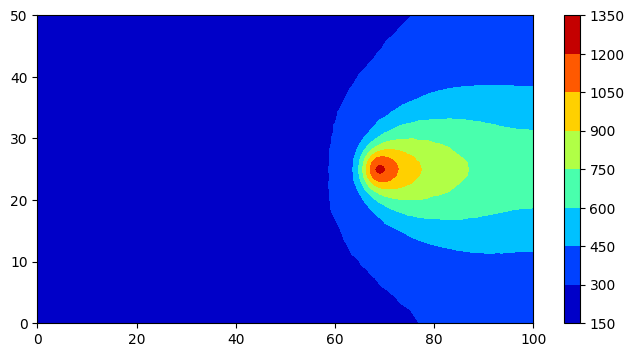

Reading Mesh.msh
Number of nodes in the mesh: 938
Number of triangles in the mesh: 1772

Newton Raphson Iteration 1
Norm of delta_t is 581.3812266427615
Newton Raphson Iteration 2
Norm of delta_t is 143.38667713466305
Newton Raphson Iteration 3
Norm of delta_t is 37.364523720471986
Newton Raphson Iteration 4
Norm of delta_t is 10.292594098331946
Newton Raphson Iteration 5
Norm of delta_t is 2.9126511675219113
Newton Raphson Iteration 6
Norm of delta_t is 0.8394098807946948
Newton Raphson Iteration 7
Norm of delta_t is 0.24466988553601002
Newton Raphson Iteration 8
Norm of delta_t is 0.07188431139270365
Newton Raphson Iteration 9
Norm of delta_t is 0.021239887026774904
Newton Raphson Iteration 10
Norm of delta_t is 0.006302490434973451
Newton Raphson Iteration 11
Norm of delta_t is 0.0018761874278169625
Newton Raphson Iteration 12
Norm of delta_t is 0.0005599266321322291
Newton Raphson Iteration 13
Norm of delta_t is 0.00016743441091204205
Newton Raphson Iteration 14
Norm of delta_t is 

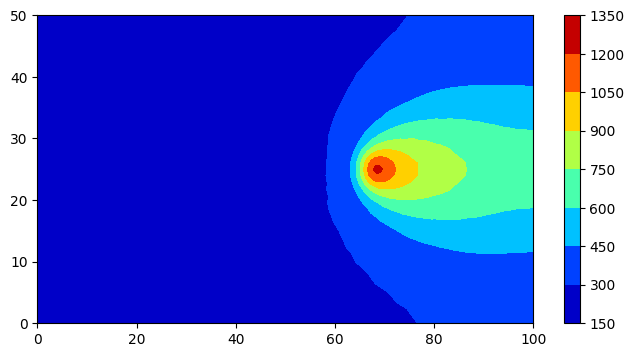

Reading Mesh.msh
Number of nodes in the mesh: 921
Number of triangles in the mesh: 1738

Newton Raphson Iteration 1
Norm of delta_t is 585.2598434050896
Newton Raphson Iteration 2
Norm of delta_t is 143.949603208432
Newton Raphson Iteration 3
Norm of delta_t is 37.416969536424425
Newton Raphson Iteration 4
Norm of delta_t is 10.290568512863556
Newton Raphson Iteration 5
Norm of delta_t is 2.9092366830148624
Newton Raphson Iteration 6
Norm of delta_t is 0.8379035722939419
Newton Raphson Iteration 7
Norm of delta_t is 0.24412565065467612
Newton Raphson Iteration 8
Norm of delta_t is 0.07170134788495308
Newton Raphson Iteration 9
Norm of delta_t is 0.02118041772035337
Newton Raphson Iteration 10
Norm of delta_t is 0.00628351610564503
Newton Raphson Iteration 11
Norm of delta_t is 0.001870202824608111
Newton Raphson Iteration 12
Norm of delta_t is 0.0005580538158862139
Newton Raphson Iteration 13
Norm of delta_t is 0.000166851669262968
Newton Raphson Iteration 14
Norm of delta_t is 4.99661

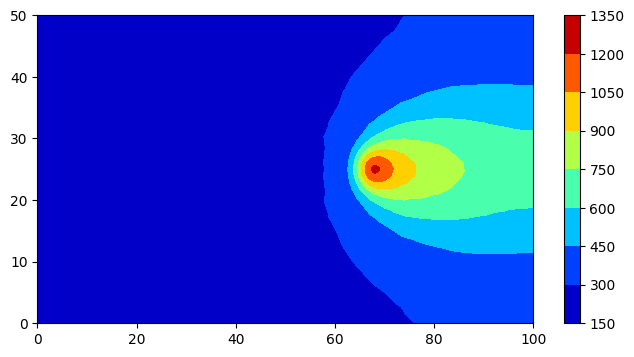

Reading Mesh.msh
Number of nodes in the mesh: 941
Number of triangles in the mesh: 1778

Newton Raphson Iteration 1
Norm of delta_t is 586.3281596398859
Newton Raphson Iteration 2
Norm of delta_t is 144.7689689857818
Newton Raphson Iteration 3
Norm of delta_t is 37.727013020897715
Newton Raphson Iteration 4
Norm of delta_t is 10.389603080389486
Newton Raphson Iteration 5
Norm of delta_t is 2.9396360443001632
Newton Raphson Iteration 6
Norm of delta_t is 0.847183955602362
Newton Raphson Iteration 7
Norm of delta_t is 0.2469629075341428
Newton Raphson Iteration 8
Norm of delta_t is 0.07257006617944567
Newton Raphson Iteration 9
Norm of delta_t is 0.021446488832224837
Newton Raphson Iteration 10
Norm of delta_t is 0.00636496271011405
Newton Raphson Iteration 11
Norm of delta_t is 0.0018951093056206708
Newton Raphson Iteration 12
Norm of delta_t is 0.0005656616470097138
Newton Raphson Iteration 13
Norm of delta_t is 0.00016917301709322332
Newton Raphson Iteration 14
Norm of delta_t is 5.06

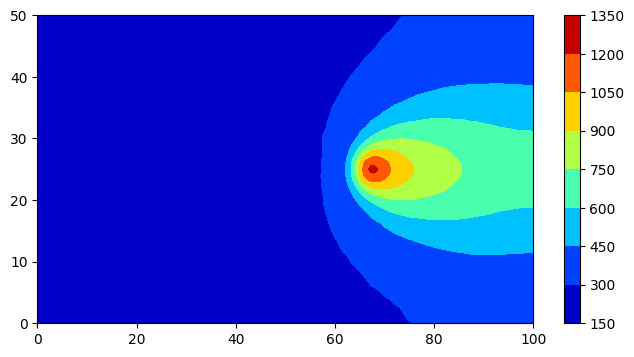

Reading Mesh.msh
Number of nodes in the mesh: 911
Number of triangles in the mesh: 1718

Newton Raphson Iteration 1
Norm of delta_t is 581.347820594697
Newton Raphson Iteration 2
Norm of delta_t is 143.3724411337681
Newton Raphson Iteration 3
Norm of delta_t is 37.336137517806954
Newton Raphson Iteration 4
Norm of delta_t is 10.279515463066584
Newton Raphson Iteration 5
Norm of delta_t is 2.9079735511202793
Newton Raphson Iteration 6
Norm of delta_t is 0.837849300229159
Newton Raphson Iteration 7
Norm of delta_t is 0.24415292034576716
Newton Raphson Iteration 8
Norm of delta_t is 0.07171124837968468
Newton Raphson Iteration 9
Norm of delta_t is 0.02118150124186731
Newton Raphson Iteration 10
Norm of delta_t is 0.006282795254708321
Newton Raphson Iteration 11
Norm of delta_t is 0.0018695868776741685
Newton Raphson Iteration 12
Norm of delta_t is 0.0005577365085106725
Newton Raphson Iteration 13
Norm of delta_t is 0.00016671572964494682
Newton Raphson Iteration 14
Norm of delta_t is 4.99

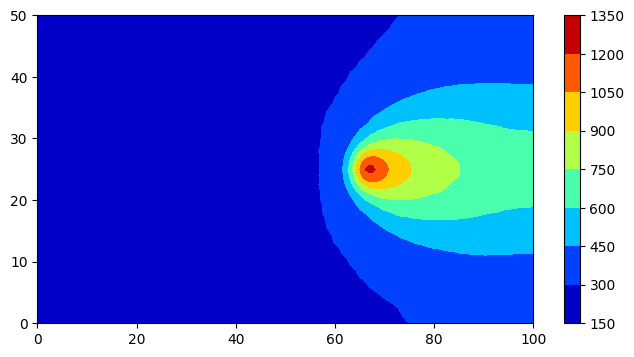

Reading Mesh.msh
Number of nodes in the mesh: 918
Number of triangles in the mesh: 1732

Newton Raphson Iteration 1
Norm of delta_t is 582.7161412267409
Newton Raphson Iteration 2
Norm of delta_t is 143.88739302409323
Newton Raphson Iteration 3
Norm of delta_t is 37.51874295112437
Newton Raphson Iteration 4
Norm of delta_t is 10.338304274399562
Newton Raphson Iteration 5
Norm of delta_t is 2.9258893120404346
Newton Raphson Iteration 6
Norm of delta_t is 0.8431869907993252
Newton Raphson Iteration 7
Norm of delta_t is 0.245737473343295
Newton Raphson Iteration 8
Norm of delta_t is 0.07218468438191226
Newton Raphson Iteration 9
Norm of delta_t is 0.0213242913074812
Newton Raphson Iteration 10
Norm of delta_t is 0.006326233410629576
Newton Raphson Iteration 11
Norm of delta_t is 0.0018828843710219539
Newton Raphson Iteration 12
Norm of delta_t is 0.0005618227754565926
Newton Raphson Iteration 13
Norm of delta_t is 0.00016797371169392108
Newton Raphson Iteration 14
Norm of delta_t is 5.030

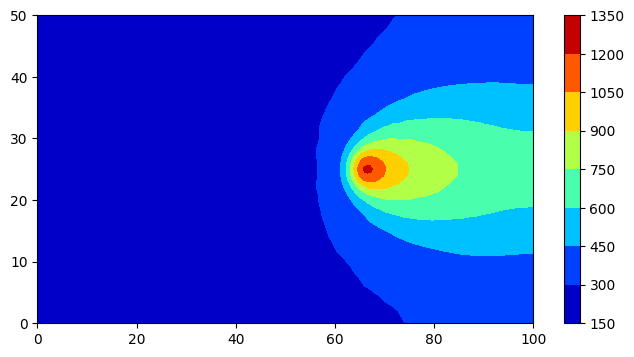

Reading Mesh.msh
Number of nodes in the mesh: 930
Number of triangles in the mesh: 1756

Newton Raphson Iteration 1
Norm of delta_t is 584.495704674843
Newton Raphson Iteration 2
Norm of delta_t is 143.76260571989175
Newton Raphson Iteration 3
Norm of delta_t is 37.41191696833571
Newton Raphson Iteration 4
Norm of delta_t is 10.299368931592415
Newton Raphson Iteration 5
Norm of delta_t is 2.9136397253557345
Newton Raphson Iteration 6
Norm of delta_t is 0.8394713200485286
Newton Raphson Iteration 7
Norm of delta_t is 0.24461605877357753
Newton Raphson Iteration 8
Norm of delta_t is 0.07184485170222435
Newton Raphson Iteration 9
Norm of delta_t is 0.021220763161676086
Newton Raphson Iteration 10
Norm of delta_t is 0.006294570402996523
Newton Raphson Iteration 11
Norm of delta_t is 0.0018731806159628832
Newton Raphson Iteration 12
Norm of delta_t is 0.0005588474788326632
Newton Raphson Iteration 13
Norm of delta_t is 0.00016706204991838794
Newton Raphson Iteration 14
Norm of delta_t is 5.

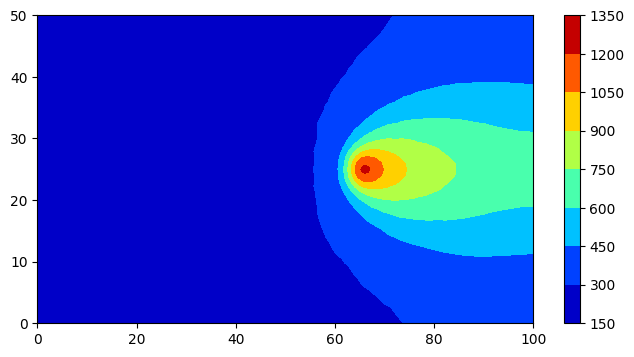

Reading Mesh.msh
Number of nodes in the mesh: 914
Number of triangles in the mesh: 1724

Newton Raphson Iteration 1
Norm of delta_t is 579.6864402581863
Newton Raphson Iteration 2
Norm of delta_t is 143.15631157024393
Newton Raphson Iteration 3
Norm of delta_t is 37.33473841974774
Newton Raphson Iteration 4
Norm of delta_t is 10.289943507943901
Newton Raphson Iteration 5
Norm of delta_t is 2.9129016251842765
Newton Raphson Iteration 6
Norm of delta_t is 0.8396608983761228
Newton Raphson Iteration 7
Norm of delta_t is 0.24477360759710412
Newton Raphson Iteration 8
Norm of delta_t is 0.07191956218375302
Newton Raphson Iteration 9
Norm of delta_t is 0.02125087213407734
Newton Raphson Iteration 10
Norm of delta_t is 0.00630575452092518
Newton Raphson Iteration 11
Norm of delta_t is 0.0018771305937275045
Newton Raphson Iteration 12
Norm of delta_t is 0.000560195057073144
Newton Raphson Iteration 13
Norm of delta_t is 0.00016751038631196647
Newton Raphson Iteration 14
Norm of delta_t is 5.01

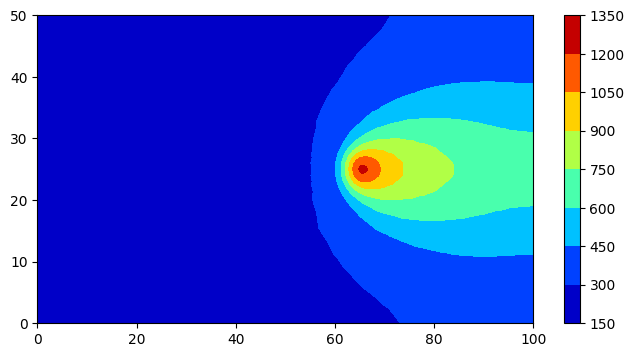

Reading Mesh.msh
Number of nodes in the mesh: 917
Number of triangles in the mesh: 1730

Newton Raphson Iteration 1
Norm of delta_t is 578.24319662752
Newton Raphson Iteration 2
Norm of delta_t is 143.0549199709395
Newton Raphson Iteration 3
Norm of delta_t is 37.34555111660973
Newton Raphson Iteration 4
Norm of delta_t is 10.296364868623842
Newton Raphson Iteration 5
Norm of delta_t is 2.9149993912703143
Newton Raphson Iteration 6
Norm of delta_t is 0.8402818737492088
Newton Raphson Iteration 7
Norm of delta_t is 0.24495659403674205
Newton Raphson Iteration 8
Norm of delta_t is 0.07197477494735013
Newton Raphson Iteration 9
Norm of delta_t is 0.021268021559510755
Newton Raphson Iteration 10
Norm of delta_t is 0.006311208367623223
Newton Raphson Iteration 11
Norm of delta_t is 0.0018788910432177776
Newton Raphson Iteration 12
Norm of delta_t is 0.0005607673182543918
Newton Raphson Iteration 13
Norm of delta_t is 0.0001676966738794176
Newton Raphson Iteration 14
Norm of delta_t is 5.022

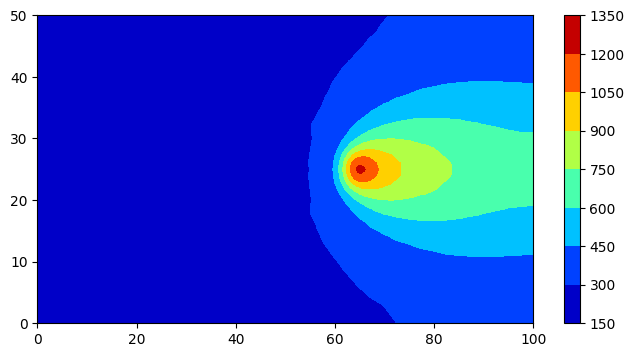

Reading Mesh.msh
Number of nodes in the mesh: 916
Number of triangles in the mesh: 1728

Newton Raphson Iteration 1
Norm of delta_t is 583.6602912162456
Newton Raphson Iteration 2
Norm of delta_t is 144.5231887003778
Newton Raphson Iteration 3
Norm of delta_t is 37.72948600715017
Newton Raphson Iteration 4
Norm of delta_t is 10.402361075522549
Newton Raphson Iteration 5
Norm of delta_t is 2.9456265413463476
Newton Raphson Iteration 6
Norm of delta_t is 0.8493906875959278
Newton Raphson Iteration 7
Norm of delta_t is 0.24770482189964854
Newton Raphson Iteration 8
Norm of delta_t is 0.07280852460233489
Newton Raphson Iteration 9
Norm of delta_t is 0.02152124393313191
Newton Raphson Iteration 10
Norm of delta_t is 0.0063880578051137
Newton Raphson Iteration 11
Norm of delta_t is 0.0019021824594436293
Newton Raphson Iteration 12
Norm of delta_t is 0.000567816854325112
Newton Raphson Iteration 13
Norm of delta_t is 0.00016982787374193533
Newton Raphson Iteration 14
Norm of delta_t is 5.0872

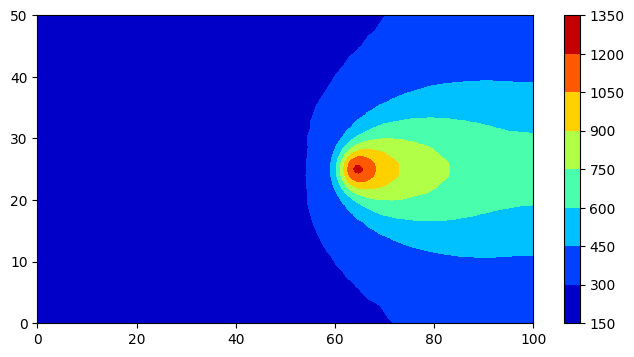

Reading Mesh.msh
Number of nodes in the mesh: 912
Number of triangles in the mesh: 1720

Newton Raphson Iteration 1
Norm of delta_t is 582.1718022986745
Newton Raphson Iteration 2
Norm of delta_t is 143.52662424662805
Newton Raphson Iteration 3
Norm of delta_t is 37.38534051037207
Newton Raphson Iteration 4
Norm of delta_t is 10.297368675812884
Newton Raphson Iteration 5
Norm of delta_t is 2.914280568991126
Newton Raphson Iteration 6
Norm of delta_t is 0.8399710358466531
Newton Raphson Iteration 7
Norm of delta_t is 0.2448391073626982
Newton Raphson Iteration 8
Norm of delta_t is 0.07192753670145911
Newton Raphson Iteration 9
Norm of delta_t is 0.02124861186885388
Newton Raphson Iteration 10
Norm of delta_t is 0.006303430713535094
Newton Raphson Iteration 11
Norm of delta_t is 0.0018759012508498872
Newton Raphson Iteration 12
Norm of delta_t is 0.0005596644001413714
Newton Raphson Iteration 13
Norm of delta_t is 0.0001673039913965927
Newton Raphson Iteration 14
Norm of delta_t is 5.009

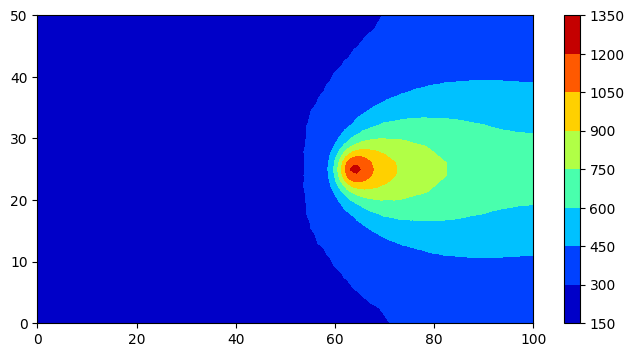

Reading Mesh.msh
Number of nodes in the mesh: 928
Number of triangles in the mesh: 1752

Newton Raphson Iteration 1
Norm of delta_t is 584.9268188287049
Newton Raphson Iteration 2
Norm of delta_t is 144.36805674700705
Newton Raphson Iteration 3
Norm of delta_t is 37.63570992934207
Newton Raphson Iteration 4
Norm of delta_t is 10.370892561985256
Newton Raphson Iteration 5
Norm of delta_t is 2.93561060344304
Newton Raphson Iteration 6
Norm of delta_t is 0.8461534719108095
Newton Raphson Iteration 7
Norm of delta_t is 0.24664519531819312
Newton Raphson Iteration 8
Norm of delta_t is 0.07246181725338778
Newton Raphson Iteration 9
Norm of delta_t is 0.021408690548609433
Newton Raphson Iteration 10
Norm of delta_t is 0.00635189978275366
Newton Raphson Iteration 11
Norm of delta_t is 0.0018906867229177104
Newton Raphson Iteration 12
Norm of delta_t is 0.0005641956111336989
Newton Raphson Iteration 13
Norm of delta_t is 0.00016869600263244526
Newton Raphson Iteration 14
Norm of delta_t is 5.05

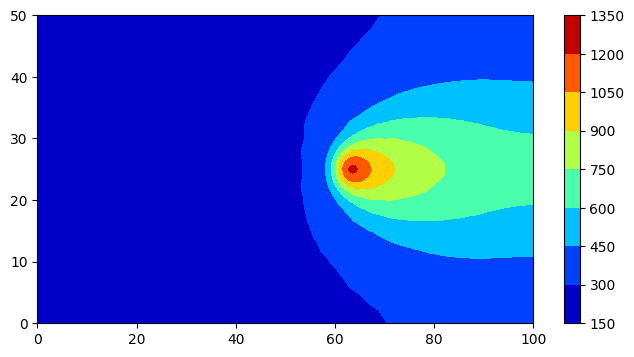

Reading Mesh.msh
Number of nodes in the mesh: 933
Number of triangles in the mesh: 1762

Newton Raphson Iteration 1
Norm of delta_t is 604.4327982190074
Newton Raphson Iteration 2
Norm of delta_t is 148.6331796200684
Newton Raphson Iteration 3
Norm of delta_t is 38.65869264516503
Newton Raphson Iteration 4
Norm of delta_t is 10.635813349059854
Newton Raphson Iteration 5
Norm of delta_t is 3.007496858276157
Newton Raphson Iteration 6
Norm of delta_t is 0.8662839934388404
Newton Raphson Iteration 7
Norm of delta_t is 0.25240272588610385
Newton Raphson Iteration 8
Norm of delta_t is 0.07413265045737831
Newton Raphson Iteration 9
Norm of delta_t is 0.02189856085140562
Newton Raphson Iteration 10
Norm of delta_t is 0.006496594615258726
Newton Raphson Iteration 11
Norm of delta_t is 0.0019336621106531202
Newton Raphson Iteration 12
Norm of delta_t is 0.0005770132633487818
Newton Raphson Iteration 13
Norm of delta_t is 0.00017253142384625924
Newton Raphson Iteration 14
Norm of delta_t is 5.16

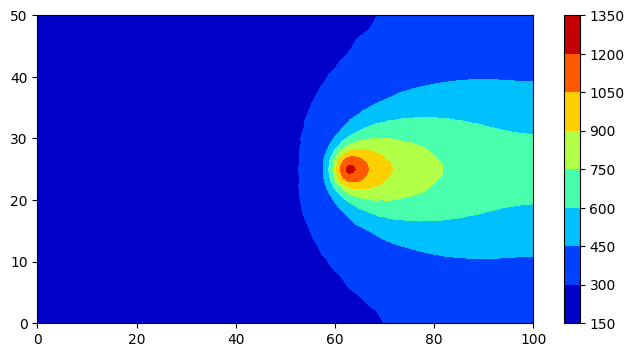

Reading Mesh.msh
Number of nodes in the mesh: 914
Number of triangles in the mesh: 1724

Newton Raphson Iteration 1
Norm of delta_t is 578.3932713939546
Newton Raphson Iteration 2
Norm of delta_t is 142.95839659085843
Newton Raphson Iteration 3
Norm of delta_t is 37.303197458865526
Newton Raphson Iteration 4
Norm of delta_t is 10.28540744332363
Newton Raphson Iteration 5
Norm of delta_t is 2.912581078237035
Newton Raphson Iteration 6
Norm of delta_t is 0.8398009416664026
Newton Raphson Iteration 7
Norm of delta_t is 0.2448701172729623
Newton Raphson Iteration 8
Norm of delta_t is 0.07196131219329098
Newton Raphson Iteration 9
Norm of delta_t is 0.02126655828221329
Newton Raphson Iteration 10
Norm of delta_t is 0.006311301412799301
Newton Raphson Iteration 11
Norm of delta_t is 0.0018790360293725712
Newton Raphson Iteration 12
Norm of delta_t is 0.0005608400961933103
Newton Raphson Iteration 13
Norm of delta_t is 0.00016772701726941312
Newton Raphson Iteration 14
Norm of delta_t is 5.02

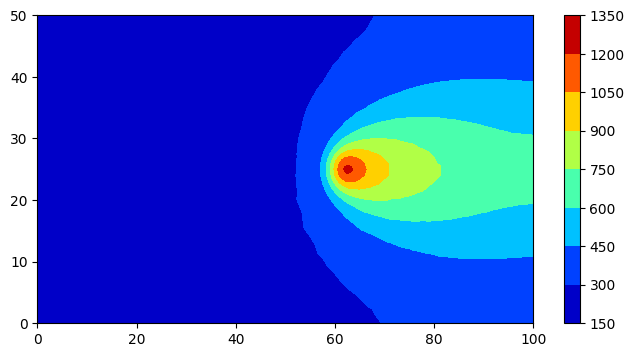

Reading Mesh.msh
Number of nodes in the mesh: 908
Number of triangles in the mesh: 1712

Newton Raphson Iteration 1
Norm of delta_t is 575.9462056975915
Newton Raphson Iteration 2
Norm of delta_t is 142.64542481929482
Newton Raphson Iteration 3
Norm of delta_t is 37.254384484934256
Newton Raphson Iteration 4
Norm of delta_t is 10.27293357696156
Newton Raphson Iteration 5
Norm of delta_t is 2.908633842704742
Newton Raphson Iteration 6
Norm of delta_t is 0.8385261890880944
Newton Raphson Iteration 7
Norm of delta_t is 0.24446968227909194
Newton Raphson Iteration 8
Norm of delta_t is 0.07183889270201528
Newton Raphson Iteration 9
Norm of delta_t is 0.02122985504139927
Newton Raphson Iteration 10
Norm of delta_t is 0.0063004342722331
Newton Raphson Iteration 11
Norm of delta_t is 0.0018758427843521394
Newton Raphson Iteration 12
Norm of delta_t is 0.0005599058121401072
Newton Raphson Iteration 13
Norm of delta_t is 0.00016745427637066627
Newton Raphson Iteration 14
Norm of delta_t is 5.016

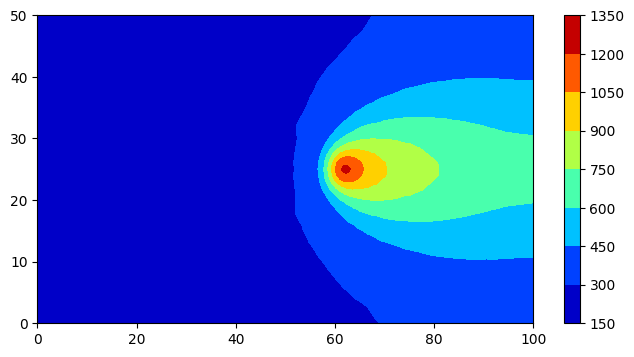

Reading Mesh.msh
Number of nodes in the mesh: 918
Number of triangles in the mesh: 1732

Newton Raphson Iteration 1
Norm of delta_t is 584.707931934219
Newton Raphson Iteration 2
Norm of delta_t is 144.76159104415717
Newton Raphson Iteration 3
Norm of delta_t is 37.77403914844537
Newton Raphson Iteration 4
Norm of delta_t is 10.411080959747851
Newton Raphson Iteration 5
Norm of delta_t is 2.9474830736260333
Newton Raphson Iteration 6
Norm of delta_t is 0.8498250635499629
Newton Raphson Iteration 7
Norm of delta_t is 0.24781382950413225
Newton Raphson Iteration 8
Norm of delta_t is 0.07283716047715022
Newton Raphson Iteration 9
Norm of delta_t is 0.021529072851528937
Newton Raphson Iteration 10
Norm of delta_t is 0.006390302759175304
Newton Raphson Iteration 11
Norm of delta_t is 0.0019028642338872331
Newton Raphson Iteration 12
Norm of delta_t is 0.0005680363758498895
Newton Raphson Iteration 13
Norm of delta_t is 0.0001699020593548201
Newton Raphson Iteration 14
Norm of delta_t is 5.0

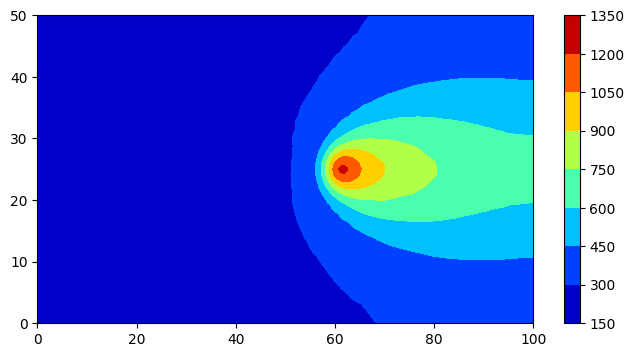

Reading Mesh.msh
Number of nodes in the mesh: 913
Number of triangles in the mesh: 1722

Newton Raphson Iteration 1
Norm of delta_t is 582.1538529361801
Newton Raphson Iteration 2
Norm of delta_t is 143.60272704812877
Newton Raphson Iteration 3
Norm of delta_t is 37.40812945605799
Newton Raphson Iteration 4
Norm of delta_t is 10.303486006779899
Newton Raphson Iteration 5
Norm of delta_t is 2.916038162615676
Newton Raphson Iteration 6
Norm of delta_t is 0.8405323614531046
Newton Raphson Iteration 7
Norm of delta_t is 0.2450305096668735
Newton Raphson Iteration 8
Norm of delta_t is 0.07199429783342944
Newton Raphson Iteration 9
Norm of delta_t is 0.021271893687611274
Newton Raphson Iteration 10
Norm of delta_t is 0.006311479637931319
Newton Raphson Iteration 11
Norm of delta_t is 0.0018786545400245915
Newton Raphson Iteration 12
Norm of delta_t is 0.0005605967248533375
Newton Raphson Iteration 13
Norm of delta_t is 0.00016761687194092684
Newton Raphson Iteration 14
Norm of delta_t is 5.0

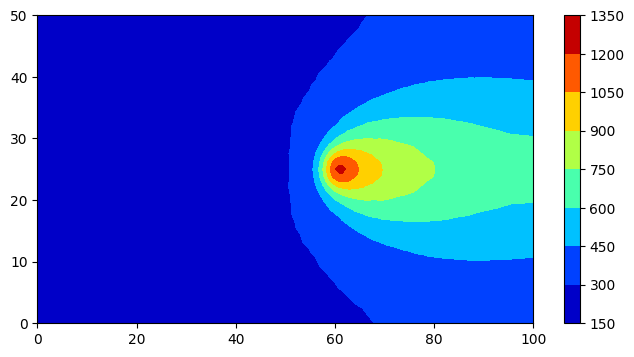

In [10]:
filename = f"rectange.geo"
nodecoords_prev,ele_con_prev = createMesh(geo_file=filename,meshFactorForEntireSurface = 3,meshFactorForAdaptiveSurface=1,xSource=100,ySource=25,isMeshRectangle=True)
deltaT = .25
L = 20
v0 = 2
steps = int(L/deltaT)
Temperatures = (273+20)*np.ones(nodecoords.shape[0])
TempArray = []
nodeArray = []
for step in range(1,steps+1):
    nodecoords,ele_con = createMesh(geo_file=filename,meshFactorForEntireSurface = 3,meshFactorForAdaptiveSurface=1,xSource=100-v0*step*deltaT,ySource=25,isMeshRectangle=True)
    temp_prev_time = interpolatingTemperature(nodecoords=nodecoords_prev, ele_con=ele_con_prev, coords=nodecoords, values=Temperatures)
    soln1 = FEMwithNR(nodecoords,ele_con,np.array([[100-v0*step*deltaT,25]]))
    Temperatures = soln1.solver(theta_prev_time = temp_prev_time.reshape(-1,1),dt = deltaT,mode = "phase_change",verbose = False).reshape(-1)
    TempArray.append(Temperatures)
    nodeArray.append(nodecoords)
    nodecoords_prev,ele_con_prev = nodecoords,ele_con
    plt.figure(figsize=(8,4))
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],Temperatures,cmap = 'jet')
    plt.colorbar()
    plt.show()

In [15]:
len(TempArray)

80

In [17]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Assuming nodeArray and TempArray are already defined
steps = len(nodeArray)  # or however you define the number of steps

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs like 'XVID'
video_name = 'output_video.mp4'
fps = 30  # Frames per second
frame_size = (800, 400)  # Size of the figure (width, height)
video = cv2.VideoWriter(video_name, fourcc, fps, frame_size)

for step in range(0, steps):
    plt.figure(figsize=(8, 4))
    plt.tricontourf(nodeArray[step][:,0], nodeArray[step][:,1], TempArray[step], 100, cmap='jet')
    plt.colorbar()
    
    # Save the plot to a temporary file
    plt.savefig('temp_plot.png')
    plt.close()

    # Read the saved image
    img = cv2.imread('temp_plot.png')
    
    # Resize the image to match the frame size
    img = cv2.resize(img, frame_size)
    
    # Write the image to the video
    video.write(img)

# Release the VideoWriter object
video.release()
cv2.destroyAllWindows()

print(f"Video saved as {video_name}")

Video saved as output_video.mp4


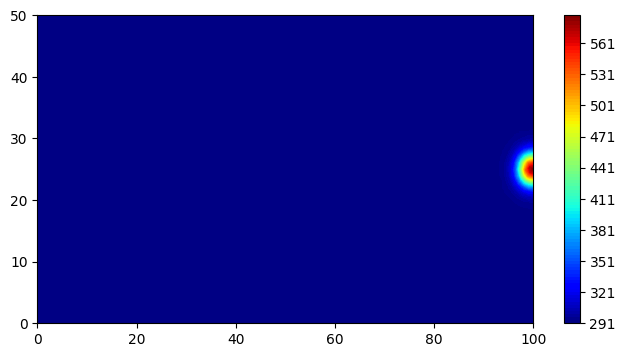

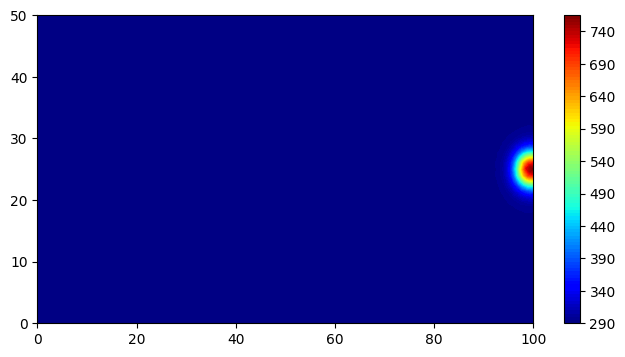

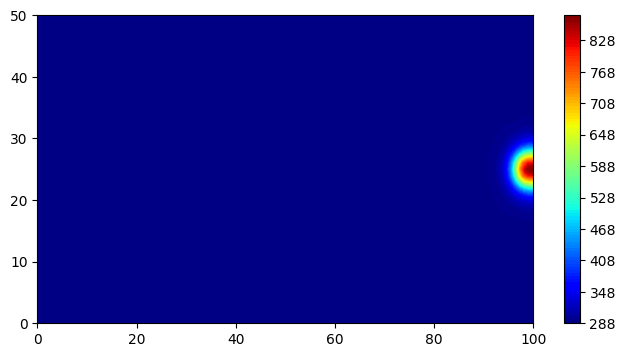

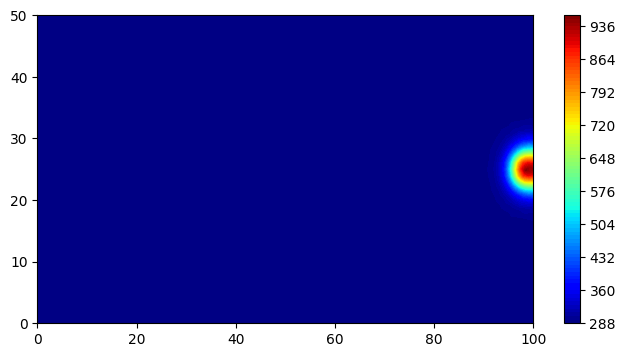

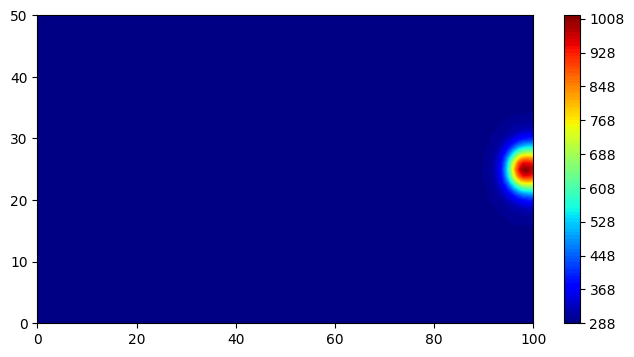

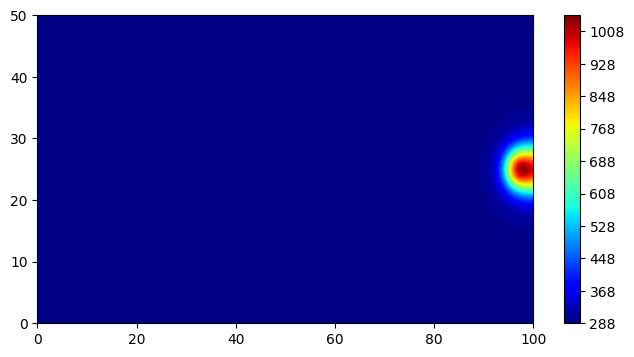

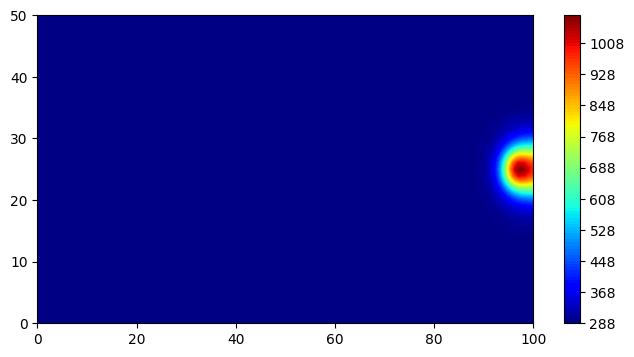

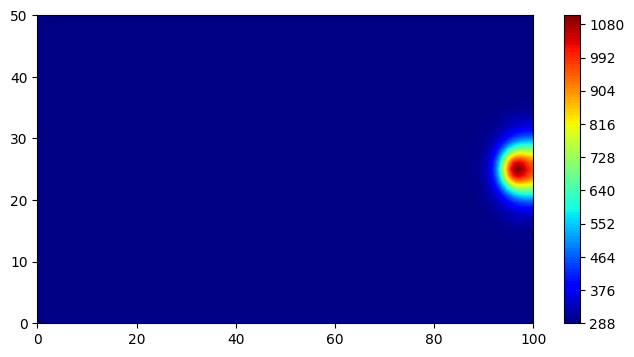

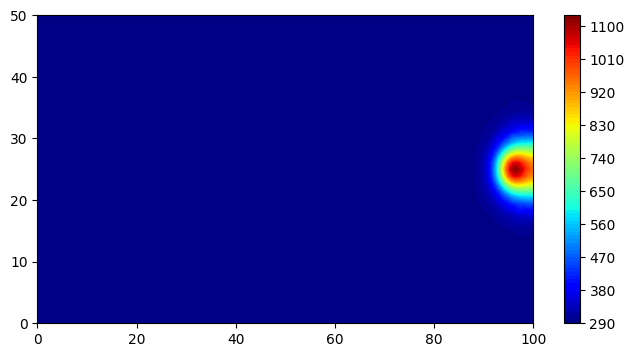

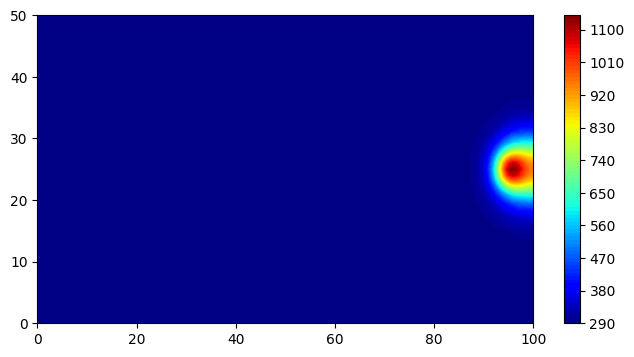

In [16]:
for step in range(0,steps):
    plt.figure(figsize=(8,4))
    plt.tricontourf(nodeArray[step][:,0],nodeArray[step][:,1],TempArray[step],100,cmap = 'jet')
    plt.colorbar()
    plt.show()

In [33]:
# filename = f"rectangle_vary_0.5_1.msh"
# nodecoords,ele_con = read_mesh(filename) #node tags start from 1
# soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))

Reading rectangle_vary_0.5_1.msh
Number of nodes in the mesh: 9806
Number of triangles in the mesh: 19286



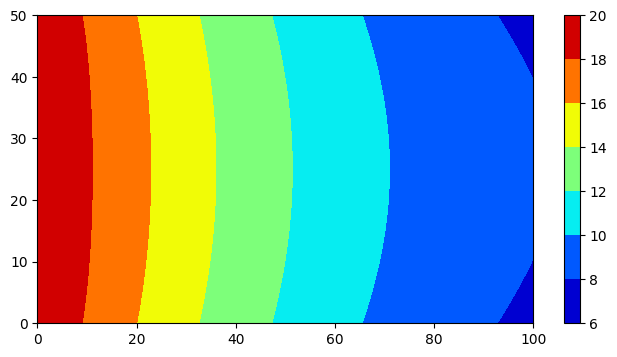

In [36]:
# h,K,G,F,boundary,theta = soln1.fit_ele(mode = "no_source",verbose = False)
# gc.collect()
# plt.figure(figsize=(8,4))
# plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
# plt.colorbar()
# plt.show()

In [ ]:
# print(f"The maximum temperature is {np.max(theta):.2f} C and the minimum temperature is {np.min(theta):.2f} C")

The maximum temperature is 630.49 $^o$C and the minimum temperature is 19.63 K


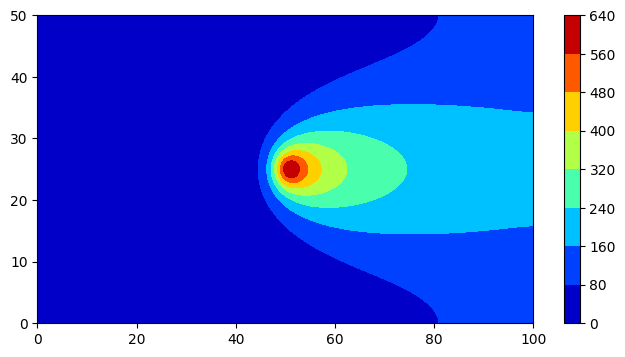

In [37]:
# _,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
# # h,K,G,F,boundary_term,theta
# gc.collect()
# plt.figure(figsize=(8,4))
# plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
# plt.colorbar()
# plt.show()

In [10]:
# print(f"The maximum temperature is {np.max(theta):.2f} K and the minimum temperature is {np.min(theta):.2f} K")

The maximum temperature is 630.49 K and the minimum temperature is 19.63 K


## Validation of picard iteration

In [7]:
def Q(point):
    x = point[0,0] #in mm
    return 15e-3*(x/100)*(1-x/100) ## W/mm^3

def k_T(T):
    # return np.ones_like(T)*110
    return (100+0.004*(T-50-273)**2)*1e-3  ##W/mmK

In [8]:
class Picard_valid:
    def __init__(self,nodecoords,elecon):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
                        
    def fit_ele(self,dt,theta_prev_time = None,theta_prev_pic = None,mode = "linear",scheme = "implicit",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = 0   # W/mm^2
        c = 465 #J/kg.K
        rho = 7e-6 #kg/mm^3

        nodes = self.nodecoords
        ele = self.elecon
        
        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]
        
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K_row,K_col,K_data = [],[],[]
        M_row,M_col,M_data = [],[],[]

        #Parallel processing for matrix computations
        items = [(nodes,elei,theta_prev_time,theta_prev_pic,mode,scheme) for elei in ele]
        st = time.time()
        with Pool(processes = 4) as pool:
            results = pool.map(picard_helper, items)
        if verbose == True:
            print(f"Time for pooling to end {time.time()-st}")

        #Accumulating data collected over multiprocessing
        st = time.time()
        K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data]
        K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data = [flatten(mini) for mini in mega]
        if verbose == True:
            print(f"Time for accumulation of data to end {time.time()-st}")

        #Preparing the matrices for calculations
        st = time.time()
        F= coo_array((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        
        K_sparse = coo_array((K_data,(K_row,K_col)),shape=(nop,nop))
        M_sparse = coo_array((M_data,(M_row,M_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for matrices creation {time.time()-st}")

        #Converting sparse to dense matrix for submatrix extractions
        st = time.time()
        K = K_sparse.toarray()
        M = M_sparse.toarray()

        if verbose == True:
            print(f"Time for sparse to dense conversion {time.time()-st}")
        
        #setting up the right hand side
        T_b = 273+100
        non_bn = np.setdiff1d(np.arange(K.shape[0]),bn)
        rhs = (F+M@theta_prev_time/dt)\
               -T_b*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1)
        
        K_sub = K[np.ix_(non_bn,non_bn)]
        M_sub = M[np.ix_(non_bn,non_bn)]
        rhs_sub = rhs[np.ix_(non_bn,[0])]
        theta_sub = np.linalg.inv(K_sub+M_sub/dt)@(rhs_sub)

        theta = np.zeros((K.shape[0],1))+T_b
        theta[non_bn,:] = theta_sub.reshape(-1,1)
        
        return [M,K,F,theta]

In [9]:
def picard(soln,nodecoords,ele_con,theta_init):
    dt = 1
    times = np.arange(0,10,dt)
    theta_prev_time = theta_init
    
    for t in times:
        e = 1e5
        tolerance = 1e-4
        iter = 0
        theta_prev_pic = theta_prev_time
        while(e>tolerance):
            iter +=1
            M,K,F,theta_new = soln.fit_ele(dt,theta_prev_time = theta_prev_time,theta_prev_pic = theta_prev_pic,mode = "non_linear",scheme = "implicit")
            e = np.linalg.norm(theta_new - theta_prev_pic)
            theta_prev_pic = theta_new
            if t == round(t):
                print(f"Error at {iter} iteration at time {t} is {e:.2E}")
        theta_prev_time = theta_new
        
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten()-273, cmap = 'jet')
    plt.title(f"Converged solution")
    plt.colorbar()
    plt.show()

    return theta_new
        

Reading Square.msh
Number of nodes in the mesh: 791
Number of triangles in the mesh: 1480

Error at 1 iteration at time 0 is 3.05E+02
Error at 2 iteration at time 0 is 5.01E+00
Error at 3 iteration at time 0 is 7.47E-02
Error at 4 iteration at time 0 is 6.96E-04
Error at 5 iteration at time 0 is 4.30E-06
Error at 1 iteration at time 1 is 9.16E+01
Error at 2 iteration at time 1 is 8.25E-01
Error at 3 iteration at time 1 is 5.54E-03
Error at 4 iteration at time 1 is 4.63E-05
Error at 1 iteration at time 2 is 6.48E+01
Error at 2 iteration at time 2 is 3.92E-01
Error at 3 iteration at time 2 is 2.48E-03
Error at 4 iteration at time 2 is 2.82E-05
Error at 1 iteration at time 3 is 5.32E+01
Error at 2 iteration at time 3 is 2.40E-01
Error at 3 iteration at time 3 is 1.63E-03
Error at 4 iteration at time 3 is 1.63E-05
Error at 1 iteration at time 4 is 4.66E+01
Error at 2 iteration at time 4 is 1.69E-01
Error at 3 iteration at time 4 is 1.17E-03
Error at 4 iteration at time 4 is 1.02E-05
Error 

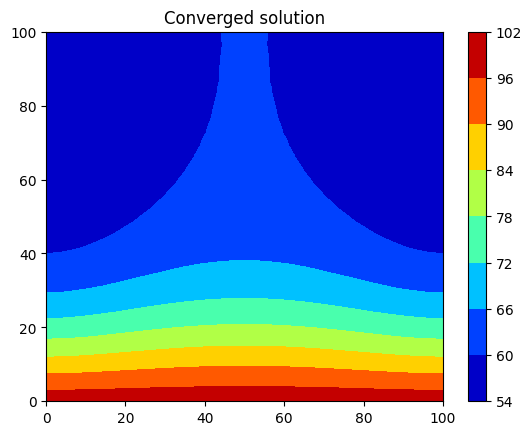

In [12]:
mesh_size_factor = 3
filename = f"Square.msh"
# nodecoords,ele_con = createMesh(geo_file='squareDomain.geo',
#                                 meshFactorForEntireSurface=mesh_size_factor) 
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
soln3 = Picard_valid(nodecoords,ele_con)
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard(soln3,nodecoords,ele_con,theta_init)

In [23]:
mesh_size_factor = 3
filename = f"Square.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
deltaT = 1
T = 10
L = 20
v0 = 2
steps = int(T/deltaT)
Temperatures = (273+50)*np.ones((steps+1,nodecoords.shape[0]))
for step in range(1,steps+1):
    soln1 = FEMwithNR(nodecoords,ele_con,np.array([[100-v0*step*deltaT,25]]))
    Temperatures[step,:]= soln1.solver(theta_prev_time = Temperatures[step-1,:].reshape(-1,1),dt = deltaT,mode = "non_linear",verbose = False).reshape(-1)
    # plt.figure(figsize=(6,6))
    # plt.tricontourf(nodecoords[:,0],nodecoords[:,1],Temperatures[step,:]-273,cmap = 'jet')
    # plt.colorbar()
    # plt.show()

Reading Square.msh
Number of nodes in the mesh: 791
Number of triangles in the mesh: 1480

Newton Raphson Iteration 1
Norm of delta_t is 170.06211477394677
Newton Raphson Iteration 2
Norm of delta_t is 2.2705251997370186
Newton Raphson Iteration 3
Norm of delta_t is 0.03509641154445512
Newton Raphson Iteration 4
Norm of delta_t is 0.0004141981223068436
Newton Raphson Iteration 5
Norm of delta_t is 4.047536049615205e-06
Newton Raphson Iteration 6
Norm of delta_t is 3.387279955248061e-08
Newton Raphson Iteration 7
Norm of delta_t is 2.4001955329765025e-10
Maximum Teperature is 373.0
Newton Raphson Iteration 1
Norm of delta_t is 91.58982118092423
Newton Raphson Iteration 2
Norm of delta_t is 0.8841048505550119
Newton Raphson Iteration 3
Norm of delta_t is 0.006799716041450678
Newton Raphson Iteration 4
Norm of delta_t is 4.80497343014167e-05
Newton Raphson Iteration 5
Norm of delta_t is 6.98174247390813e-07
Newton Raphson Iteration 6
Norm of delta_t is 5.7821956446091e-09
Maximum Teperatu

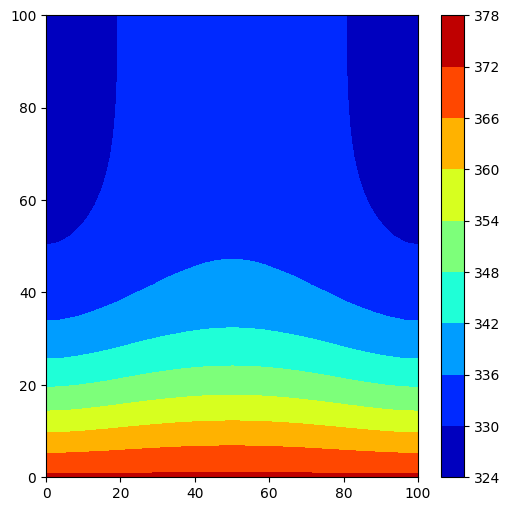

In [24]:
plt.figure(figsize=(6,6))  
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],Temperatures[-1,:]  ,cmap = 'jet')
plt.colorbar()
plt.show()

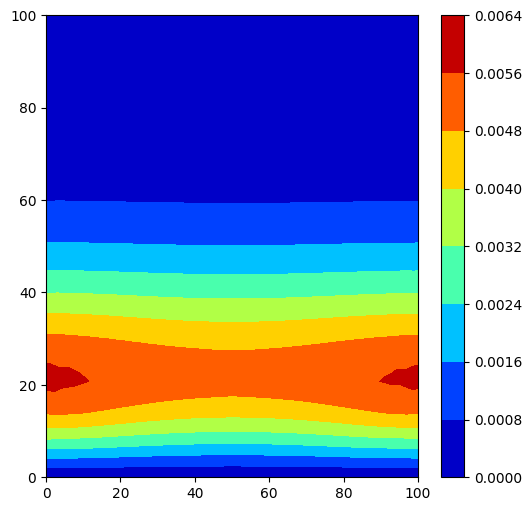

In [25]:
plt.figure(figsize=(6,6))  
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_final.reshape(-1)-Temperatures[-1,:]  ,cmap = 'jet')
plt.colorbar()
plt.show()

In [26]:
Ta = Temperatures[step,[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]]-273
Tb = Temperatures[step,[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]]-273
print(f"The temperature at node a is {Ta[0]:.5f}K and at node b is {Tb[0]:.5f}K")

The temperature at node a is 54.75754K and at node b is 54.75825K


In [27]:
Ta = theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273
Tb = theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273
print(f"The temperature at node a is {Ta[0]:.2f}K and at node b is {Tb[0]:.2f}K")

The temperature at node a is 54.76K and at node b is 54.76K


## Mesh convergence

In [16]:
# Finding mesh size factor for the adaptive mesh part
mesh_size_factor = 3
areaOfPatchRegion = 12 * 12
area_overall = 100*50
meshFactorsForPatchSurface = np.arange(0.1,0.2,0.01)
hOfPathArea = []
h = []
for meshFactorForPatchSurface in meshFactorsForPatchSurface:
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                        meshFactorForEntireSurface=mesh_size_factor,
                                        meshFactorForAdaptiveSurface=meshFactorForPatchSurface,
                                        xSource=50,
                                        ySource=25,
                                        isMeshRectangle=True
                                    )
    nodesInPatchArea = np.where((np.max(nodecoords[ele_con-1][:,:,0],axis=1)<56)*(np.min(nodecoords[ele_con-1][:,:,0],axis=1)>44)*(np.max(nodecoords[ele_con-1][:,:,1],axis=1)<31)*(np.min(nodecoords[ele_con-1][:,:,1],axis=1)>19))[0]
    hOfPathArea.append((areaOfPatchRegion / len(nodesInPatchArea))**.5)
    h.append((area_overall / len(nodecoords))**.5)
    print(f"h_patch {hOfPathArea[-1]}")
    print(f"h_total {h[-1]}")

Reading Mesh.msh
Number of nodes in the mesh: 15111
Number of triangles in the mesh: 30118

h_patch 0.071156806696482
h_total 0.5752258564403582
Reading Mesh.msh
Number of nodes in the mesh: 12606
Number of triangles in the mesh: 25108

h_patch 0.07832771355170637
h_total 0.6297908559918702
Reading Mesh.msh
Number of nodes in the mesh: 10852
Number of triangles in the mesh: 21600

h_patch 0.08492715754489341
h_total 0.678781675661736
Reading Mesh.msh
Number of nodes in the mesh: 9275
Number of triangles in the mesh: 18446

h_patch 0.09250495460811899
h_total 0.7342230982143523
Reading Mesh.msh
Number of nodes in the mesh: 8088
Number of triangles in the mesh: 16072

h_patch 0.099871774825533
h_total 0.7862568296530488
Reading Mesh.msh
Number of nodes in the mesh: 7136
Number of triangles in the mesh: 14168

h_patch 0.10702347787777115
h_total 0.8370619127280313
Reading Mesh.msh
Number of nodes in the mesh: 6390
Number of triangles in the mesh: 12676

h_patch 0.11417702599266696
h_total

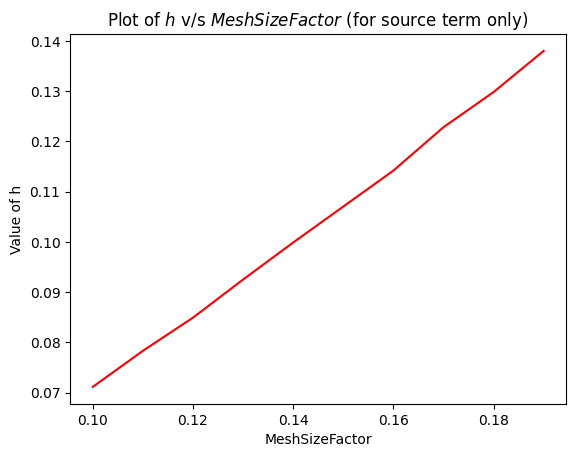

In [17]:
plt.plot(meshFactorsForPatchSurface,hOfPathArea,'r')
plt.xlabel('MeshSizeFactor')
plt.ylabel('Value of h')
plt.title('Plot of $h$ v/s $Mesh Size Factor$ (for source term only)')
plt.show()

In [18]:
print('Value of h for mesh size factor 0.15 is '+str(hOfPathArea[4]))

Value of h for mesh size factor 0.15 is 0.099871774825533


Using Mesh Size Factor for adaptive Surface as 0.14 (whose corresponding vale of h is 0.09250495460811899)

In [19]:
print(hOfPathArea)

[0.071156806696482, 0.07832771355170637, 0.08492715754489341, 0.09250495460811899, 0.099871774825533, 0.10702347787777115, 0.11417702599266696, 0.12280111196910334, 0.12979991081667525, 0.1379857364617018]


1
Reading Mesh.msh
Number of nodes in the mesh: 12958
Number of triangles in the mesh: 25614

5
Reading Mesh.msh
Number of nodes in the mesh: 5948
Number of triangles in the mesh: 11832

10
Reading Mesh.msh
Number of nodes in the mesh: 4753
Number of triangles in the mesh: 9470

15
Reading Mesh.msh
Number of nodes in the mesh: 3580
Number of triangles in the mesh: 7134

20
Reading Mesh.msh
Number of nodes in the mesh: 2229
Number of triangles in the mesh: 4436

25
Reading Mesh.msh
Number of nodes in the mesh: 2214
Number of triangles in the mesh: 4412

30
Reading Mesh.msh
Number of nodes in the mesh: 1177
Number of triangles in the mesh: 2338

35
Reading Mesh.msh
Number of nodes in the mesh: 2796
Number of triangles in the mesh: 5578

40
Reading Mesh.msh
Number of nodes in the mesh: 2598
Number of triangles in the mesh: 5182

45
Reading Mesh.msh
Number of nodes in the mesh: 543
Number of triangles in the mesh: 1072



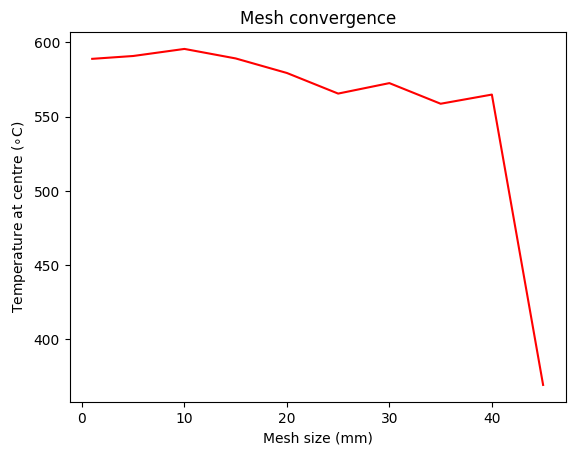

In [20]:
# mesh_name_format = "rectangle_{}.msh"

mesh_size_factors = np.array([1]+ np.arange(5,50,5).tolist())
meshFactorForAdaptiveSurface = 0.15
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
numberOfEles = []
for mesh_size_factor in mesh_size_factors:
    print(mesh_size_factor)
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=mesh_size_factor,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=50,
                                    ySource=25,
                                    isMeshRectangle=True
                                )
    soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    numberOfEles.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    

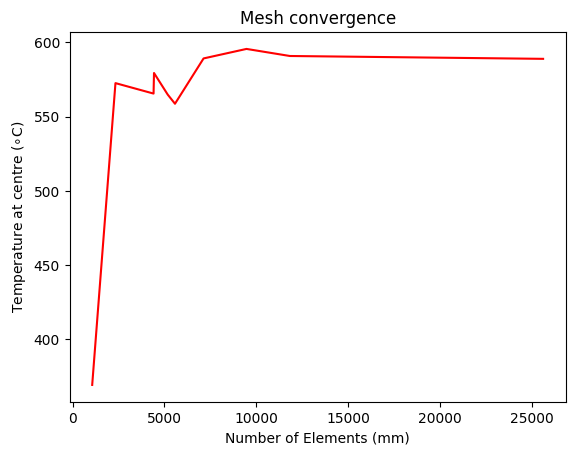

In [21]:
ele = np.argsort(numberOfEles)
plt.plot(np.array(numberOfEles)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

## Final solution

In [22]:
def picard(nodecoords,ele_con,theta_init,source,mode="non_linear"):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes
    theta_old = theta_init

    e = 1e5
    tolerance = 1e-4
    iter = 0
    
    while(e>tolerance):
        iter +=1
        _,_,_,_,_,theta_new = FEM(nodecoords,ele_con,source).fit_ele(theta_prev_time = theta_init,theta_prev_pic = theta_old,mode = mode)
        e = np.linalg.norm(theta_new - theta_old) 
        
        theta_old = theta_new
        print(f"Error at {iter} iteration is {e:.2E}")
        # print(theta_init)
    plt.figure(figsize=(8,4))
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten(),cmap='jet')
    plt.title(f"Source at {source[0,0],source[0,1]}")
    plt.colorbar()
    plt.show()

    return theta_new

Reading Mesh.msh
Number of nodes in the mesh: 13015
Number of triangles in the mesh: 25728



Reading Mesh.msh
Number of nodes in the mesh: 13015
Number of triangles in the mesh: 25728

Reading Mesh.msh
Number of nodes in the mesh: 13015
Number of triangles in the mesh: 25728

Time is 12.5 seconds
Error at 1 iteration is 5.24E+04
Error at 2 iteration is 6.34E+01
Error at 3 iteration is 3.43E-02
Error at 4 iteration is 1.14E-05


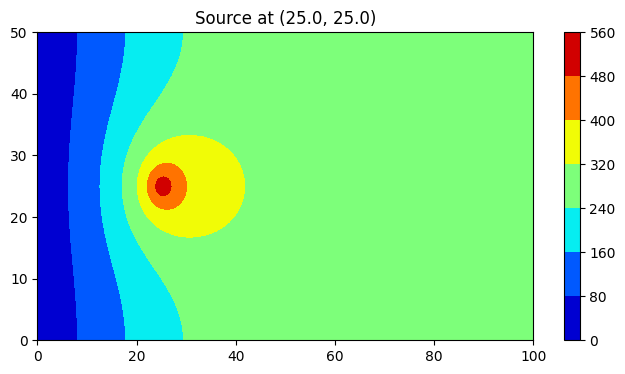

Reading Mesh.msh
Number of nodes in the mesh: 12958
Number of triangles in the mesh: 25614

Reading Mesh.msh
Number of nodes in the mesh: 12958
Number of triangles in the mesh: 25614

Time is 25 seconds
Error at 1 iteration is 4.42E+04
Error at 2 iteration is 5.26E+01
Error at 3 iteration is 2.52E-02
Error at 4 iteration is 6.43E-06


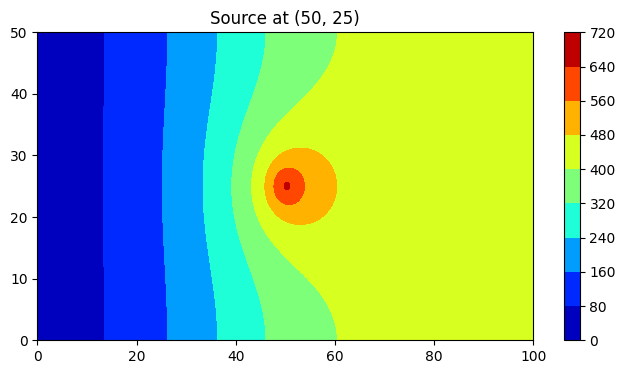

Reading Mesh.msh
Number of nodes in the mesh: 13093
Number of triangles in the mesh: 25884

Reading Mesh.msh
Number of nodes in the mesh: 13093
Number of triangles in the mesh: 25884

Time is 37.5 seconds
Error at 1 iteration is 4.57E+04
Error at 2 iteration is 3.65E+01
Error at 3 iteration is 1.44E-02
Error at 4 iteration is 3.67E-06


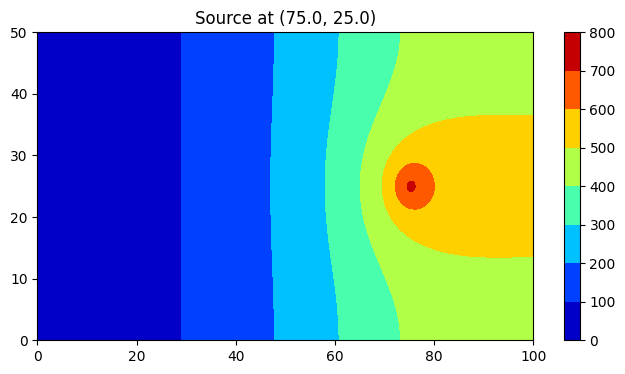

Reading Mesh.msh
Number of nodes in the mesh: 9493
Number of triangles in the mesh: 18610



In [29]:
T_l = 273+500
vo = 2 #mm/s
t_final = 10
times = [12.5,25,37.5]
convergedMeshFactorForEntireSurface = 1
x_source = 0
nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=convergedMeshFactorForEntireSurface,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=x_source +times[0]*vo,
                                    ySource=25,
                                    isMeshRectangle=True)

theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
for i,t in enumerate(times):
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=convergedMeshFactorForEntireSurface,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=x_source+vo*t,
                                    ySource=25,
                                    isMeshRectangle=True
                                )
    print(f"Time is {t} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+vo*t,25]]))
    nodecoords,_ = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=convergedMeshFactorForEntireSurface,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=x_source+vo*(times[i+1] if i+1 < len(times) else 0),
                                    ySource=25,
                                    isMeshRectangle=True
                                )
    theta_prev = np.zeros((nodecoords.shape[0],1))+T_l

0.7
Reading Mesh.msh
Number of nodes in the mesh: 3179
Number of triangles in the mesh: 6136

0.725
Reading Mesh.msh
Number of nodes in the mesh: 2918
Number of triangles in the mesh: 5624

0.75
Reading Mesh.msh
Number of nodes in the mesh: 2792
Number of triangles in the mesh: 5380

0.775
Reading Mesh.msh
Number of nodes in the mesh: 2595
Number of triangles in the mesh: 4990

0.8
Reading Mesh.msh
Number of nodes in the mesh: 2474
Number of triangles in the mesh: 4756

0.8250000000000001
Reading Mesh.msh
Number of nodes in the mesh: 2321
Number of triangles in the mesh: 4454

0.8500000000000001
Reading Mesh.msh
Number of nodes in the mesh: 2183
Number of triangles in the mesh: 4182

0.8750000000000001
Reading Mesh.msh
Number of nodes in the mesh: 2078
Number of triangles in the mesh: 3978

0.9000000000000001
Reading Mesh.msh
Number of nodes in the mesh: 2016
Number of triangles in the mesh: 3858

0.9250000000000002
Reading Mesh.msh
Number of nodes in the mesh: 1919
Number of triangles

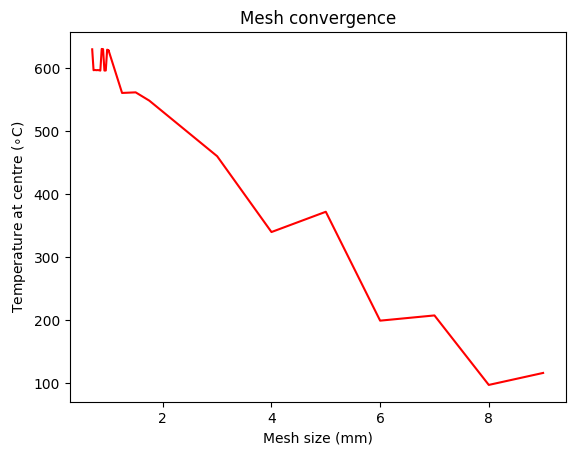

In [60]:
# mesh_name_format = "rectangle_{}.msh"

mesh_size_factors = np.array(np.arange(0.7,1,0.025).tolist()+ np.arange(1,2,0.25).tolist() + np.arange(3,10,1).tolist())
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
numberOfEles = []
for mesh_size_factor in mesh_size_factors:
    print(mesh_size_factor)
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=mesh_size_factor,
                                )
    soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    numberOfEles.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    

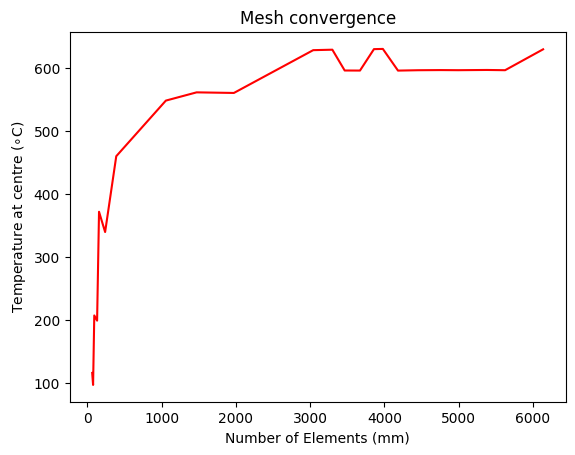

In [61]:
ele = np.argsort(numberOfEles)
plt.plot(np.array(numberOfEles)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 0 seconds
Error at 1 iteration is 2.43E+04
Error at 2 iteration is 3.20E+03
Error at 3 iteration is 4.96E+02
Error at 4 iteration is 1.31E+02
Error at 5 iteration is 1.81E+01
Error at 6 iteration is 4.89E+00
Error at 7 iteration is 6.55E-01
Error at 8 iteration is 1.80E-01
Error at 9 iteration is 2.40E-02
Error at 10 iteration is 6.33E-03
Error at 11 iteration is 8.84E-04
Error at 12 iteration is 2.15E-04
Error at 13 iteration is 3.23E-05


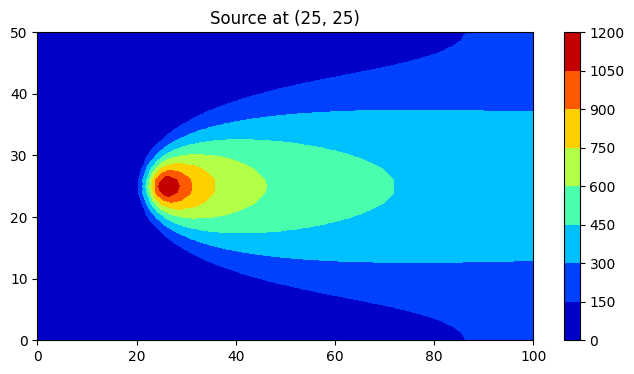

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 2 seconds
Error at 1 iteration is 2.96E+03
Error at 2 iteration is 1.56E+03
Error at 3 iteration is 2.57E+02
Error at 4 iteration is 8.29E+01
Error at 5 iteration is 1.16E+01
Error at 6 iteration is 3.56E+00
Error at 7 iteration is 5.10E-01
Error at 8 iteration is 1.37E-01
Error at 9 iteration is 2.16E-02
Error at 10 iteration is 4.83E-03
Error at 11 iteration is 8.69E-04
Error at 12 iteration is 1.62E-04
Error at 13 iteration is 3.31E-05


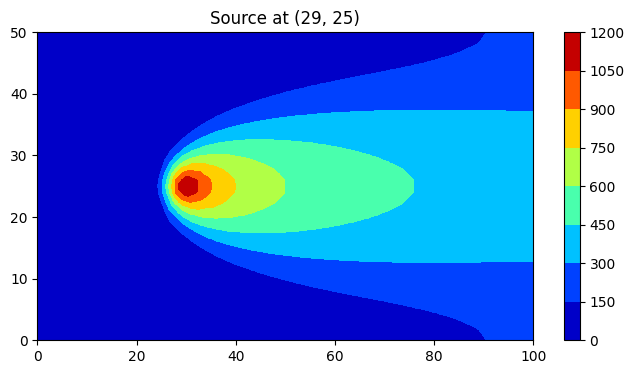

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 4 seconds
Error at 1 iteration is 2.98E+03
Error at 2 iteration is 1.53E+03
Error at 3 iteration is 2.53E+02
Error at 4 iteration is 8.10E+01
Error at 5 iteration is 1.14E+01
Error at 6 iteration is 3.48E+00
Error at 7 iteration is 4.98E-01
Error at 8 iteration is 1.34E-01
Error at 9 iteration is 2.11E-02
Error at 10 iteration is 4.74E-03
Error at 11 iteration is 8.47E-04
Error at 12 iteration is 1.60E-04
Error at 13 iteration is 3.23E-05


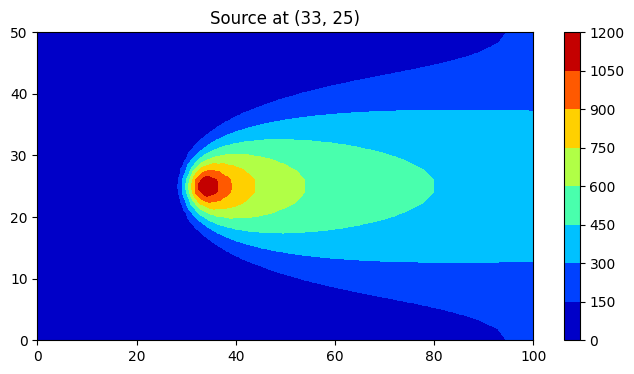

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 6 seconds
Error at 1 iteration is 2.95E+03
Error at 2 iteration is 1.51E+03
Error at 3 iteration is 2.50E+02
Error at 4 iteration is 7.90E+01
Error at 5 iteration is 1.11E+01
Error at 6 iteration is 3.37E+00
Error at 7 iteration is 4.80E-01
Error at 8 iteration is 1.29E-01
Error at 9 iteration is 2.01E-02
Error at 10 iteration is 4.55E-03
Error at 11 iteration is 7.96E-04
Error at 12 iteration is 1.53E-04
Error at 13 iteration is 3.00E-05


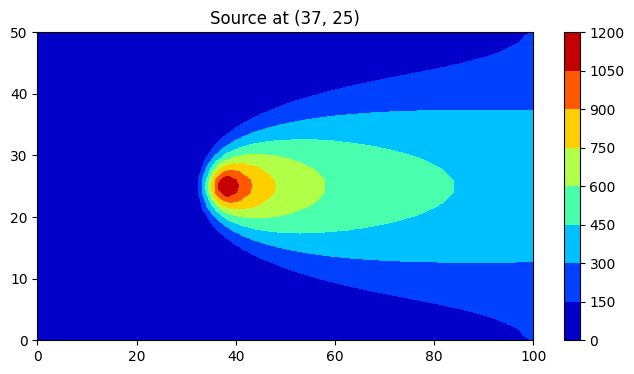

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 8 seconds
Error at 1 iteration is 2.90E+03
Error at 2 iteration is 1.48E+03
Error at 3 iteration is 2.47E+02
Error at 4 iteration is 7.67E+01
Error at 5 iteration is 1.08E+01
Error at 6 iteration is 3.26E+00
Error at 7 iteration is 4.65E-01
Error at 8 iteration is 1.24E-01
Error at 9 iteration is 1.91E-02
Error at 10 iteration is 4.36E-03
Error at 11 iteration is 7.46E-04
Error at 12 iteration is 1.45E-04
Error at 13 iteration is 2.76E-05


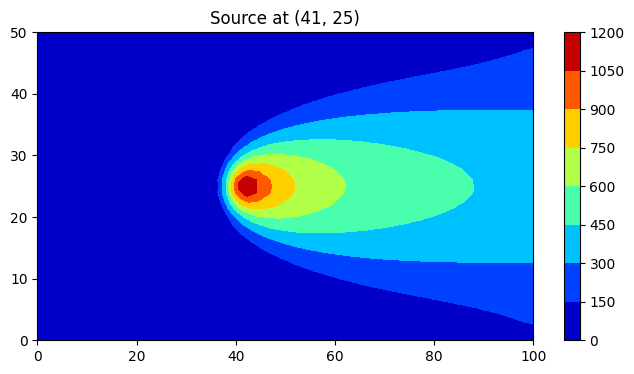

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 10 seconds
Error at 1 iteration is 2.89E+03
Error at 2 iteration is 1.45E+03
Error at 3 iteration is 2.46E+02
Error at 4 iteration is 7.45E+01
Error at 5 iteration is 1.07E+01
Error at 6 iteration is 3.17E+00
Error at 7 iteration is 4.55E-01
Error at 8 iteration is 1.21E-01
Error at 9 iteration is 1.87E-02
Error at 10 iteration is 4.25E-03
Error at 11 iteration is 7.25E-04
Error at 12 iteration is 1.42E-04
Error at 13 iteration is 2.68E-05


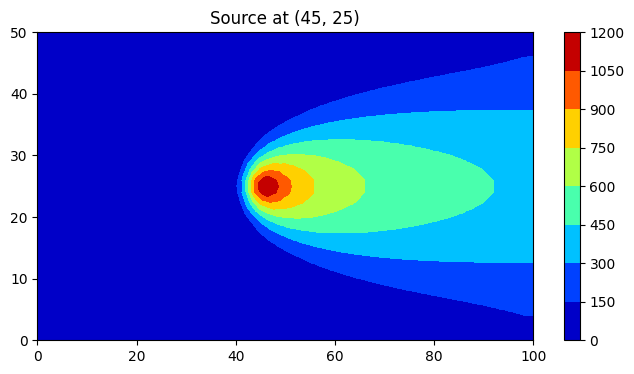

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 12 seconds
Error at 1 iteration is 2.84E+03
Error at 2 iteration is 1.43E+03
Error at 3 iteration is 2.42E+02
Error at 4 iteration is 7.25E+01
Error at 5 iteration is 1.04E+01
Error at 6 iteration is 3.08E+00
Error at 7 iteration is 4.45E-01
Error at 8 iteration is 1.18E-01
Error at 9 iteration is 1.83E-02
Error at 10 iteration is 4.21E-03
Error at 11 iteration is 7.19E-04
Error at 12 iteration is 1.43E-04
Error at 13 iteration is 2.69E-05


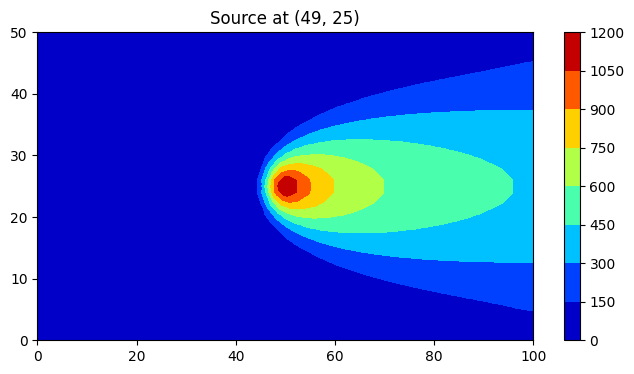

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 14 seconds
Error at 1 iteration is 2.88E+03
Error at 2 iteration is 1.40E+03
Error at 3 iteration is 2.40E+02
Error at 4 iteration is 7.02E+01
Error at 5 iteration is 1.03E+01
Error at 6 iteration is 2.99E+00
Error at 7 iteration is 4.35E-01
Error at 8 iteration is 1.15E-01
Error at 9 iteration is 1.78E-02
Error at 10 iteration is 4.15E-03
Error at 11 iteration is 6.99E-04
Error at 12 iteration is 1.43E-04
Error at 13 iteration is 2.63E-05


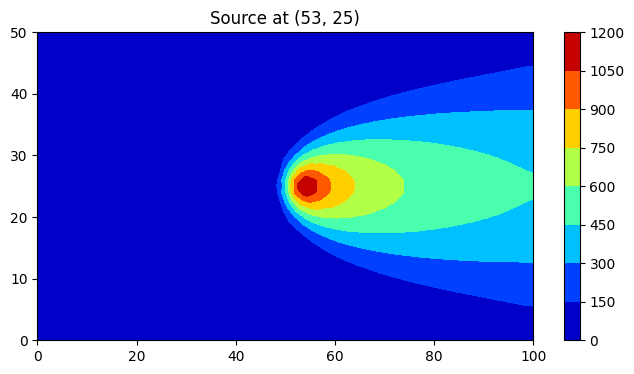

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 16 seconds
Error at 1 iteration is 2.90E+03
Error at 2 iteration is 1.36E+03
Error at 3 iteration is 2.36E+02
Error at 4 iteration is 6.73E+01
Error at 5 iteration is 9.94E+00
Error at 6 iteration is 2.85E+00
Error at 7 iteration is 4.16E-01
Error at 8 iteration is 1.10E-01
Error at 9 iteration is 1.68E-02
Error at 10 iteration is 3.92E-03
Error at 11 iteration is 6.51E-04
Error at 12 iteration is 1.34E-04
Error at 13 iteration is 2.42E-05


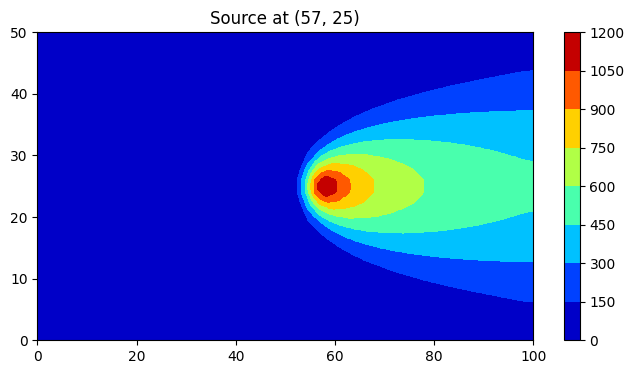

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 18 seconds
Error at 1 iteration is 2.85E+03
Error at 2 iteration is 1.33E+03
Error at 3 iteration is 2.32E+02
Error at 4 iteration is 6.44E+01
Error at 5 iteration is 9.63E+00
Error at 6 iteration is 2.71E+00
Error at 7 iteration is 3.97E-01
Error at 8 iteration is 1.04E-01
Error at 9 iteration is 1.57E-02
Error at 10 iteration is 3.70E-03
Error at 11 iteration is 5.98E-04
Error at 12 iteration is 1.26E-04
Error at 13 iteration is 2.19E-05


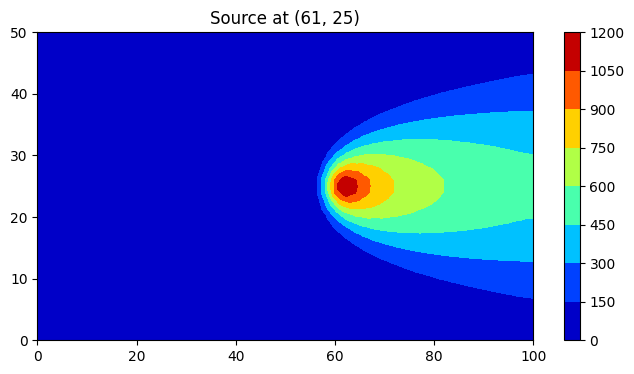

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 20 seconds
Error at 1 iteration is 2.85E+03
Error at 2 iteration is 1.29E+03
Error at 3 iteration is 2.29E+02
Error at 4 iteration is 6.14E+01
Error at 5 iteration is 9.38E+00
Error at 6 iteration is 2.60E+00
Error at 7 iteration is 3.87E-01
Error at 8 iteration is 1.00E-01
Error at 9 iteration is 1.54E-02
Error at 10 iteration is 3.61E-03
Error at 11 iteration is 5.91E-04
Error at 12 iteration is 1.24E-04
Error at 13 iteration is 2.19E-05


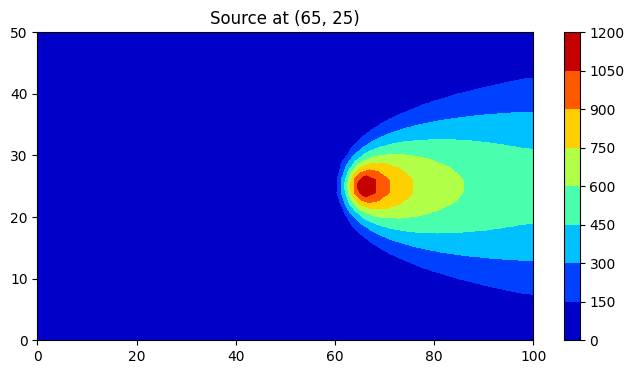

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 22 seconds
Error at 1 iteration is 2.81E+03
Error at 2 iteration is 1.24E+03
Error at 3 iteration is 2.27E+02
Error at 4 iteration is 5.84E+01
Error at 5 iteration is 9.18E+00
Error at 6 iteration is 2.50E+00
Error at 7 iteration is 3.80E-01
Error at 8 iteration is 9.83E-02
Error at 9 iteration is 1.54E-02
Error at 10 iteration is 3.60E-03
Error at 11 iteration is 6.09E-04
Error at 12 iteration is 1.25E-04
Error at 13 iteration is 2.32E-05


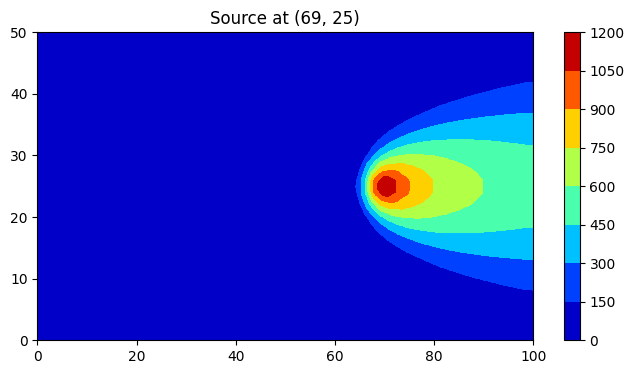

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 24 seconds
Error at 1 iteration is 2.79E+03
Error at 2 iteration is 1.20E+03
Error at 3 iteration is 2.22E+02
Error at 4 iteration is 5.50E+01
Error at 5 iteration is 8.81E+00
Error at 6 iteration is 2.35E+00
Error at 7 iteration is 3.61E-01
Error at 8 iteration is 9.28E-02
Error at 9 iteration is 1.46E-02
Error at 10 iteration is 3.43E-03
Error at 11 iteration is 5.76E-04
Error at 12 iteration is 1.21E-04
Error at 13 iteration is 2.22E-05


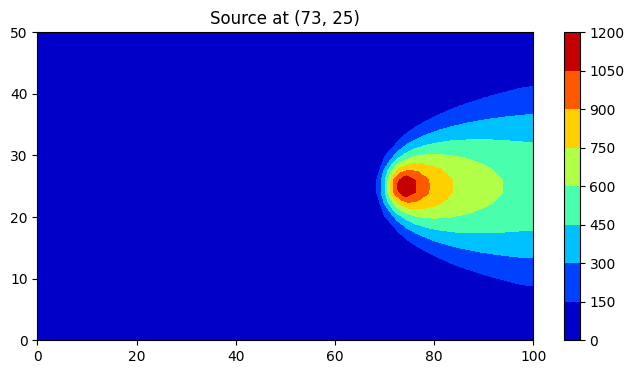

In [32]:
nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                meshFactorForEntireSurface=1
                                )
T_l = 273+500
vo = 2 #mm/s
t_final = 25
times = np.arange(0,t_final,2)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 25
for t in times:
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=1
                                )
    print(f"Time is {t} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+vo*t,25]]),mode="phase_change")
    theta_prev = theta_final